# Stock Deep Recurrent Q-Network 
This notebook provides an implementation of a Deep Double Recurrent Q-Network which can solve Partially Observable Markov Decision Processes. This notebook applies the technique on time series.

In [1]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import os
import csv
import itertools
%matplotlib inline
import time
from sklearn.preprocessing import MinMaxScaler
from helper import *
from StockEnv import StockEnv
import pandas as pd
from GeometricBrownianMotionTest2 import * 
from MCSAmericanOptionPricing import *

seed = 24 #1 #time.time()
random.seed(seed)
print('Seed is:' + str(seed))

/misc/home/reco/fathanab/anaconda3/envs/tfenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/misc/home/reco/fathanab/anaconda3/envs/tfenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/misc/home/reco/fathanab/anaconda3/envs/tfenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/misc/home/re

Seed is:24


In [2]:
"""os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(os.environ["CUDA_VISIBLE_DEVICES"])
print(tf.test.is_gpu_available())
print(tf.test.gpu_device_name())
print(get_available_gpus())"""

'os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"\nfrom tensorflow.python.client import device_lib\ndef get_available_gpus():\n    local_device_protos = device_lib.list_local_devices()\n    return [x.name for x in local_device_protos if x.device_type == \'GPU\']\n\nprint(os.environ["CUDA_VISIBLE_DEVICES"])\nprint(tf.test.is_gpu_available())\nprint(tf.test.gpu_device_name())\nprint(get_available_gpus())'

### Variable settings

In [3]:
"""So = 100 #spot_price #110 #90 #100 110 #127.62 #90
strike_price = 100 #130 #100
mu = 10/100 #risk_free_rate #0.001 #5/100
sigma = 0.20 #volatility # the historical vols or implied vols
dividend_rate = 0.0 #0.0163 #dividend yield of 1.63%
num_seeds = 20000"""
risk_free_rate = 5/100
mu = risk_free_rate
sigma = 0.20
num_seeds = 200 #60

In [4]:
save_model_freq = 10000 #5000
Normalization = False #True #False
Window_Normalization = False #True #False
test_data_ratio = 0.2 #0.3 # 0.2

architecture = 0 #3 #0 #1 #2 #3 #4 #5
nbFilters = 32 #16 #1
paddingType = 'same' #'causal' # 'valid'
huber_loss = True #False
dueling_type = 'max' #'naive'
mask_type = 'default' #'maskFirstHalf' # 'maskByWeights' 'default'
apply_dropout = True
batch_size = 128 #16 #32 #128 #60 #20 #4 #How many experience traces to use for each training step.
memory_capacity = 10000 #3000 #1000
learning_rate = 0.00005 #0.00025 #0.01 0.025 0.0025 0.0001
apply_grad_clipping = True
grad_clipping = 5 # Maybe test with bigger values, e.g. 40 or 30
optimizer_type = 'Adam' # 'GradientDescent' 'RMSProp'

Colab = False
scriptDirectory = os.getcwd() #"C:\Code_RL\2019_11_21_shuffled_GBM_version" #"C:\\Code_RL" # os.getcwd()

history_t = 15 #5 #15 #2 #15 ##
option_T = 50 #65 #50 #100 #365 #100 #200 #365 #65 #30 #15 #40 #30 ##
#build_warm_up_state_t = option_T // 3 #option_T // 2
input_size = history_t + 2
is_training = True

In [5]:
"""stock_names = ['hpq.us.txt', 'aapl.us.txt', 'goog.us.txt', 'ibm.us.txt', 'ups.us.txt',
              'jnj.us.txt', 'msft.us.txt', 'pg.us.txt', 'tsn.us.txt', 'usa.us.txt',
              'tex.us.txt', 'sam.us.txt', 'salt.us.txt', 'tlys.us.txt', 'trq.us.txt',
              'trno.us.txt', 'trk.us.txt', 'tnp.us.txt', 'tjx.us.txt', 'tpx.us.txt',
              'fb.us.txt', 'jpm.us.txt', 'v.us.txt', 'bac.us.txt',
               'ma.us.txt', 'hd.us.txt', 'tsm.us.txt', 'dis.us.txt',
               'intc.us.txt', 'vz.us.txt', 'rds-b.us.txt', 'tm.us.txt',
               'cvx.us.txt','wfc.us.txt', 'nvs.us.txt', 'ko.us.txt',
              'mrk.us.txt', 'ba.us.txt', 'pfe.us.txt', 'cmcsa.us.txt',
               'sap.us.txt', 'chl.us.txt', 'ul.us.txt', 'bud.us.txt',
               'un.us.txt','wfc.us.txt', 'mdt.us.txt', 'hsbc.us.txt',
              'mcd.us.txt', 'nke.us.txt', 'adbe.us.txt', 'crm.us.txt',
               'tot.us.txt', 'ptr.us.txt', 'cost.us.txt', 'bp.us.txt',
               'pm.us.txt', 'amgn.us.txt', 'abbv.us.txt', 'hon.us.txt']
stocks_train_data = []
stocks_test_data = []
real_stocks_train_data = []
real_stocks_test_data = []
for stock_name in stock_names:
    #train_data, test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    train_data, test_data, real_train_data, real_test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    stocks_train_data.append(train_data)
    stocks_test_data.append(test_data)
    real_stocks_train_data.append(real_train_data)
    real_stocks_test_data.append(real_test_data)
    plt.plot(range(len(train_data)), train_data, color='b')
    plt.plot(range(len(test_data)), test_data, color='r')  """ 

"stock_names = ['hpq.us.txt', 'aapl.us.txt', 'goog.us.txt', 'ibm.us.txt', 'ups.us.txt',\n              'jnj.us.txt', 'msft.us.txt', 'pg.us.txt', 'tsn.us.txt', 'usa.us.txt',\n              'tex.us.txt', 'sam.us.txt', 'salt.us.txt', 'tlys.us.txt', 'trq.us.txt',\n              'trno.us.txt', 'trk.us.txt', 'tnp.us.txt', 'tjx.us.txt', 'tpx.us.txt',\n              'fb.us.txt', 'jpm.us.txt', 'v.us.txt', 'bac.us.txt',\n               'ma.us.txt', 'hd.us.txt', 'tsm.us.txt', 'dis.us.txt',\n               'intc.us.txt', 'vz.us.txt', 'rds-b.us.txt', 'tm.us.txt',\n               'cvx.us.txt','wfc.us.txt', 'nvs.us.txt', 'ko.us.txt',\n              'mrk.us.txt', 'ba.us.txt', 'pfe.us.txt', 'cmcsa.us.txt',\n               'sap.us.txt', 'chl.us.txt', 'ul.us.txt', 'bud.us.txt',\n               'un.us.txt','wfc.us.txt', 'mdt.us.txt', 'hsbc.us.txt',\n              'mcd.us.txt', 'nke.us.txt', 'adbe.us.txt', 'crm.us.txt',\n               'tot.us.txt', 'ptr.us.txt', 'cost.us.txt', 'bp.us.txt',\n              

min value of data: 120.17629833877204, max value of data: 160.13925789827366
train_size: 743
test_size: 185
min value of data: 45.986248424777116, max value of data: 73.5797532231566
train_size: 743
test_size: 185
min value of data: 65.78933875750742, max value of data: 111.7371006220455
train_size: 743
test_size: 185
min value of data: 82.62843738885131, max value of data: 130.93914909050758
train_size: 743
test_size: 185
min value of data: 95.78714203983104, max value of data: 145.15409748626826
train_size: 743
test_size: 185
min value of data: 53.235928082108906, max value of data: 90.07962858852832
train_size: 743
test_size: 185
min value of data: 115.53356854023272, max value of data: 216.24842905183326
train_size: 743
test_size: 185
min value of data: 35.05825848444514, max value of data: 83.16582914572865
train_size: 743
test_size: 185
min value of data: 128.14003706420576, max value of data: 296.3874826904585
train_size: 743
test_size: 185
min value of data: 61.04042515811036, 

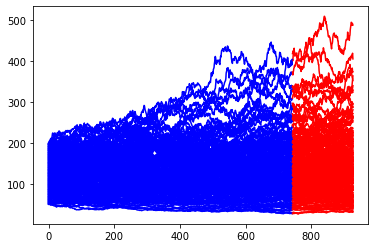

In [6]:
#Generate stocks data
stocks_data, _ = GBM(num_seeds, is_training).generate_stock_paths(mu, sigma, 928, num_seeds, is_training)
stocks_train_data = []
stocks_test_data = []
real_stocks_train_data = []
real_stocks_test_data = []
for stock_data in stocks_data:
    #train_data, test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    #train_data, test_data, real_train_data, real_test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    train_data, test_data, real_train_data, real_test_data = prepare_company_stock(stock_data, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    stocks_train_data.append(train_data)
    stocks_test_data.append(test_data)
    real_stocks_train_data.append(real_train_data)
    real_stocks_test_data.append(real_test_data)
    plt.plot(range(len(train_data)), train_data, color='b')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, color='r') 

### Load the game environment

Setting our environment

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 1059
num_episodes_per_epoch: 135600
min value of stock: 106.01567271416633, max value of stock: 197.0211505221744


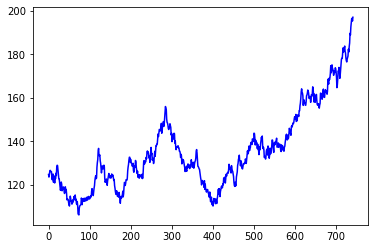

In [7]:
############################################################################
#env = StockEnv(train_data, risk_free_rate, history_t=history_t, option_T=option_T)
env = StockEnv(stocks_train_data, real_stocks_train_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
build_warm_up_state_t = env.get_build_warm_up_state()
trace_length = option_T - build_warm_up_state_t
num_samples = batch_size*trace_length
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(train_data)) + ', max value of stock: '+str(max(train_data)))
plt.plot(range(len(train_data)), train_data, color='b')

In [8]:
kappa=1.0
num_tau_samples=64
num_tau_prime_samples=64
num_quantile_samples=32
quantile_embedding_dim=64

# to remove and keep num_quantile_samples only
#num_quantiles = num_quantile_samples
double_dqn = True
num_actions = 2

### Implementing the network itself

In [9]:
class Qnetwork():
    def __init__(self,myScope):
        
        self.scalarInput = tf.placeholder(shape=[None,input_size],dtype=tf.float32, name='scalarInput')
        
        # depending on the chosen architecture, data is processed through differents layers
        
        # convolutions are used in all type, except architecture 0 which only uses LSTM
        if architecture != 0:
          self.InputConvIn = tf.reshape(self.scalarInput,shape=[-1,input_size,1], name='InputConvIn')
          self.conv1 = tf.keras.layers.Conv1D(filters=nbFilters,
                                               kernel_size=3,
                                               strides=1,
                                               padding= paddingType, #'same',
                                               activation=tf.nn.relu)(inputs=self.InputConvIn)
        
        if architecture == 0: # LSTM only
          self.scalarInputFlattened = tf.keras.layers.Flatten()(self.scalarInput)
        elif architecture == 1: # only one convolution
          self.conv1flattened = tf.reshape(self.conv1,shape=[-1,self.conv1.shape[1]*self.conv1.shape[2]], name='conv1flattened')
        elif architecture == 2: # only one convolution followed by max pooling
          self.maxPooling1D = tf.keras.layers.MaxPool1D(pool_size=2, strides=2, padding='same')(inputs=self.conv1)
          self.maxPooling1Dflattened = tf.reshape(self.maxPooling1D,shape=[-1,self.maxPooling1D.shape[1]*self.maxPooling1D.shape[2]], name='maxPooling1Dflattened')
        elif architecture == 3: # only one convolution followed by average pooling
          self.AveragePooling1D = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv1)
          self.AveragePooling1Dflattened = tf.reshape(self.AveragePooling1D,shape=[-1,self.AveragePooling1D.shape[1]*self.AveragePooling1D.shape[2]], name='AveragePooling1Dflattened')  
        elif architecture == 4: #VGG (one block of 2 convolutions followed by avg pooling)
          self.conv2 = tf.keras.layers.Conv1D(filters=nbFilters,
                                               kernel_size=3,
                                               strides=1,
                                               padding= paddingType, #'same',
                                               activation=tf.nn.relu)(inputs=self.conv1)
          self.AveragePooling1D4 = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv2)
          self.AveragePooling1Dflattened4 = tf.reshape(self.AveragePooling1D4,shape=[-1,self.AveragePooling1D4.shape[1]*self.AveragePooling1D4.shape[2]], name='AveragePooling1Dflattened4')
        elif architecture == 5: #Lenet (conv, avg pooling, conv, avg pooling)
          self.AveragePooling1D = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv1)
          self.conv2 = tf.keras.layers.Conv1D(filters=nbFilters,
                                               kernel_size=3,#5, #3, #maybe unstable calculations because of 5 instead of 3
                                               strides=1,
                                               padding= paddingType, #'same',
                                               #activation=tf.keras.activations.hard_sigmoid
                                               #activation=tf.keras.activations.sigmoid
                                               #activation=tf.keras.activations.tanh
                                               activation=tf.nn.relu)(inputs=self.AveragePooling1D)
          self.AveragePooling1D5 = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv2)
          self.AveragePooling1Dflattened5 = tf.reshape(self.AveragePooling1D5,shape=[-1,self.AveragePooling1D5.shape[1]*self.AveragePooling1D5.shape[2]], name='AveragePooling1Dflattened5')
        elif architecture == 6: #Googlenet (Inception net: combine (conv&avgPooling) + conv1 + conv3 + conv5)
          self.AveragePooling1D = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='same')(inputs=self.conv1)
          self.conv11 = tf.keras.layers.Conv1D(filters=5,
                                             kernel_size=1,
                                             strides=1,
                                             padding=paddingType,#'same',
                                             activation=tf.nn.relu)(inputs=self.AveragePooling1D)
          self.conv3 = tf.keras.layers.Conv1D(filters=5,
                                             kernel_size=3,
                                             strides=1,
                                             padding=paddingType,#'same',
                                             activation=tf.nn.relu)(inputs=self.AveragePooling1D)
          self.conv5 = tf.keras.layers.Conv1D(filters=5,
                                             kernel_size=5,
                                             strides=1,
                                             padding=paddingType,#'same',
                                             activation=tf.nn.relu)(inputs=self.AveragePooling1D)
          self.filterconcatenation = tf.concat([self.conv11, self.conv3, self.conv5, self.AveragePooling1D], 2, name = 'filterconcatenation')
          self.filterconcatenationflattened = tf.reshape(self.filterconcatenation,shape=[-1,self.filterconcatenation.shape[1]*self.filterconcatenation.shape[2]], name='filterconcatenationflattened')
        
        self.trainLength = tf.placeholder(dtype=tf.int32, name='trainLength')
        self.batch_size = tf.placeholder(dtype=tf.int32,shape=[], name='batch_size')
 
        #We take the output from the final convolutional layer and send it to a recurrent layer.
        #The input must be reshaped into [batch x trace x units] for rnn processing, 
        #and then returned to [batch x units] when sent through the upper levles.
        if architecture == 0:
          self.convFlat = tf.reshape(self.scalarInputFlattened,[self.batch_size,self.trainLength,input_size])
        elif architecture == 1:
          self.convFlat = tf.reshape(self.conv1flattened,[self.batch_size,self.trainLength,self.conv1flattened.shape[1]])
        elif architecture == 2:
          self.convFlat = tf.reshape(self.maxPooling1Dflattened,[self.batch_size,self.trainLength,self.maxPooling1Dflattened.shape[1]])
        elif architecture == 3:
          self.convFlat = tf.reshape(self.AveragePooling1Dflattened,[self.batch_size,self.trainLength,self.AveragePooling1Dflattened.shape[1]])
        elif architecture == 4:
          self.convFlat = tf.reshape(self.AveragePooling1Dflattened4,[self.batch_size,self.trainLength,self.AveragePooling1Dflattened4.shape[1]])
        elif architecture == 5:
          self.convFlat = tf.reshape(self.AveragePooling1Dflattened5,[self.batch_size,self.trainLength,self.AveragePooling1Dflattened5.shape[1]])
        elif architecture == 6:
          self.convFlat = tf.reshape(self.filterconcatenationflattened,[self.batch_size,self.trainLength,self.filterconcatenationflattened.shape[1]])
        
        # use cudnn-based cells to leverage Nvidia GPUs
        single_cell = lambda: tf.contrib.cudnn_rnn.CudnnCompatibleLSTMCell(h_size)
    
        # NOTE: Even if there's only one layer, the cell needs to be wrapped in MultiRNNCell.
        lstm_cells = [single_cell() for _ in range(num_layers)]
        if is_training and apply_dropout and dropout < 1:
            lstm_cells = [tf.contrib.rnn.DropoutWrapper(
                lstm, input_keep_prob=1.0, output_keep_prob=1.0 - dropout, state_keep_prob=1.0 - dropout
            ) for lstm in lstm_cells]
        multi_cell = tf.nn.rnn_cell.MultiRNNCell(lstm_cells, state_is_tuple=True)

        self.state_in = tf.placeholder(tf.float32, [num_layers, 2, None, h_size], name='state_in')
        state_per_layer_list = tf.unstack(self.state_in, axis=0)
        rnn_tuple_state = tuple(
            [tf.contrib.rnn.LSTMStateTuple(state_per_layer_list[idx][0], state_per_layer_list[idx][1])
             for idx in range(num_layers)]
        )
        
        # calculate the real length of each episode (since remaining states are filled with 0s after selling)
        # This is required by RNN 
        self.seq_len = length(self.convFlat)
        
        self.rnn,self.rnn_state = tf.nn.dynamic_rnn(\
                cell=multi_cell,
                inputs=self.convFlat,                                    
                dtype=tf.float32,
                initial_state=rnn_tuple_state, 
                sequence_length=self.seq_len,
                scope=myScope+'_lstm')
        

        self.rnn = tf.reshape(self.rnn,shape=[-1,h_size])
        ############################### IQN code
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32, name='actions')
        self.actions_onehot = tf.one_hot(self.actions,2,dtype=tf.float32)
        self.target_quantile_values = tf.placeholder(shape=[None, num_tau_prime_samples, 1],dtype=tf.float32, name='target_quantile_values')
        
        weights_initializer = slim.variance_scaling_initializer(factor=1.0 / np.sqrt(3.0), mode='FAN_IN', uniform=True)
        
        self.num_quantiles = tf.placeholder(dtype=tf.int32, name='num_quantiles')
        
        self.state_net_size = self.rnn.get_shape().as_list()[-1]
        state_net_tiled = tf.tile(self.rnn, [self.num_quantiles, 1])

        self.quantiles_shape = tf.placeholder(dtype=tf.int32, name='quantiles_shape')

        self.quantiles = tf.random_uniform([self.quantiles_shape, 1], minval=0, maxval=1, dtype=tf.float32)

        quantile_net = tf.tile(self.quantiles, [1, quantile_embedding_dim])
        pi = tf.constant(math.pi)
        quantile_net = tf.cast(tf.range(1, quantile_embedding_dim + 1, 1), tf.float32) * pi * quantile_net
        quantile_net = tf.cos(quantile_net)
        quantile_net = slim.fully_connected(quantile_net, self.state_net_size,
                                              weights_initializer=weights_initializer)
        # Hadamard product.
        net = tf.multiply(state_net_tiled, quantile_net)

        net = slim.fully_connected(net, 512, weights_initializer=weights_initializer)
        self.quantile_values = slim.fully_connected(
              net,
              num_actions,
              activation_fn=None,
              weights_initializer=weights_initializer)
        
        self._q_values = tf.reduce_mean(self.quantile_values, axis=0)
        self.predict = tf.argmax(self._q_values, axis=0)

        # Shape of indices: (num_tau_samples x batch_size) x 1.
        # Expand dimension by one so that it can be used to index into all the
        # quantiles when using the tf.gather_nd function (see below).
        indices = tf.range(num_tau_samples * num_samples)[:, None]

        # Expand the dimension by one so that it can be used to index into all the
        # quantiles when using the tf.gather_nd function (see below).
        reshaped_actions = self.actions[:, None]
        reshaped_actions = tf.tile(reshaped_actions, [num_tau_samples, 1])
        # Shape of reshaped_actions: (num_tau_samples x batch_size) x 2.
        reshaped_actions = tf.concat([indices, reshaped_actions], axis=1)

        chosen_action_quantile_values = tf.gather_nd(
            self.quantile_values, reshaped_actions)
        # Reshape to self.num_tau_samples x batch_size x 1 since this is the manner
        # in which the quantile values are tiled.
        chosen_action_quantile_values = tf.reshape(chosen_action_quantile_values,\
                                                   [num_tau_samples,num_samples, 1])
        # Transpose dimensions so that the dimensionality is batch_size x
        # self.num_tau_samples x 1 to prepare for computation of
        # Bellman errors.
        # Final shape of chosen_action_quantile_values:
        # batch_size x num_tau_samples x 1.
        chosen_action_quantile_values = tf.transpose(chosen_action_quantile_values, [1, 0, 2])

        # Shape of bellman_erors and huber_loss:
        # batch_size x num_tau_prime_samples x num_tau_samples x 1.
        bellman_errors = self.target_quantile_values[
            :, :, None, :] - chosen_action_quantile_values[:, None, :, :]
        # The huber loss (see Section 2.3 of the paper) is defined via two cases:
        # case_one: |bellman_errors| <= kappa
        # case_two: |bellman_errors| > kappa
        huber_loss_case_one = tf.to_float(
            tf.abs(bellman_errors) <= kappa) * 0.5 * bellman_errors ** 2
        huber_loss_case_two = tf.to_float(
            tf.abs(bellman_errors) > kappa) * kappa * (
                tf.abs(bellman_errors) - 0.5 * kappa)
        huber_loss = huber_loss_case_one + huber_loss_case_two

        # Reshape replay_quantiles to batch_size x num_tau_samples x 1
        replay_quantiles = tf.reshape(self.quantiles, [num_tau_samples, num_samples, 1])
        replay_quantiles = tf.transpose(replay_quantiles, [1, 0, 2])

        # Tile by num_tau_prime_samples along a new dimension. Shape is now
        # batch_size x num_tau_prime_samples x num_tau_samples x 1.
        # These quantiles will be used for computation of the quantile huber loss
        # below (see section 2.3 of the paper).
        replay_quantiles = tf.to_float(tf.tile(replay_quantiles[:, None, :, :], [1, num_tau_prime_samples, 1, 1]))
        # Shape: batch_size x num_tau_prime_samples x num_tau_samples x 1.
        quantile_huber_loss = (tf.abs(replay_quantiles - tf.stop_gradient(tf.to_float(bellman_errors < 0))) * huber_loss) / kappa
        # Sum over current quantile value (num_tau_samples) dimension,
        # average over target quantile value (num_tau_prime_samples) dimension.
        # Shape: batch_size x num_tau_prime_samples x 1.
        loss = tf.reduce_sum(quantile_huber_loss, axis=2)
        # Shape: batch_size x 1.
        loss = tf.reduce_mean(loss, axis=1)

        # divide by the real length of episodes instead of averaging which is incorrect
        self.loss = tf.cast(tf.reduce_sum(loss), tf.float64) / tf.cast(tf.reduce_sum(self.seq_len), tf.float64)
        
        #self.check_ops = tf.debugging.check_numerics(self.loss, "self.loss contain Nan or Inf", name="self.check_ops")
        
        
        if optimizer_type == 'Adam':
            optimizer = tf.train.AdamOptimizer(learning_rate)
        elif optimizer_type == 'GradientDescent':
            optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        elif optimizer_type == 'RMSProp':
            optimizer = tf.train.RMSPropOptimizer(learning_rate)
        
        if apply_grad_clipping:
            # calculate gradients and clip them to handle outliers
            tvars = tf.trainable_variables()
            grads, _ = tf.clip_by_global_norm(tf.gradients(self.loss, tvars), grad_clipping)
            self.updateModel = optimizer.apply_gradients(
                    zip(grads, tvars),
                    # global_step=tf.contrib.framework.get_or_create_global_step(),
                    name="updateModel")
        else:
            self.updateModel = optimizer.minimize(self.loss, name="updateModel")
            
    def _build_train_op(self):
        """Builds a training op.
        Returns:
          train_op: An op performing one step of training from replay data.
        """
        # Reshape to self.num_tau_prime_samples x batch_size x 1 since this is
        # the manner in which the target_quantile_values are tiled.
        self.target_quantile_values2 = tf.reshape(self.target_quantile_values,
                                            [num_tau_prime_samples,
                                             num_samples, 1])
        # Transpose dimensions so that the dimensionality is batch_size x
        # self.num_tau_prime_samples x 1 to prepare for computation of
        # Bellman errors.
        # Final shape of target_quantile_values:
        # batch_size x num_tau_prime_samples x 1.
        self.target_quantile_values = tf.transpose(self.target_quantile_values2, [1, 0, 2])

        # Shape of indices: (num_tau_samples x batch_size) x 1.
        # Expand dimension by one so that it can be used to index into all the
        # quantiles when using the tf.gather_nd function (see below).
        indices = tf.range(num_tau_samples * num_samples)[:, None]

        # Expand the dimension by one so that it can be used to index into all the
        # quantiles when using the tf.gather_nd function (see below).
        reshaped_actions = self.actions[:, None]
        reshaped_actions = tf.tile(reshaped_actions, [num_tau_samples, 1])
        # Shape of reshaped_actions: (num_tau_samples x batch_size) x 2.
        reshaped_actions = tf.concat([indices, reshaped_actions], axis=1)

        chosen_action_quantile_values = tf.gather_nd(
            self.quantile_values, reshaped_actions)
        # Reshape to self.num_tau_samples x batch_size x 1 since this is the manner
        # in which the quantile values are tiled.
        chosen_action_quantile_values = tf.reshape(chosen_action_quantile_values,
                                                   [num_tau_samples,
                                                    num_samples, 1])
        # Transpose dimensions so that the dimensionality is batch_size x
        # self.num_tau_samples x 1 to prepare for computation of
        # Bellman errors.
        # Final shape of chosen_action_quantile_values:
        # batch_size x num_tau_samples x 1.
        chosen_action_quantile_values = tf.transpose(
            chosen_action_quantile_values, [1, 0, 2])

        # Shape of bellman_erors and huber_loss:
        # batch_size x num_tau_prime_samples x num_tau_samples x 1.
        bellman_errors = self.target_quantile_values[
            :, :, None, :] - chosen_action_quantile_values[:, None, :, :]
        # The huber loss (see Section 2.3 of the paper) is defined via two cases:
        # case_one: |bellman_errors| <= kappa
        # case_two: |bellman_errors| > kappa
        huber_loss_case_one = tf.to_float(
            tf.abs(bellman_errors) <= kappa) * 0.5 * bellman_errors ** 2
        huber_loss_case_two = tf.to_float(
            tf.abs(bellman_errors) > kappa) * kappa * (
                tf.abs(bellman_errors) - 0.5 * kappa)
        huber_loss = huber_loss_case_one + huber_loss_case_two

        # Reshape replay_quantiles to batch_size x num_tau_samples x 1
        replay_quantiles = tf.reshape(
            self.quantiles, [num_tau_samples, num_samples, 1])
        replay_quantiles = tf.transpose(replay_quantiles, [1, 0, 2])

        # Tile by num_tau_prime_samples along a new dimension. Shape is now
        # batch_size x num_tau_prime_samples x num_tau_samples x 1.
        # These quantiles will be used for computation of the quantile huber loss
        # below (see section 2.3 of the paper).
        replay_quantiles = tf.to_float(tf.tile(
            replay_quantiles[:, None, :, :], [1, num_tau_prime_samples, 1, 1]))
        # Shape: batch_size x num_tau_prime_samples x num_tau_samples x 1.
        quantile_huber_loss = (tf.abs(replay_quantiles - tf.stop_gradient(
            tf.to_float(bellman_errors < 0))) * huber_loss) / kappa
        # Sum over current quantile value (num_tau_samples) dimension,
        # average over target quantile value (num_tau_prime_samples) dimension.
        # Shape: batch_size x num_tau_prime_samples x 1.
        loss = tf.reduce_sum(quantile_huber_loss, axis=2)
        # Shape: batch_size x 1.
        loss = tf.reduce_mean(loss, axis=1)

        # divide by the real length of episodes instead of averaging which is incorrect
        loss = tf.cast(tf.reduce_sum(loss), tf.float64) / tf.cast(tf.reduce_sum(self.seq_len), tf.float64)


        return loss
        

In [10]:
def _build_target_quantile_values_op(_replay_next_qt_argmax, _replay_net_target_quantile_values, 
                                     terminals, rewards):
    """Build an op used as a target for return values at given quantiles.
    Returns:
      An op calculating the target quantile return.
    """
    num_samples = batch_size*trace_length
    # Shape of rewards: (num_tau_prime_samples x batch_size) x 1.
    rewards = rewards[:, None]
    rewards = np.tile(rewards, [num_tau_prime_samples, 1])

    is_terminal_multiplier = 1. - terminals.astype(np.float32) #tf.to_float(terminals)
    # Incorporate terminal state to discount factor.
    # size of gamma_with_terminal: (num_tau_prime_samples x batch_size) x 1.
    gamma_with_terminal = gamma * is_terminal_multiplier
    gamma_with_terminal = np.tile(gamma_with_terminal[:, None],
                                  [num_tau_prime_samples, 1])

    # Get the indices of the maximium Q-value across the action dimension.
    # Shape of replay_next_qt_argmax: (num_tau_prime_samples x batch_size) x 1.

    replay_next_qt_argmax = np.tile(
        _replay_next_qt_argmax[:, None], [num_tau_prime_samples, 1])

    batch_indices = np.arange(num_tau_prime_samples * num_samples)[:, None].astype(np.int64)
    batch_indices = batch_indices * 2
    batch_indexed_target_values = batch_indices + replay_next_qt_argmax

    target_quantile_values = np.squeeze(np.take(_replay_net_target_quantile_values, 
                                                batch_indexed_target_values))[:, None]

    result = rewards + gamma_with_terminal * target_quantile_values

    return result

### Experience Replay

These classes allow us to store experies and sample then randomly to train the network.
Episode buffer stores experiences for each individal episode.
Experience buffer stores entire episodes of experience, and sample() allows us to get training batches needed from the network.

In [11]:
class experience_buffer():
    def __init__(self, buffer_size = memory_capacity, build_warm_up_state_t=build_warm_up_state_t):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + 1 >= self.buffer_size:
            self.buffer[0:(1+len(self.buffer))-self.buffer_size] = []
        self.buffer.append(experience)
    
    def sample(self,batch_size):
        sampled_episodes = random.sample(self.buffer,batch_size)
        #sampled_episodes = np.array(sampled_episodes)
        sampled_episodes = self.processEpisodes(sampled_episodes)
        return np.reshape(sampled_episodes,[-1,5])
    
    def processEpisodes(self,sampled_episodes):
        sampledTraces = []
        for episode in sampled_episodes:
            sampledTraces.append(episode[build_warm_up_state_t:])
        sampledTraces = np.array(sampledTraces)
        return sampledTraces

### Training the network

In [12]:
#Setting the training parameters
num_layers = 3 # Number of layer of LSTM
h_size = 512 #256 #512 #128 #512 #256 #512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
keep_prob = 0.8
dropout = 1 - keep_prob  # dropout amount
update_freq = 5 #30 #10 #5 #How often to perform a training step.
update_online_freq = 5 #10 #5 #3 #5
update_target_freq = 1000 #100 #300 #30
#gamma = discount_factor #.99 #.95 #1 #Discount factor on the target Q-values
gamma = env.get_discount_factor(1) # discount for 1 day
startE = 1 #0.1 #1 #Starting chance of random action
endE = 0.1 #0.01 #0.1 #Final chance of random action
num_epochs = 5
num_episodes = env.get_total_num_episodes_per_epoch()*num_epochs #30 #50000 #20000 #100000 #20000 #3000 #20000 #30000 #10000 #4000 #100000 #40000
pre_train_episodes = int(memory_capacity * 0.1) # 0.25 300 #300 #200 #600 #200
annealing_episodes = int(num_episodes * 0.3) #4*memory_capacity #0.7*memory_capacity #400 #memory_capacity #400
pre_exploitation_episodes = int(num_episodes * 0.6)
annealing_exploitation_episodes = int(num_episodes * 0.25)
exploitationE =  0.01 #0.008 #0.02
load_model = False #Whether to load a saved model.
path = os.path.join(scriptDirectory, 'savedModel') #The path to save our model to.
max_epLength = option_T #env.get_max_episode_time() #option_T + build_warm_up_state_t
summaryLength = 100 #Number of epidoes to periodically save for analysis
summaryAverageReward = 5000
summaryEpoch = env.get_total_num_episodes_per_epoch()
tau = 0.001 # learning rate (also referred to as step size) for target network
softUpdate = False # use soft or hard updates
#trained_model_name = os.path.join(path, 'architecture' + str(architecture) + '-option_T' + str(option_T) + '-history_t' + str(history_t) + '-num_episodes' + str(num_episodes) + '-tau' + str(tau) + '-softUpdate' + str(softUpdate) + '-dropout' + str(dropout) + '-mask' + str(mask_type) + '-dueling_type' + str(dueling_type) + '-So' + str(So) + '-strike_price' + str(strike_price) + '-mu' + str(mu) + '-sigma' + str(sigma) + '-num_seeds' + str(num_seeds))
trained_model_name = os.path.join(path, 'IQN_200noSoft_00005_1000freq_128batch_dropout_arch' + str(architecture)\
                    + '-option_T' + str(option_T) + '-history_t' + str(history_t)\
                    #+ '-num_episodes' + str(num_episodes)\
                    + '-softUpdate' + str(softUpdate)  + '-tau' + str(tau)\
                    #+ '-dropout' + str(dropout) + str(apply_dropout)\
                    #+ '-num_layers' + str(num_layers) + '-double_dqn' + str(double_dqn)\
                    + '-huber_loss' + str(huber_loss) #+ '-apply_dropout' + str(apply_dropout)\
                    + '-freq' + str(update_target_freq) + '-batch' + str(batch_size)\
                    + '-capacity' + str(memory_capacity) + '-lambda' + str(learning_rate))
final_trained_model_name = trained_model_name + '-final'
#final_trained_model_name = trained_model_name + '-530000_copy'
exploration_type = 'Random'
print('#num_episodes: ' + str(num_episodes))
print('#trace_length: ' + str(trace_length))
#print('#discount_factor: ' + str(discount_factor))
print('#gamma: ' + str(gamma))

#num_episodes: 678000
#trace_length: 38
#gamma: 0.9998016069840849


In [13]:
e=0

### Testing the network on train set again

In [14]:
#e = 0.03 #0.01 #The chance of chosing a random action
load_model = True #Whether to load a saved model.
is_training = False

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 1059
num_episodes_per_epoch: 135600
min value of stock: 183.89506559405115, max value of stock: 225.71786417155334


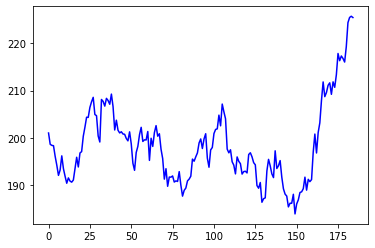

In [15]:
env = StockEnv(stocks_train_data, real_stocks_train_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
num_episodes = env.get_total_num_episodes_per_epoch()
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(test_data)) + ', max value of stock: '+str(max(test_data)))
plt.plot(range(len(test_data)), test_data, color='b')

In [16]:
begin_time = time.time()
tf.reset_default_graph()

mainQN = Qnetwork('main')
targetQN = Qnetwork('target')


init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=2)

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

#num_short_sell = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path) 
  

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    if load_model == True:
        print ('Loading Model...')
        #ckpt = tf.train.get_checkpoint_state(path)
        #saver.restore(sess,ckpt.model_checkpoint_path)
        saver.restore(sess,final_trained_model_name)
    else:
        sess.run(init)
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        #Reset the recurrent layer's hidden state
        state = np.zeros((num_layers, 2, 1, h_size))
        while j < max_epLength: 

            if j == max_epLength - 1 and env.is_episode_finished() == False:
                a = 1
            else:
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                        feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,\
                                   mainQN.state_in:state,mainQN.batch_size:1,\
                                   mainQN.num_quantiles:num_quantile_samples,\
                                   mainQN.quantiles_shape:num_quantile_samples})
                if env.get_time() < build_warm_up_state_t:
                    a = 0 #hold
                elif env.get_payoff() <= 0:
                    a = 0 #hold
                    #num_short_sell += 1
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            state = state1
            j+=1 # episode length till selling or reaching last day of option

            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
            
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Number of short selling: " + str(num_short_sell))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.

Loading Model...
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /misc/scratch05/patx/fathanab/Experiments_RL/normalizeFirstDay_seed_corrected_2019_11_21_shuffled_GBM_version/savedModel/IQN_200noSoft_00005_1000freq_128batch_dropout_arch0-option_T50-history_t15-softUpdateFalse-tau0.001-huber_lossTrue-freq1000-batch128-capacity10000-lambda5e-05-final
episode 100: 	0.025469912299491547	13.65
episode 200: 	0.0252509123098548

In [17]:
# Normal Test
# 4000 episodes
#Average reward per episode: -0.0004459820152409164%
#Time to execute: 1.0273285110791524min

# 10000 episodes of training (23000 episodes)
#Average reward per episode: -0.0006903839079534307%
#Time to execute: 18.210397080580393min

# 30000 episodes of training (23000 episodes)
#Average reward per episode: -0.0015529333479744412%
#Time to execute: 27.645483565330505min

# 20000 episodes of training
#Average reward per episode: -0.0049713977980137885%
#Time to execute: 31.664522131284077min

# 100000 episodes of training # architecture 0
#Total average reward per episode: -0.0031459276190924593
#Time to execute: 27.598839151859284min

#20000 episodes training
#Total average reward per episode: 0.0024760915583103395
#Time to execute: 2.219494903087616min

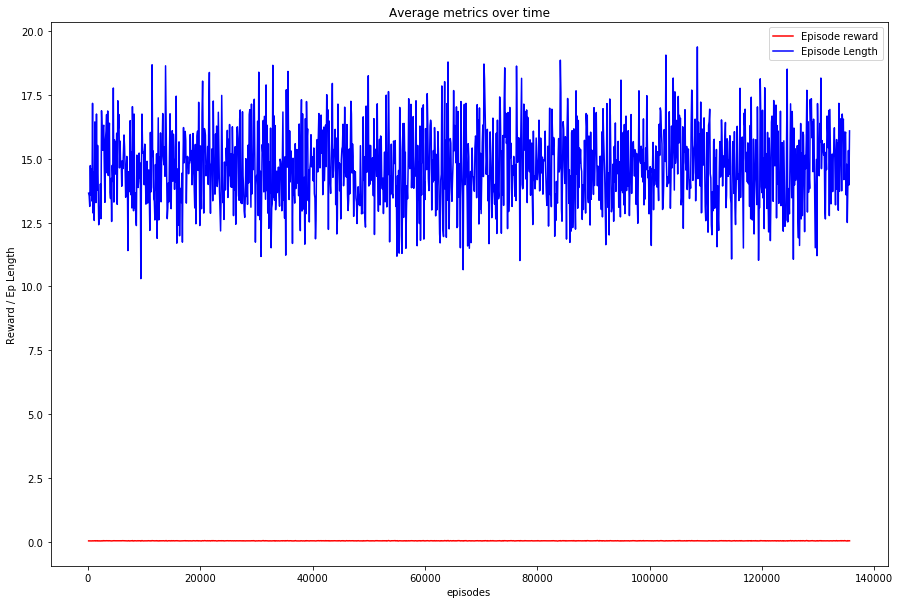

In [18]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

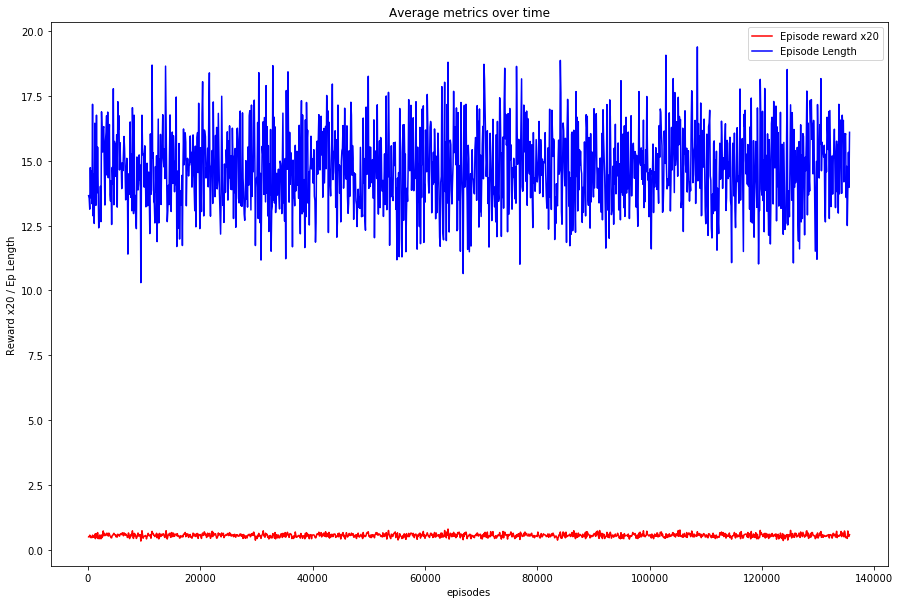

In [19]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

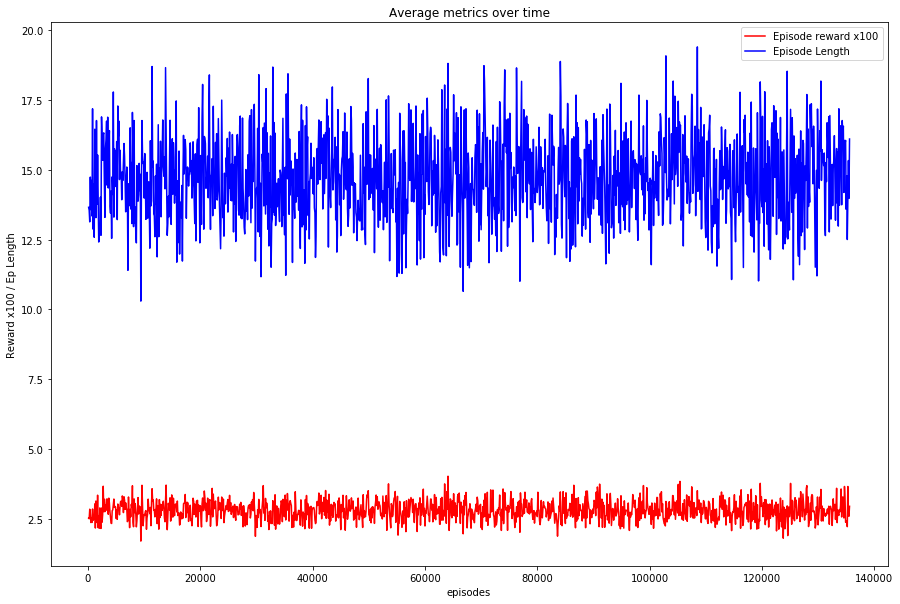

In [20]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

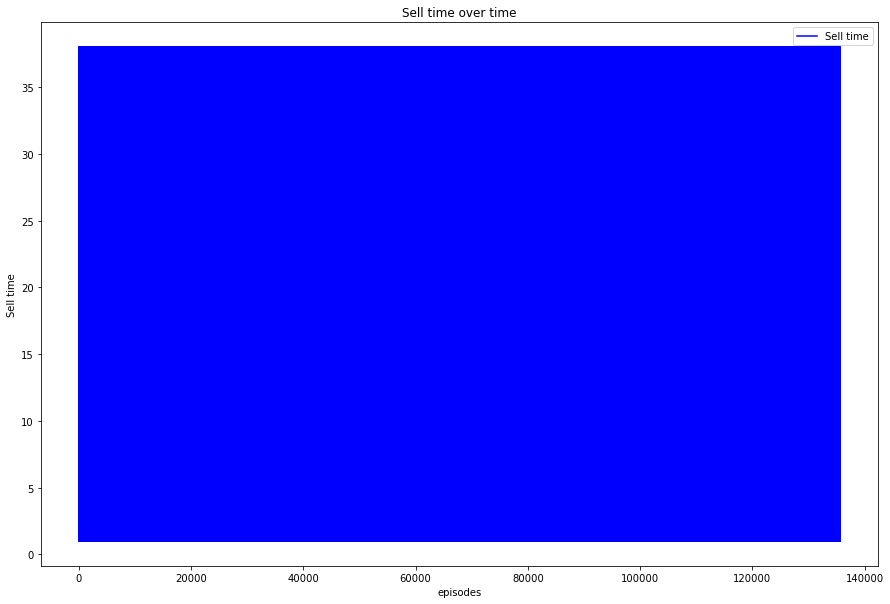

In [21]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select day of Min price over history [Benchmark]

In [22]:
env.reset_new_test() # reset to first observation in data
begin_time = time.time()

test = 'MinValue' #'Random'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []
  

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'MinValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MinValue':
              if env.get_time() >= build_warm_up_state_t and (s[-1] <= min(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break

        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.02829052512123336	17.28
episode 200: 	0.03225282623942747	17.65
episode 300: 	0.03041197228129994	18.02
episode 400: 	0.028841550516983606	19.5
episode 500: 	0.025183750873674013	17.28
episode 600: 	0.02470869872464701	19.13
episode 700: 	0.02212261396768372	16.54
episode 800: 	0.030668332772927576	21.72
episode 900: 	0.025786813117301337	17.28
episode 1000: 	0.027473233528177807	17.28
episode 1100: 	0.02868600332689313	16.54
episode 1200: 	0.03020748843937822	20.61
episode 1300: 	0.024670189049270368	16.91
episode 1400: 	0.03708699042311691	17.65
episode 1500: 	0.033808398413777724	20.98
episode 1600: 	0.02342520566400298	18.02
episode 1700: 	0.03078742719227767	20.61
episode 1800: 	0.022767476276335574	17.65
episode 1900: 	0.03089781039690951	16.91
episode 2000: 	0.025255288703976964	16.17
episode 2100: 	0.03119490609933352	17.65
episode 2200: 	0.023411172115325698	17.28
episode 2300: 	0.022341337555549234	15.06
episode 2400: 	0.026841210230448383	20.24
episode 2500: 

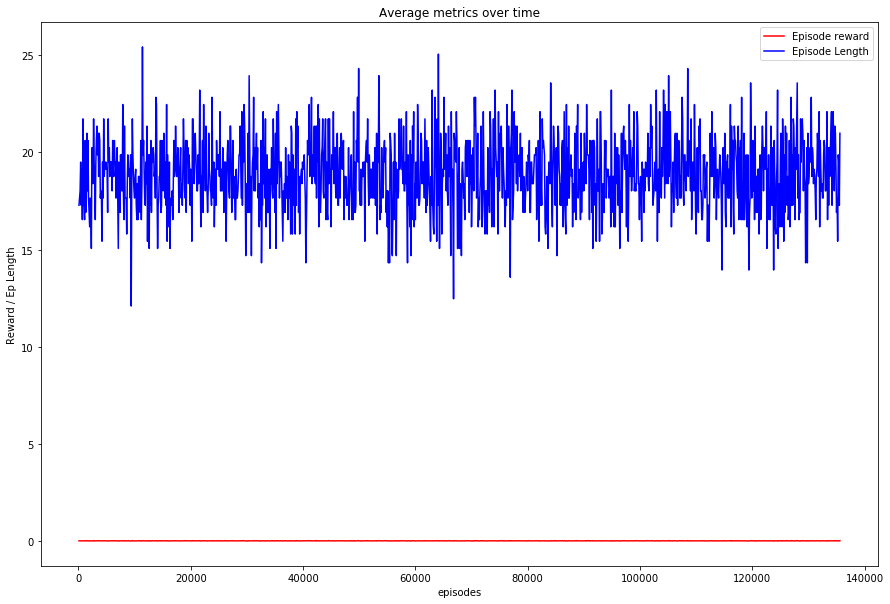

In [23]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

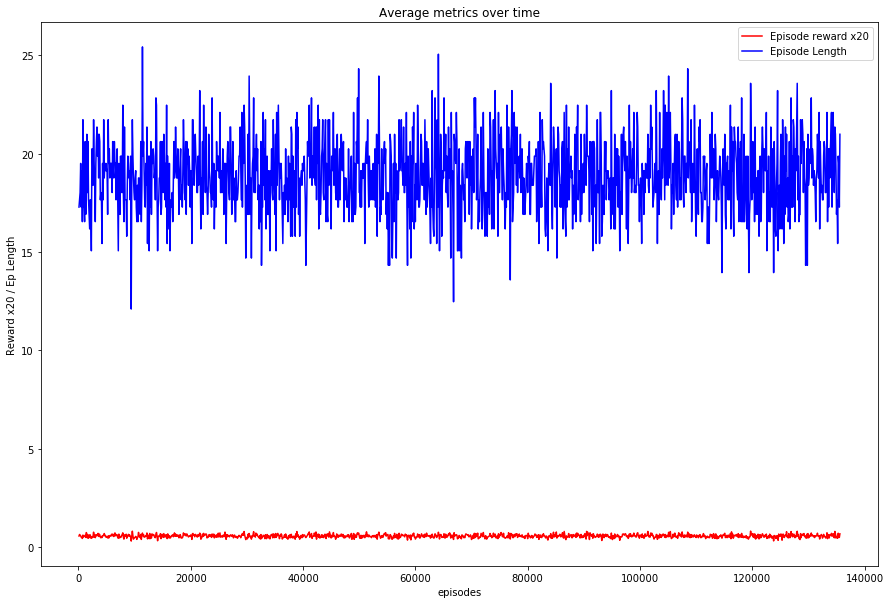

In [24]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

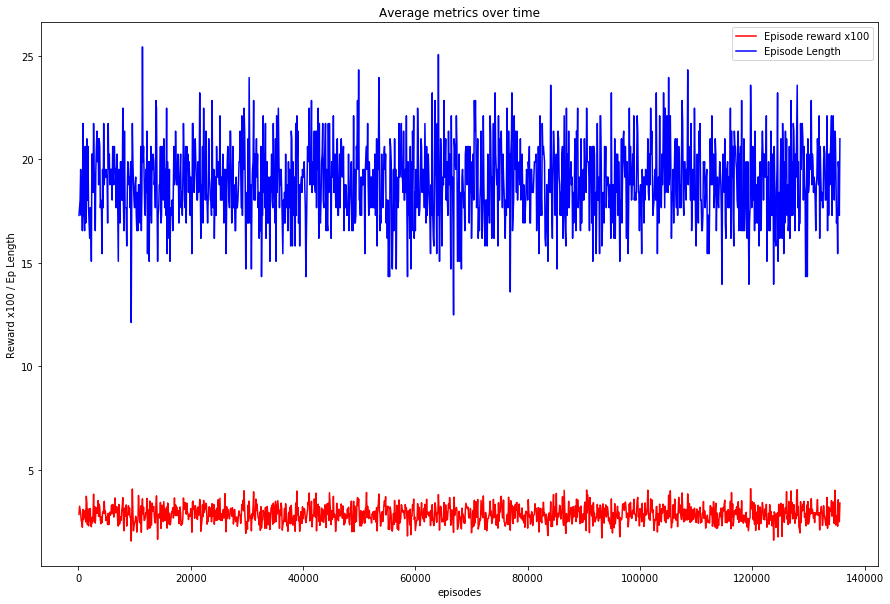

In [25]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

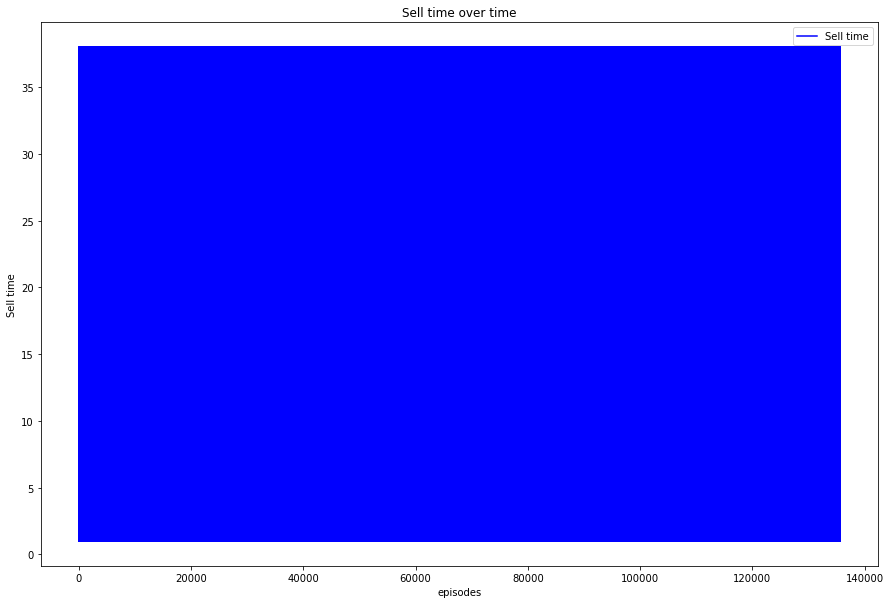

In [26]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select day of Max price over history [Benchmark]

In [27]:
env.reset_new_test() # reset to first observation in data
begin_time = time.time()

test = 'MaxValue' #'Random'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []
  

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MaxValue':
              if env.get_time() >= build_warm_up_state_t and (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break

        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.02829052512123336	17.28
episode 200: 	0.03225282623942747	17.65
episode 300: 	0.03041197228129994	18.02
episode 400: 	0.028841550516983606	19.5
episode 500: 	0.025183750873674013	17.28
episode 600: 	0.02470869872464701	19.13
episode 700: 	0.02212261396768372	16.54
episode 800: 	0.030668332772927576	21.72
episode 900: 	0.025786813117301337	17.28
episode 1000: 	0.027473233528177807	17.28
episode 1100: 	0.02868600332689313	16.54
episode 1200: 	0.03020748843937822	20.61
episode 1300: 	0.024670189049270368	16.91
episode 1400: 	0.03708699042311691	17.65
episode 1500: 	0.033808398413777724	20.98
episode 1600: 	0.02342520566400298	18.02
episode 1700: 	0.03078742719227767	20.61
episode 1800: 	0.022767476276335574	17.65
episode 1900: 	0.03089781039690951	16.91
episode 2000: 	0.025255288703976964	16.17
episode 2100: 	0.03119490609933352	17.65
episode 2200: 	0.023411172115325698	17.28
episode 2300: 	0.022341337555549234	15.06
episode 2400: 	0.026841210230448383	20.24
episode 2500: 

In [28]:
# 4000 episodes
# Select state of Max price over history [Benchmark]
#Average reward per episode: 0.0005877807673596729%
#Time to execute: 0.09947771628697713min

# 10000 episodes of training
#Average reward per episode: 0.0004938414456624297%
#Time to execute: 0.5947879354159037min

# 23000 episodes of training
#Average reward per episode: 0.0005705326210584273%
#Time to execute: 0.8882605234781901min

# 23000 episodes
#Average reward per episode: 0.0010192164676906157%
#Time to execute: 0.5056182742118835min

# 23000 episodes
#Total average reward per episode: 0.0009947041707927247
#Time to execute: 0.6030449350674947min

# 23000 episodes
#Total average reward per episode: 0.0009401450698119521
#Time to execute: 0.9448242465655009min

# 23000 episodes
#Total average reward per episode: 0.0003986495802468716
#Time to execute: 0.5700281739234925min

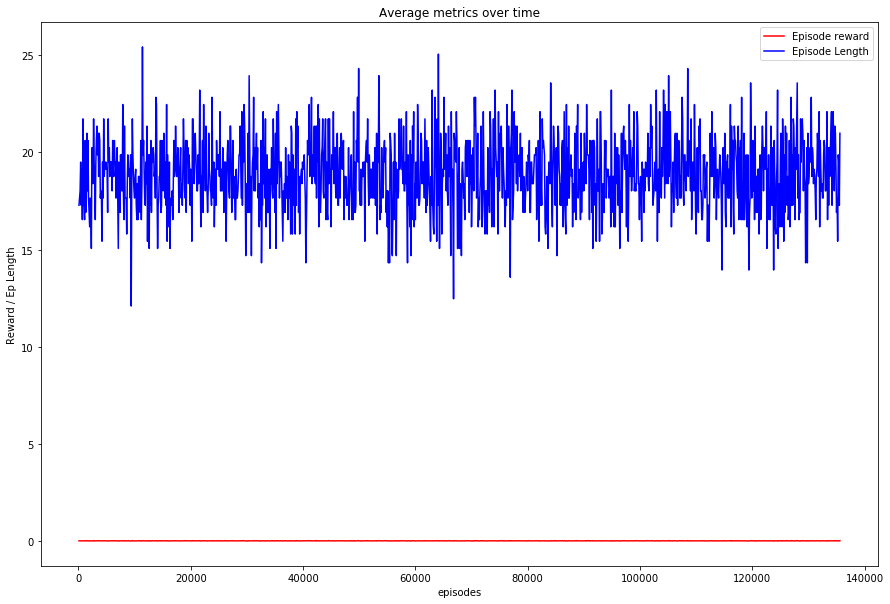

In [29]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

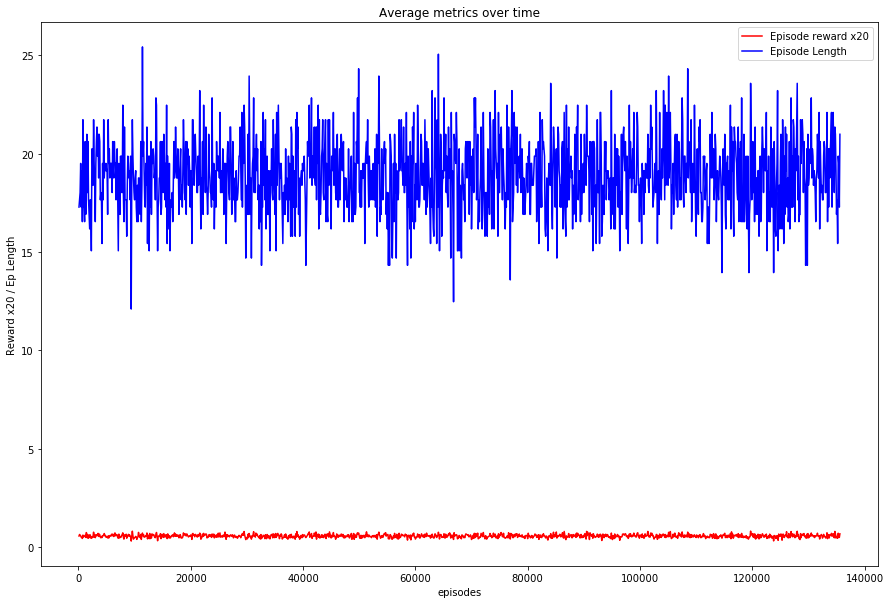

In [30]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

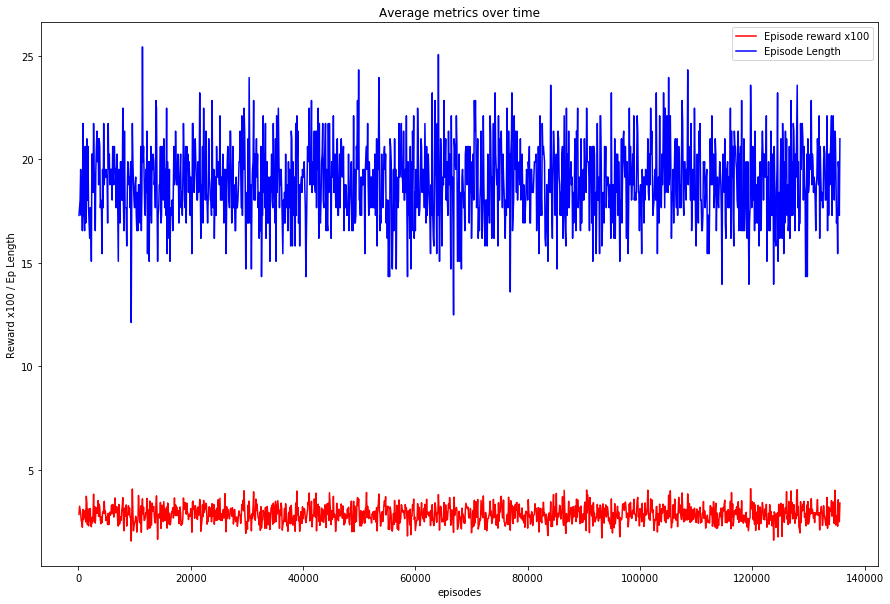

In [31]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

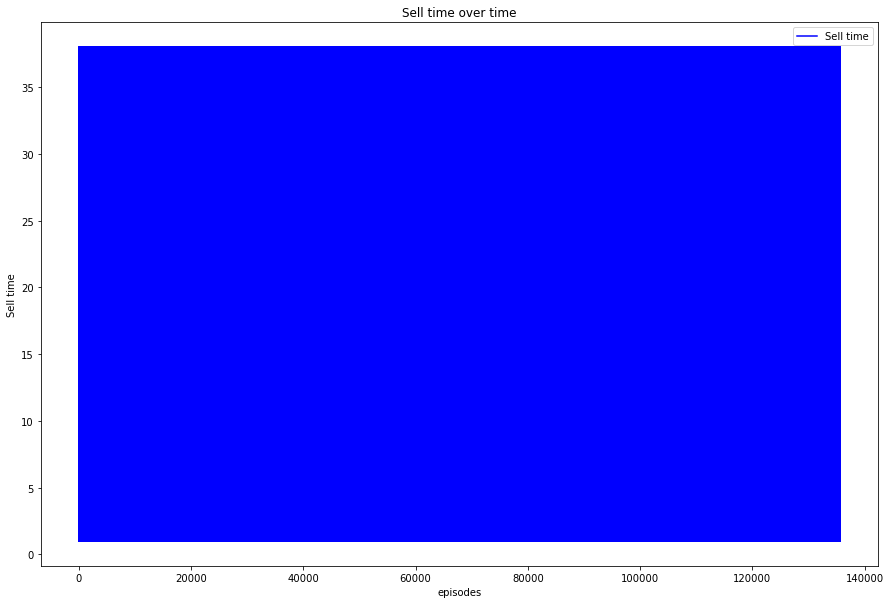

In [32]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select random day over history to sell [Benchmark]

In [33]:
env.reset_new_test() # reset to first observation in data
begin_time = time.time()

test = 'Random'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []
  

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MaxValue':
              if (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)
        
        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))   

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.02228535430190123	13.53
episode 200: 	0.025456525494057494	12.95
episode 300: 	0.024943553871876932	14.24
episode 400: 	0.024314221690474327	15.07
episode 500: 	0.02083542862943759	14.45
episode 600: 	0.02232142560006711	12.88
episode 700: 	0.021340317094202955	13.33
episode 800: 	0.024178434776497428	16.9
episode 900: 	0.020685930787200622	13.59
episode 1000: 	0.021817547139829294	14.35
episode 1100: 	0.025132592350445244	13.51
episode 1200: 	0.025552419953345087	15.51
episode 1300: 	0.020768630788414257	13.32
episode 1400: 	0.029262911014467013	13.93
episode 1500: 	0.021605116311602304	15.32
episode 1600: 	0.02078734432047233	14.54
episode 1700: 	0.029048685156200845	14.66
episode 1800: 	0.022091980871182103	14.45
episode 1900: 	0.026226814858047353	12.74
episode 2000: 	0.02396501202877946	15.68
episode 2100: 	0.02125666896461306	12.41
episode 2200: 	0.019949352318747397	13.12
episode 2300: 	0.021285782174632065	12.32
episode 2400: 	0.022373244550510502	14.81
episode 

In [34]:
# 4000 episodes
# Select random state over history [Benchmark]
#Average reward per episode: 0.0015505754102431175%
#Time to execute: 0.07682177225748697min

#23000 episodes
# Average reward per episode: 0.0012894304336377236%
#Time to execute: 0.40911168257395425min

#23000 episodes
#Average reward per episode: 0.002274329489706149%
#Time to execute: 0.6566788395245869min

#23000 episodes
#Average reward per episode: 0.001215791565711024%
#Time to execute: 0.36365593671798707min

# 23000 episodes
#Total average reward per episode: 0.00036678919435973405
#Time to execute: 0.4333968202273051min

# 23000 episodes
#Total average reward per episode: 0.0010562361629312214
#Time to execute: 0.6513438741366069min

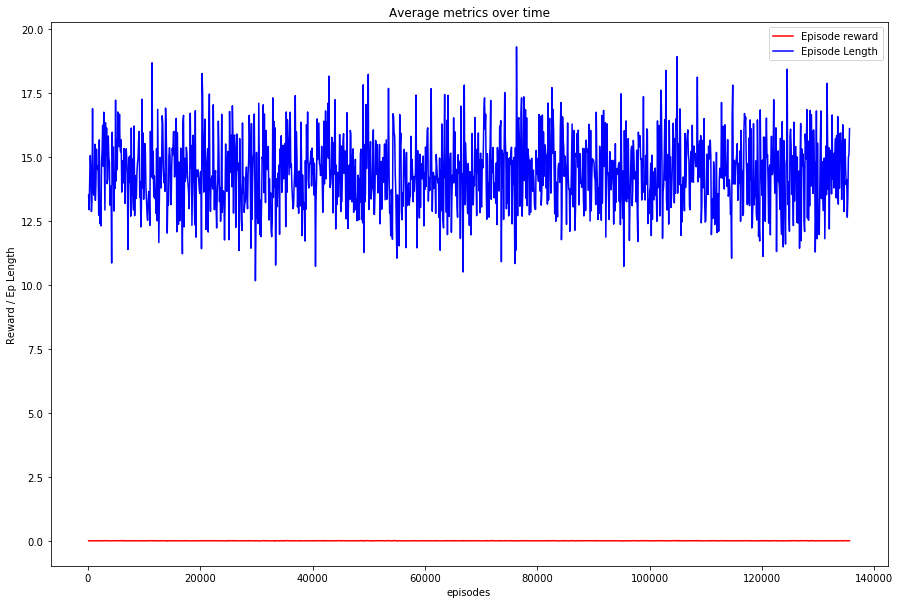

In [35]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

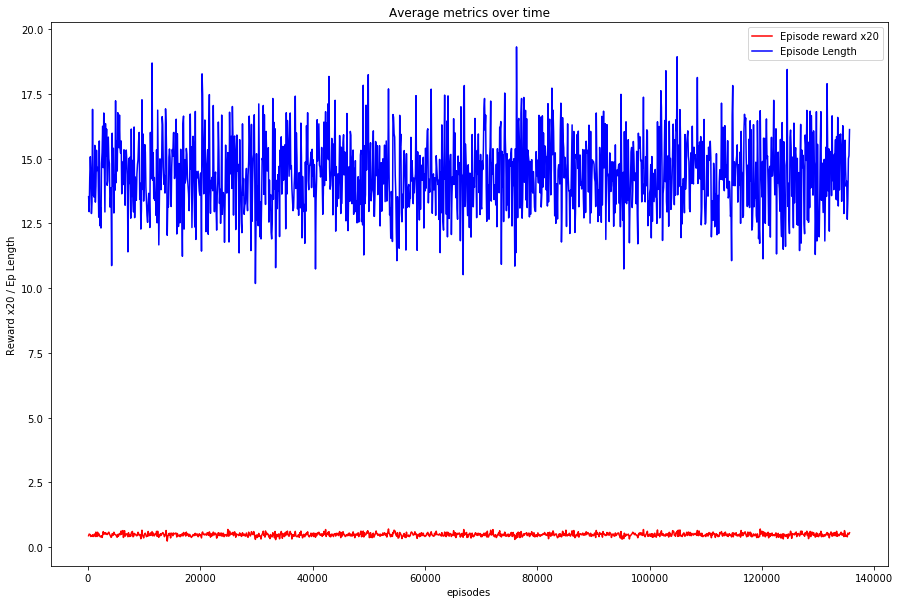

In [36]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

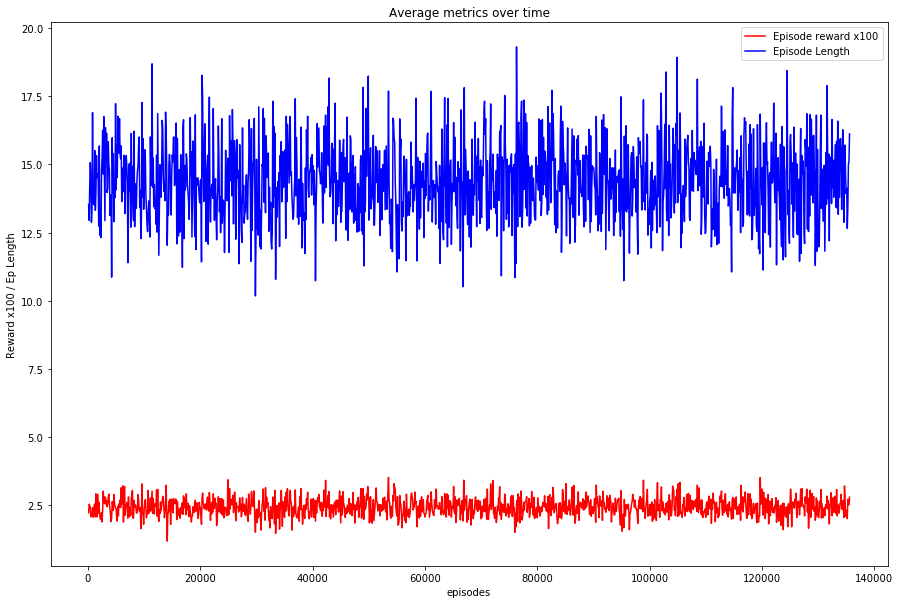

In [37]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

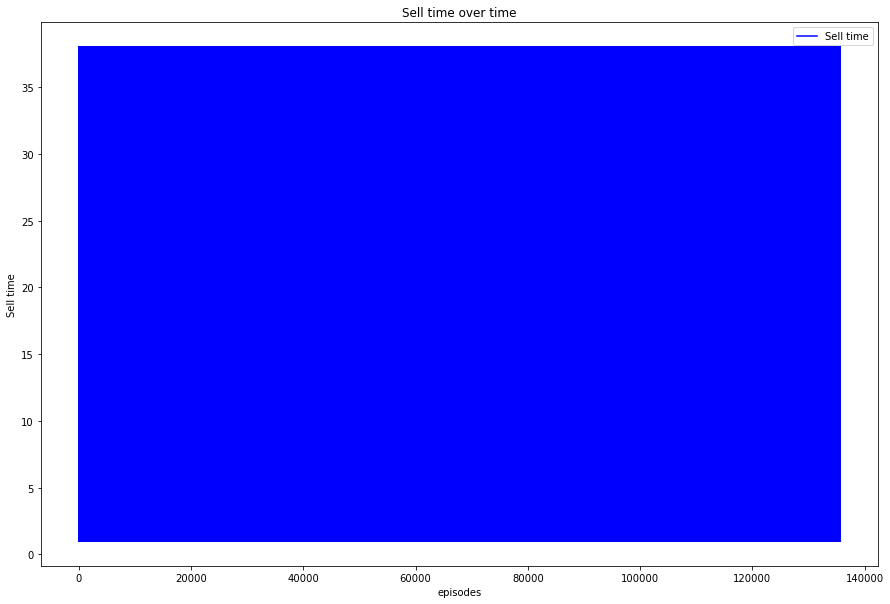

In [38]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select last day over history to sell [Benchmark]

In [39]:
env.reset_new_test() # reset to first observation in data
begin_time = time.time()

test = 'LastDay'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []  

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'LastDay':
          sell_time = max_epLength - 1  
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MaxValue':
              if (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random' or test == 'LastDay':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)

            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))   

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.02829052512123336	17.28
episode 200: 	0.03225282623942747	17.65
episode 300: 	0.03041197228129994	18.02
episode 400: 	0.028841550516983606	19.5
episode 500: 	0.025183750873674013	17.28
episode 600: 	0.02470869872464701	19.13
episode 700: 	0.02212261396768372	16.54
episode 800: 	0.030668332772927576	21.72
episode 900: 	0.025786813117301337	17.28
episode 1000: 	0.027473233528177807	17.28
episode 1100: 	0.02868600332689313	16.54
episode 1200: 	0.03020748843937822	20.61
episode 1300: 	0.024670189049270368	16.91
episode 1400: 	0.03708699042311691	17.65
episode 1500: 	0.033808398413777724	20.98
episode 1600: 	0.02342520566400298	18.02
episode 1700: 	0.03078742719227767	20.61
episode 1800: 	0.022767476276335574	17.65
episode 1900: 	0.03089781039690951	16.91
episode 2000: 	0.025255288703976964	16.17
episode 2100: 	0.03119490609933352	17.65
episode 2200: 	0.023411172115325698	17.28
episode 2300: 	0.022341337555549234	15.06
episode 2400: 	0.026841210230448383	20.24
episode 2500: 

In [40]:
# 4600 episodes
#Average reward per episode: 0.001350523388538691%
#Time to execute: 0.08548296292622884min

#23000 episodes
#Average reward per episode: 0.002919471458257028%
#Time to execute: 0.32947063048680625min

# 23000 episodes
#Total average reward per episode: 0.003380776061516078
#Time to execute: 0.36532406012217206min

# 23000 episodes
#Total average reward per episode: 0.002987836452606828
#Time to execute: 0.5932944019635519min

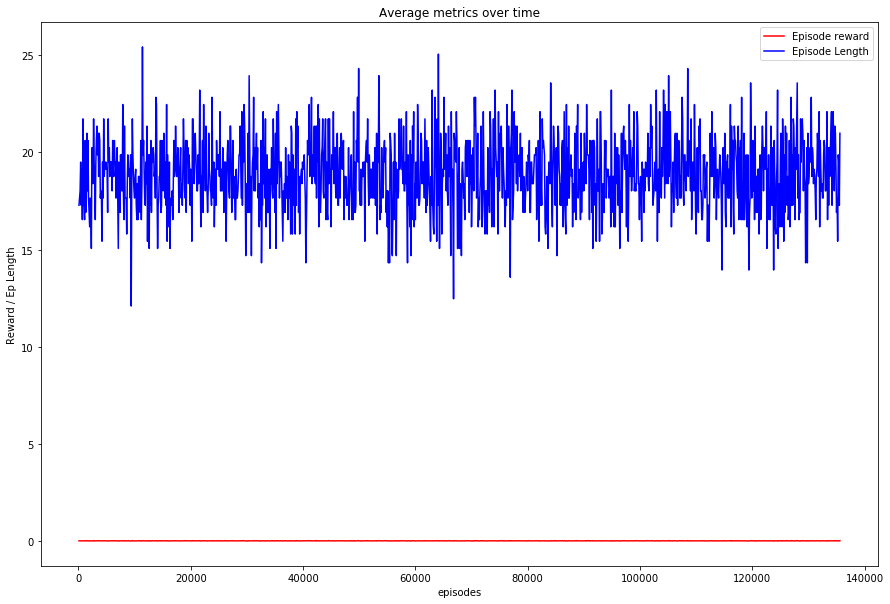

In [41]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

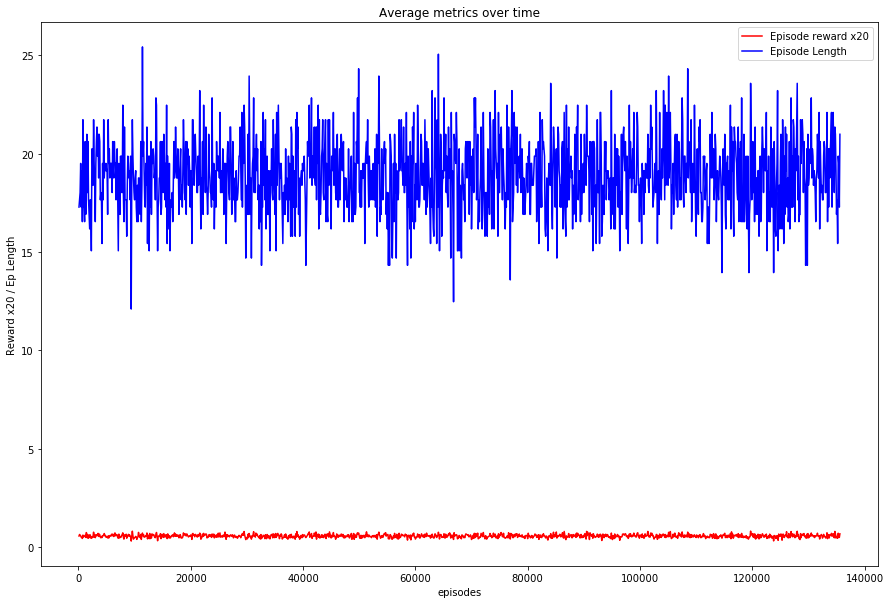

In [42]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

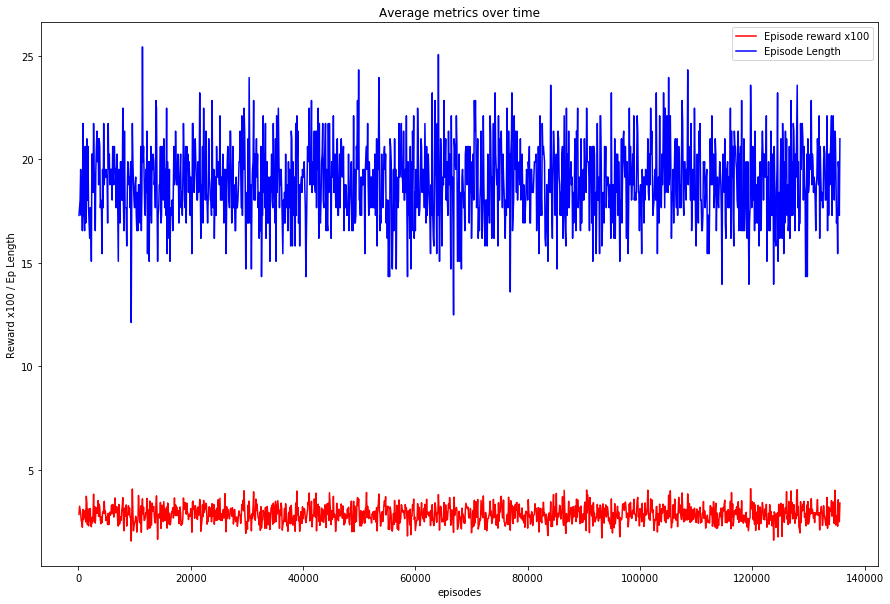

In [43]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

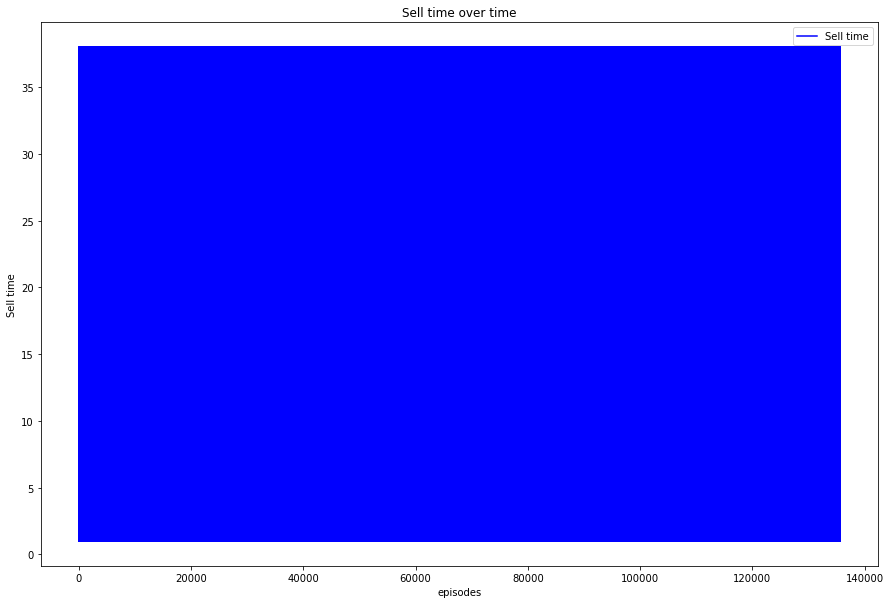

In [44]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select first day over history to sell [Benchmark]

In [45]:
env.reset_new_test() # reset to first observation in data
begin_time = time.time()

test = 'FirstDay'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = [] 

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'FirstDay':
          sell_time = build_warm_up_state_t 
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MaxValue':
              if (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random' or test == 'FirstDay':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)

            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))   

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.015743959153228435	7.29
episode 200: 	0.017124463344994928	5.44
episode 300: 	0.018652234114623138	8.77
episode 400: 	0.015636004527134047	8.4
episode 500: 	0.01279555833625959	8.03
episode 600: 	0.017824158445543616	10.99
episode 700: 	0.013520324666044354	7.66
episode 800: 	0.013199067605111508	9.14
episode 900: 	0.014335816139864843	8.4
episode 1000: 	0.018507332909244365	9.14
episode 1100: 	0.0145250196933445	6.55
episode 1200: 	0.015420928649122501	9.14
episode 1300: 	0.013477773743815607	7.66
episode 1400: 	0.023151063703619412	9.14
episode 1500: 	0.016399457506605104	9.51
episode 1600: 	0.01682550945626636	8.77
episode 1700: 	0.018709789643145583	9.14
episode 1800: 	0.012297443456677737	7.29
episode 1900: 	0.013768140987652173	6.55
episode 2000: 	0.01572215914204255	8.4
episode 2100: 	0.016437691098923218	6.92
episode 2200: 	0.013967426812606354	8.4
episode 2300: 	0.015576034025886436	8.03
episode 2400: 	0.017184220639994533	9.51
episode 2500: 	0.0163716259784636

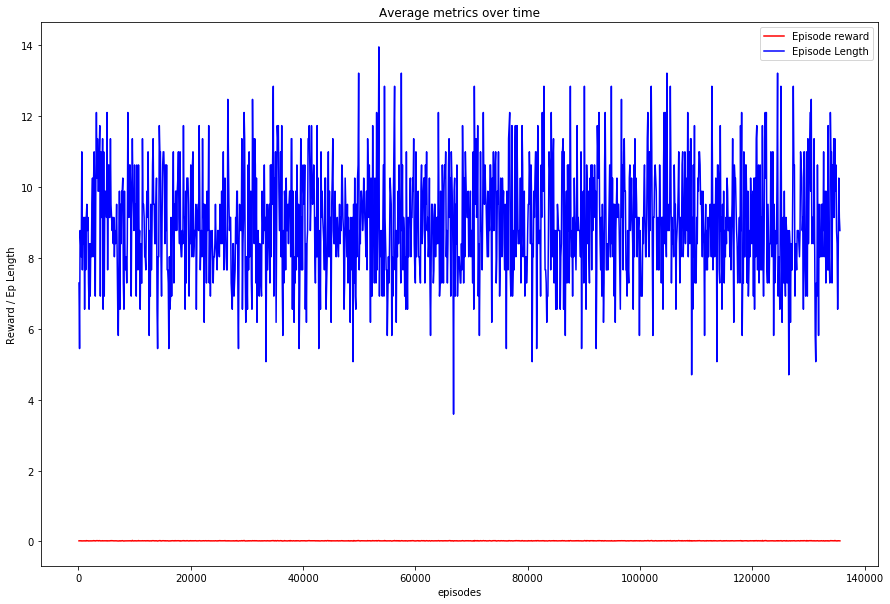

In [46]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

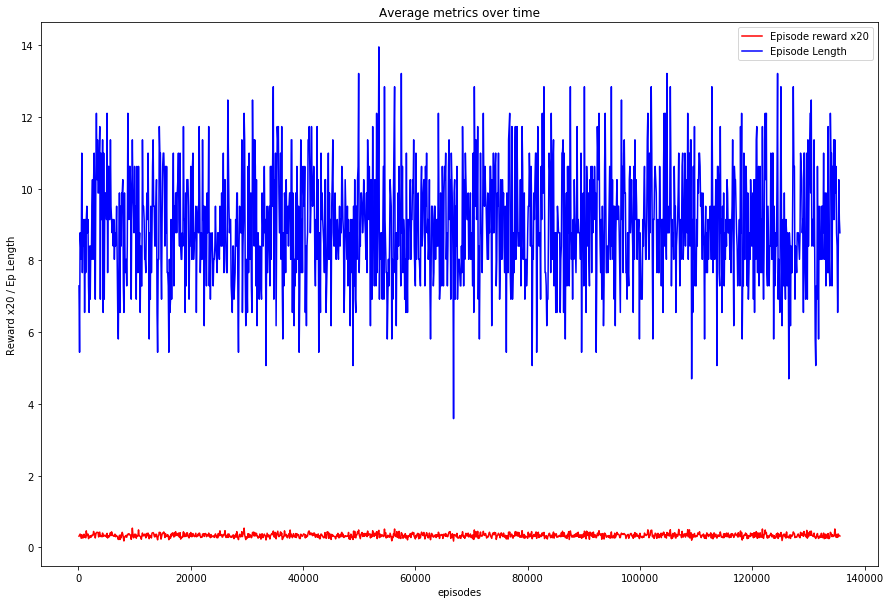

In [47]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

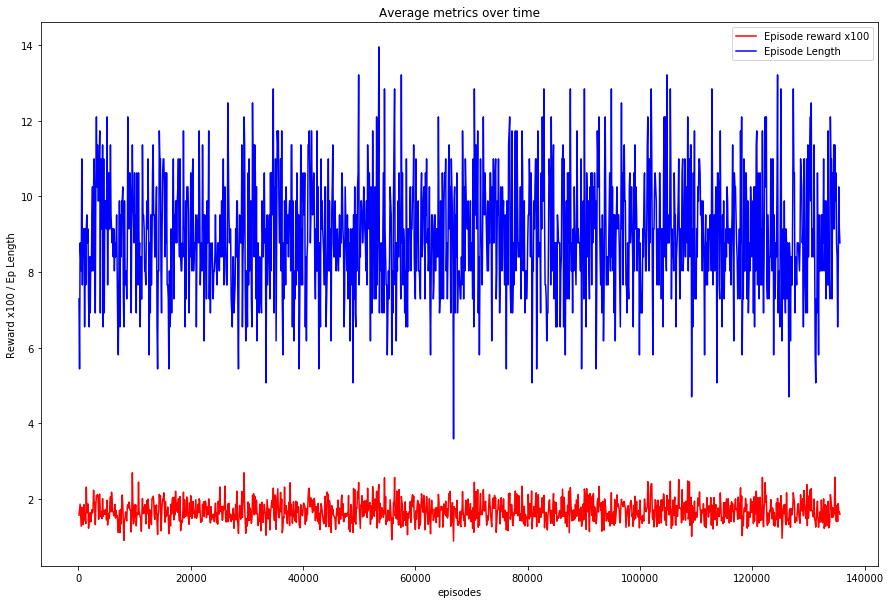

In [48]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

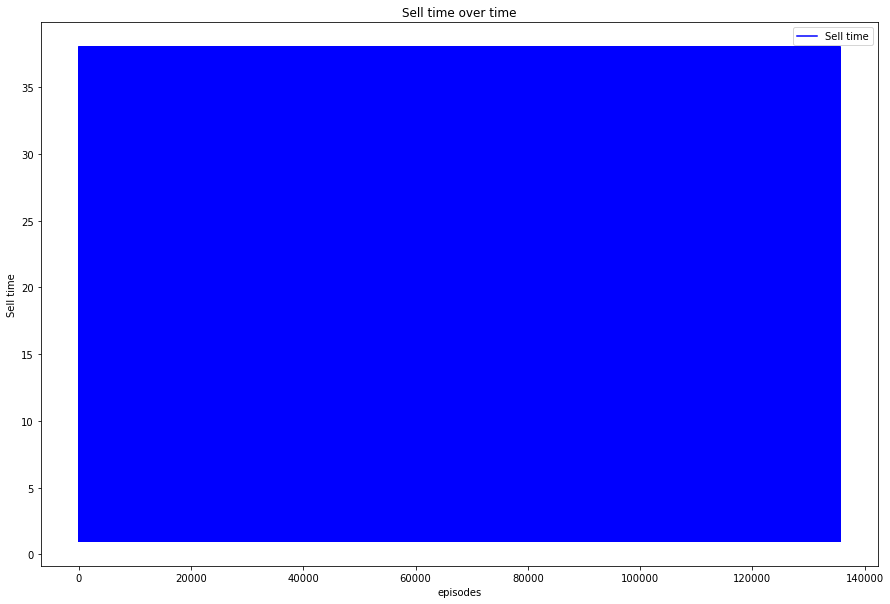

In [49]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

### Testing the network

In [50]:
#e = 0.03 #0.01 #The chance of chosing a random action
load_model = True #Whether to load a saved model.
is_training = False

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 187
num_episodes_per_epoch: 24000
min value of stock: 183.89506559405115, max value of stock: 225.71786417155334


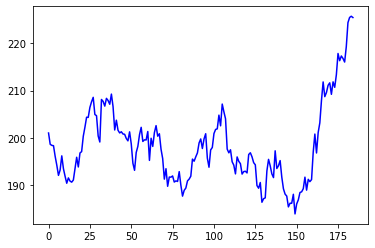

In [51]:
env = StockEnv(stocks_test_data, real_stocks_test_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
num_episodes = env.get_total_num_episodes_per_epoch()
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(test_data)) + ', max value of stock: '+str(max(test_data)))
plt.plot(range(len(test_data)), test_data, color='b')

In [52]:
begin_time = time.time()
tf.reset_default_graph()

mainQN = Qnetwork('main')
targetQN = Qnetwork('target')


init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=2)

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

#num_short_sell = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path) 
  

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    if load_model == True:
        print ('Loading Model...')
        #ckpt = tf.train.get_checkpoint_state(path)
        #saver.restore(sess,ckpt.model_checkpoint_path)
        saver.restore(sess,final_trained_model_name)
    else:
        sess.run(init)
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        #Reset the recurrent layer's hidden state
        state = np.zeros((num_layers, 2, 1, h_size))
        while j < max_epLength: 

            if j == max_epLength - 1 and env.is_episode_finished() == False:
                a = 1
            else:
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                        feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,\
                                   mainQN.state_in:state,mainQN.batch_size:1,\
                                   mainQN.num_quantiles:num_quantile_samples,\
                                   mainQN.quantiles_shape:num_quantile_samples})
                if env.get_time() < build_warm_up_state_t:
                    a = 0 #hold
                elif env.get_payoff() <= 0:
                    a = 0 #hold
                    #num_short_sell += 1
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            state = state1
            j+=1 # episode length till selling or reaching last day of option

            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
            
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Number of short selling: " + str(num_short_sell))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

Loading Model...
INFO:tensorflow:Restoring parameters from /misc/scratch05/patx/fathanab/Experiments_RL/normalizeFirstDay_seed_corrected_2019_11_21_shuffled_GBM_version/savedModel/IQN_200noSoft_00005_1000freq_128batch_dropout_arch0-option_T50-history_t15-softUpdateFalse-tau0.001-huber_lossTrue-freq1000-batch128-capacity10000-lambda5e-05-final
episode 100: 	0.022498884161430067	13.95
episode 200: 	0.027206744557261894	14.79
episode 300: 	0.02685724913144295	12.57
episode 400: 	0.0261309552466639	14.89
episode 500: 	0.030651804224278826	16.49
episode 600: 	0.02841103258433439	15.64
episode 700: 	0.032311578215612646	17.46
episode 800: 	0.022691637815928926	13.91
episode 900: 	0.030536079181209253	15.42
episode 1000: 	0.02749359277284813	15.26
episode 1100: 	0.024542150701186167	13.73
episode 1200: 	0.028785694718064567	13.44
episode 1300: 	0.022888420428309963	13.4
episode 1400: 	0.021949720958108595	13.26
episode 1500: 	0.03142252605798418	14.23
episode 1600: 	0.033269651469644015	14.53

In [53]:
# Normal Test
# 4000 episodes
#Average reward per episode: -0.0004459820152409164%
#Time to execute: 1.0273285110791524min

# 10000 episodes of training (23000 episodes)
#Average reward per episode: -0.0006903839079534307%
#Time to execute: 18.210397080580393min

# 30000 episodes of training (23000 episodes)
#Average reward per episode: -0.0015529333479744412%
#Time to execute: 27.645483565330505min

# 20000 episodes of training
#Average reward per episode: -0.0049713977980137885%
#Time to execute: 31.664522131284077min

# 100000 episodes of training # architecture 0
#Total average reward per episode: -0.0031459276190924593
#Time to execute: 27.598839151859284min

#20000 episodes training
#Total average reward per episode: 0.0024760915583103395
#Time to execute: 2.219494903087616min

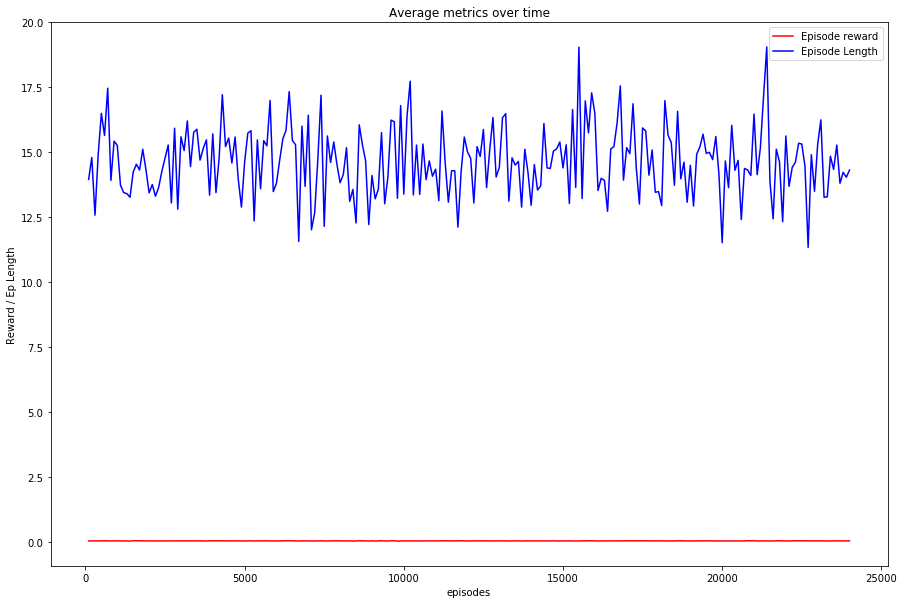

In [54]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

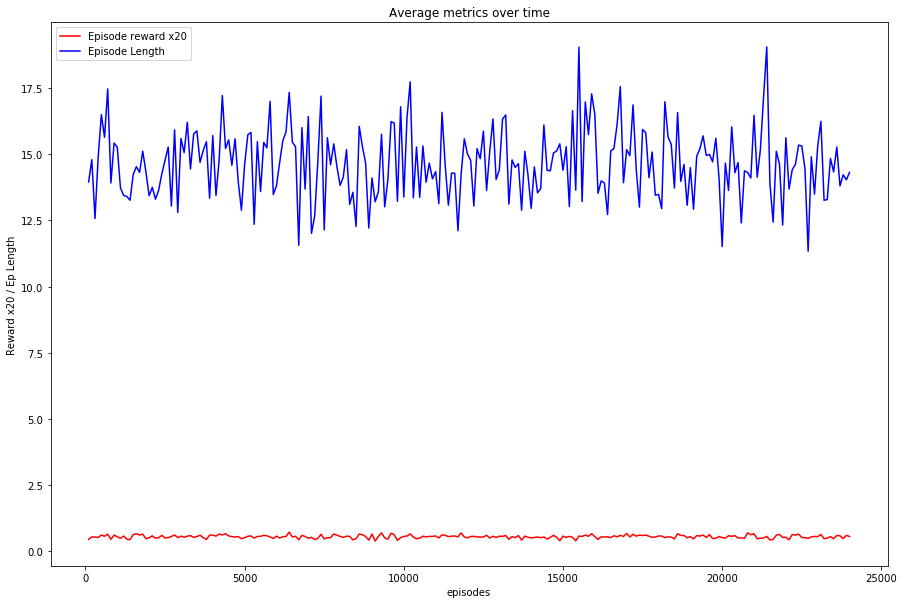

In [55]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

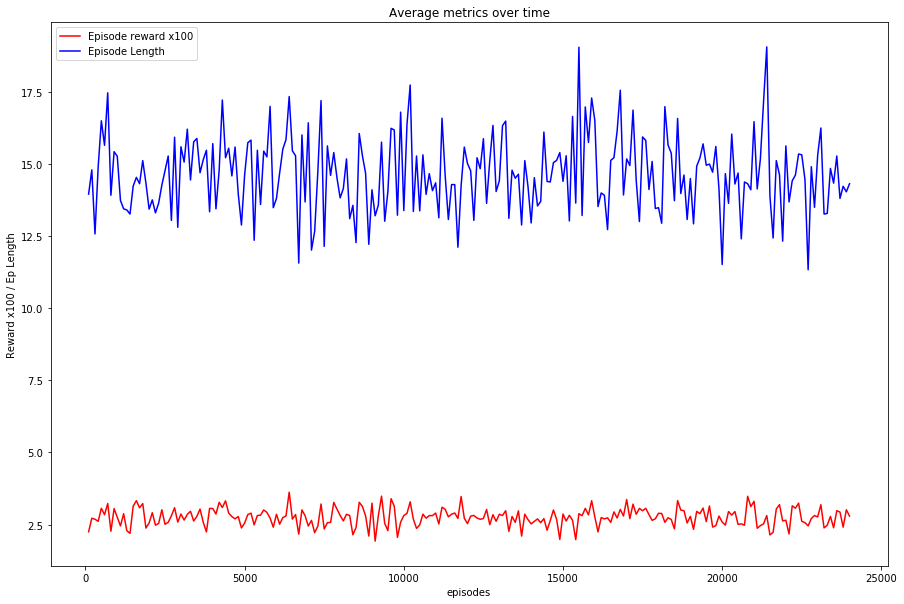

In [56]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

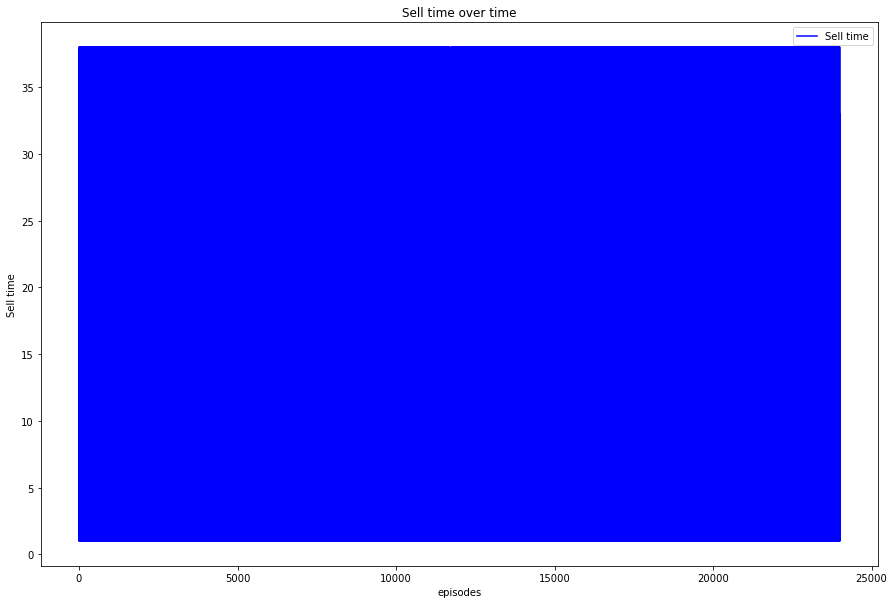

In [57]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select day of Min price over history [Benchmark]

In [58]:
env.reset_new_test() # reset to first observation in data
begin_time = time.time()

test = 'MinValue' #'Random'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []
  

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'MinValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MinValue':
              if env.get_time() >= build_warm_up_state_t and (s[-1] <= min(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break

        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.026221007580406987	16.17
episode 200: 	0.02761500867984468	18.39
episode 300: 	0.03004228328108191	17.28
episode 400: 	0.029231731722639456	19.13
episode 500: 	0.02538201177538868	20.61
episode 600: 	0.029486302945907976	19.5
episode 700: 	0.0341037250792363	21.35
episode 800: 	0.023413715875285703	16.91
episode 900: 	0.02977045687538082	20.24
episode 1000: 	0.025605071647911686	19.13
episode 1100: 	0.024942763907450618	16.91
episode 1200: 	0.028211546301342715	18.39
episode 1300: 	0.023751203999850392	16.91
episode 1400: 	0.021494323838889252	15.06
episode 1500: 	0.028721248602870147	19.5
episode 1600: 	0.02820122293318343	18.76
episode 1700: 	0.029229799863788535	18.76
episode 1800: 	0.028237029000265704	19.13
episode 1900: 	0.023121546293210112	17.65
episode 2000: 	0.026901016491695316	16.91
episode 2100: 	0.027901108556103137	18.39
episode 2200: 	0.02637037629457613	16.91
episode 2300: 	0.026596022956649125	17.28
episode 2400: 	0.02920484266212446	18.39
episode 2500

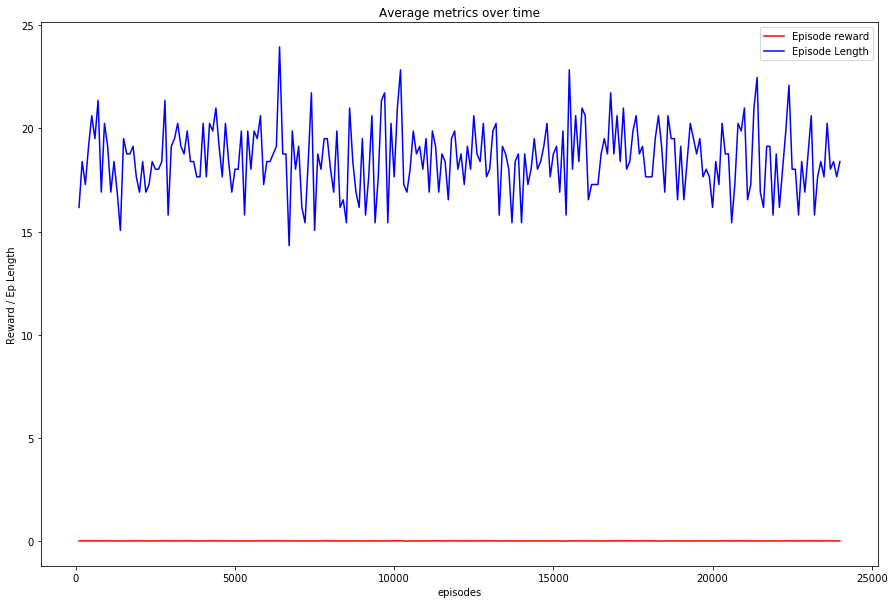

In [59]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

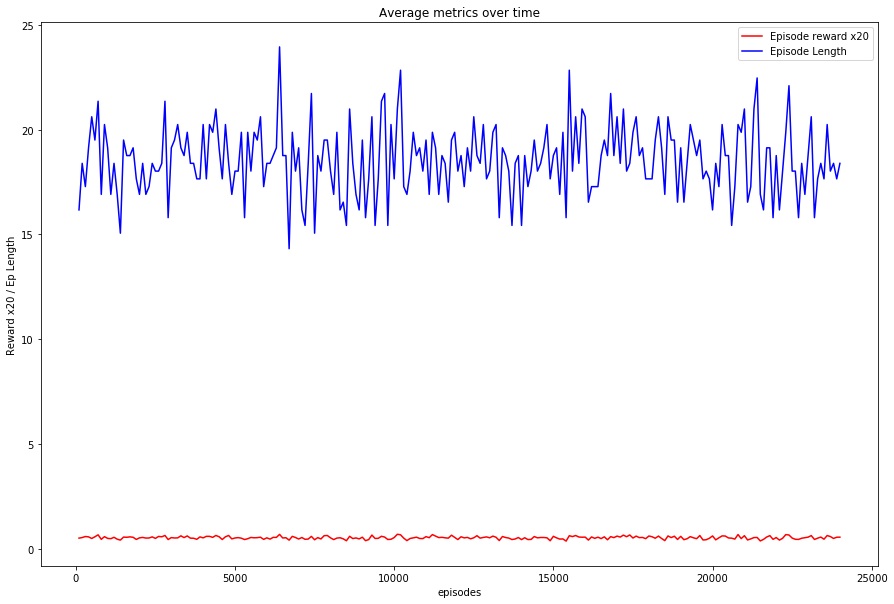

In [60]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

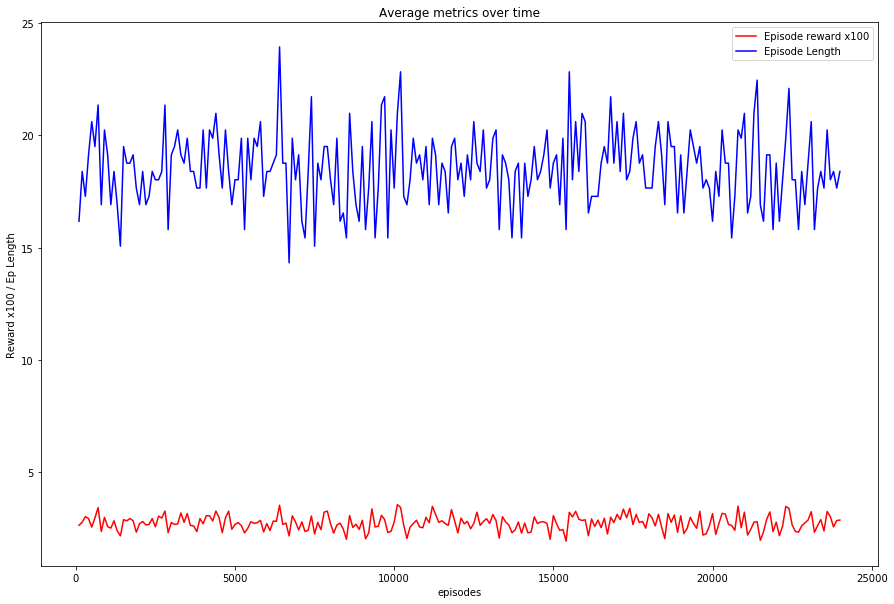

In [61]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

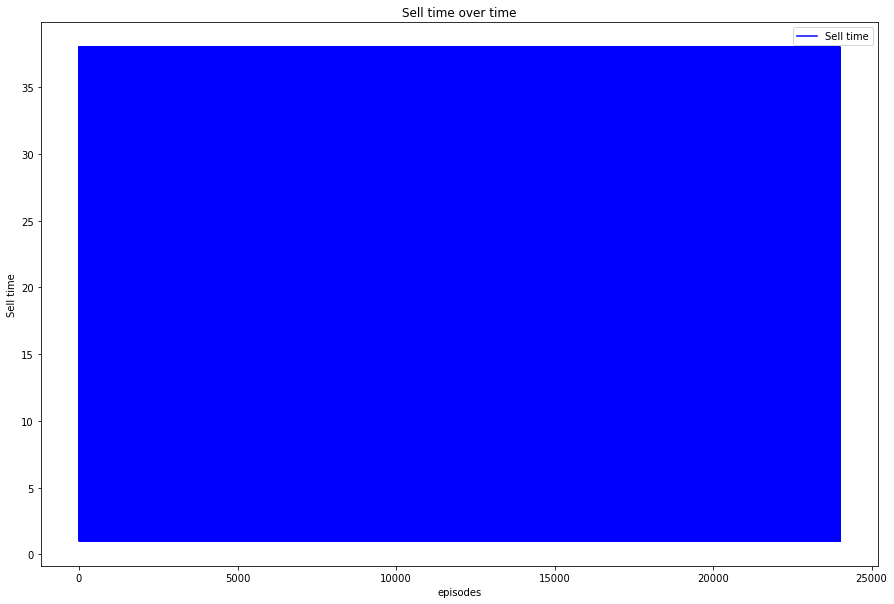

In [62]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select day of Max price over history [Benchmark]

In [63]:
env.reset_new_test() # reset to first observation in data
begin_time = time.time()

test = 'MaxValue' #'Random'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []
  

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MaxValue':
              if env.get_time() >= build_warm_up_state_t and (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break

        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.026221007580406987	16.17
episode 200: 	0.02761500867984468	18.39
episode 300: 	0.03004228328108191	17.28
episode 400: 	0.029231731722639456	19.13
episode 500: 	0.02538201177538868	20.61
episode 600: 	0.029486302945907976	19.5
episode 700: 	0.0341037250792363	21.35
episode 800: 	0.023413715875285703	16.91
episode 900: 	0.02977045687538082	20.24
episode 1000: 	0.025605071647911686	19.13
episode 1100: 	0.024942763907450618	16.91
episode 1200: 	0.028211546301342715	18.39
episode 1300: 	0.023751203999850392	16.91
episode 1400: 	0.021494323838889252	15.06
episode 1500: 	0.028721248602870147	19.5
episode 1600: 	0.02820122293318343	18.76
episode 1700: 	0.029229799863788535	18.76
episode 1800: 	0.028237029000265704	19.13
episode 1900: 	0.023121546293210112	17.65
episode 2000: 	0.026901016491695316	16.91
episode 2100: 	0.027901108556103137	18.39
episode 2200: 	0.02637037629457613	16.91
episode 2300: 	0.026596022956649125	17.28
episode 2400: 	0.02920484266212446	18.39
episode 2500

In [64]:
# 4000 episodes
# Select state of Max price over history [Benchmark]
#Average reward per episode: 0.0005877807673596729%
#Time to execute: 0.09947771628697713min

# 10000 episodes of training
#Average reward per episode: 0.0004938414456624297%
#Time to execute: 0.5947879354159037min

# 23000 episodes of training
#Average reward per episode: 0.0005705326210584273%
#Time to execute: 0.8882605234781901min

# 23000 episodes
#Average reward per episode: 0.0010192164676906157%
#Time to execute: 0.5056182742118835min

# 23000 episodes
#Total average reward per episode: 0.0009947041707927247
#Time to execute: 0.6030449350674947min

# 23000 episodes
#Total average reward per episode: 0.0009401450698119521
#Time to execute: 0.9448242465655009min

# 23000 episodes
#Total average reward per episode: 0.0003986495802468716
#Time to execute: 0.5700281739234925min

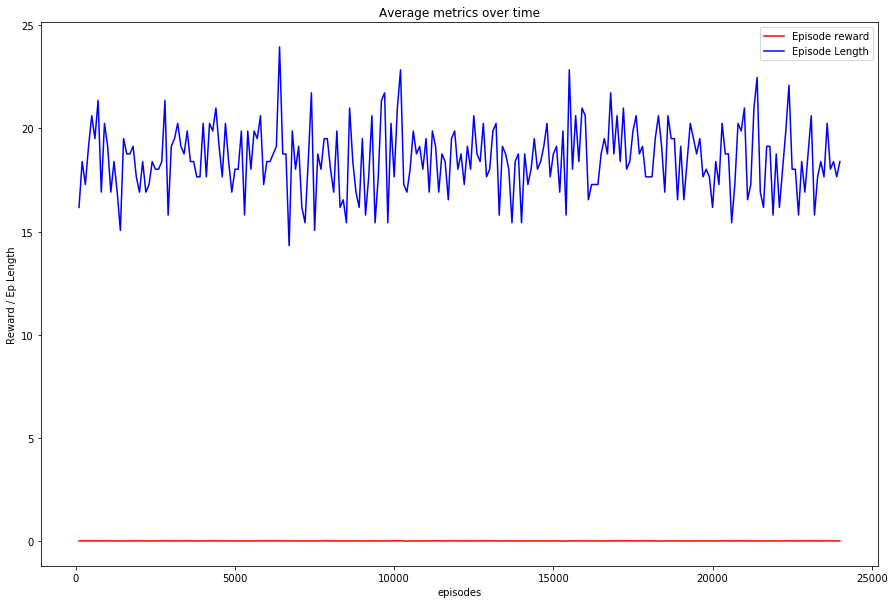

In [65]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

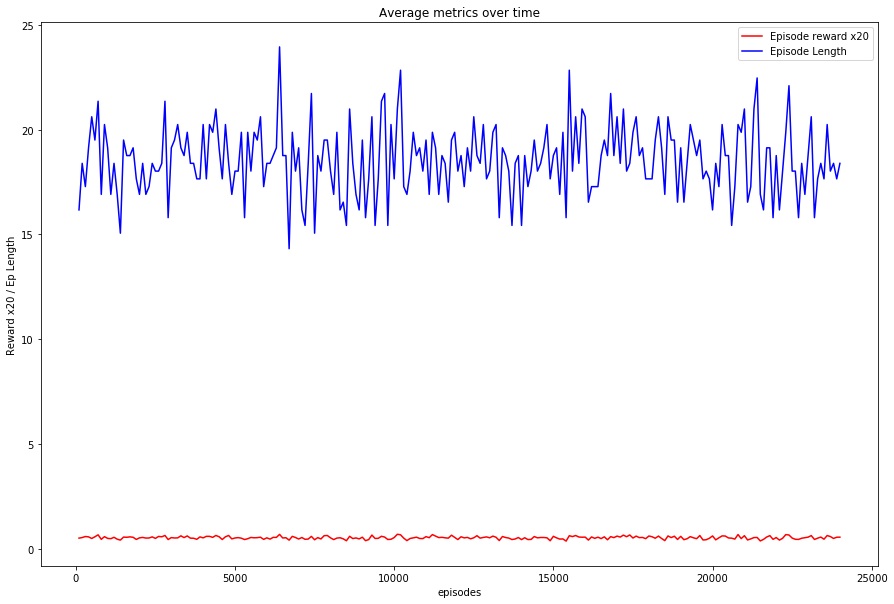

In [66]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

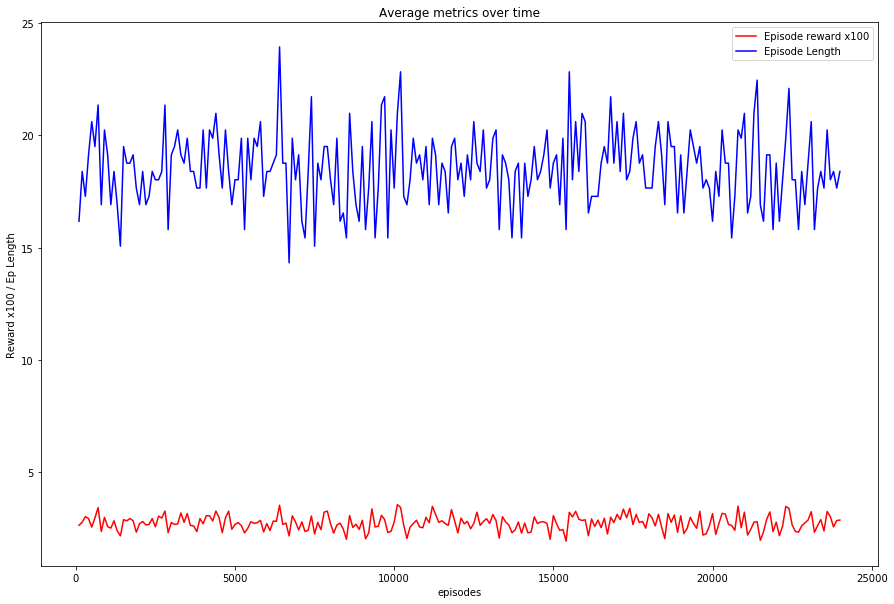

In [67]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

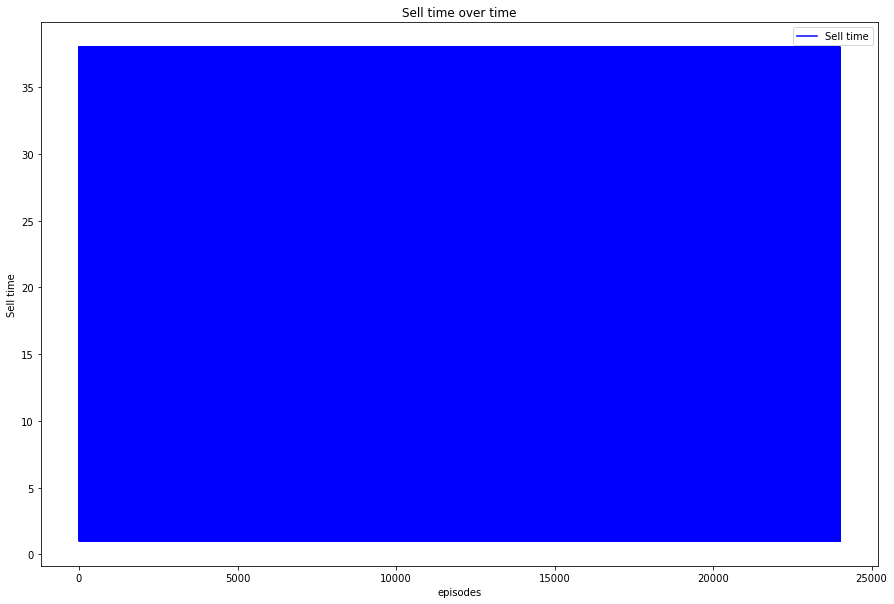

In [68]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select random day over history to sell [Benchmark]

In [69]:
env.reset_new_test() # reset to first observation in data
begin_time = time.time()

test = 'Random'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []
  

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MaxValue':
              if (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)
        
        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))   

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.023014818140886767	13.82
episode 200: 	0.021412950349552245	13.2
episode 300: 	0.02666743215904802	13.23
episode 400: 	0.026912946134187123	14.12
episode 500: 	0.02637692093883439	15.5
episode 600: 	0.022726931866665256	14.41
episode 700: 	0.026233448302223045	15.16
episode 800: 	0.019998911696091835	13.19
episode 900: 	0.02317427621009267	15.63
episode 1000: 	0.024487525277095	13.77
episode 1100: 	0.020221546835468143	13.43
episode 1200: 	0.024830912682872373	14.1
episode 1300: 	0.0246599277804718	14.9
episode 1400: 	0.016727313427742224	10.58
episode 1500: 	0.02555901643749789	16.24
episode 1600: 	0.02618233111633046	14.74
episode 1700: 	0.027190123362375376	13.53
episode 1800: 	0.027932298411144228	15.89
episode 1900: 	0.02210520377113429	14.59
episode 2000: 	0.02280253080150382	13.59
episode 2100: 	0.02066491099505179	13.67
episode 2200: 	0.020019475291105898	12.35
episode 2300: 	0.024477544894182923	14.07
episode 2400: 	0.025654490813187127	14.43
episode 2500: 	0.0

In [70]:
# 4000 episodes
# Select random state over history [Benchmark]
#Average reward per episode: 0.0015505754102431175%
#Time to execute: 0.07682177225748697min

#23000 episodes
# Average reward per episode: 0.0012894304336377236%
#Time to execute: 0.40911168257395425min

#23000 episodes
#Average reward per episode: 0.002274329489706149%
#Time to execute: 0.6566788395245869min

#23000 episodes
#Average reward per episode: 0.001215791565711024%
#Time to execute: 0.36365593671798707min

# 23000 episodes
#Total average reward per episode: 0.00036678919435973405
#Time to execute: 0.4333968202273051min

# 23000 episodes
#Total average reward per episode: 0.0010562361629312214
#Time to execute: 0.6513438741366069min

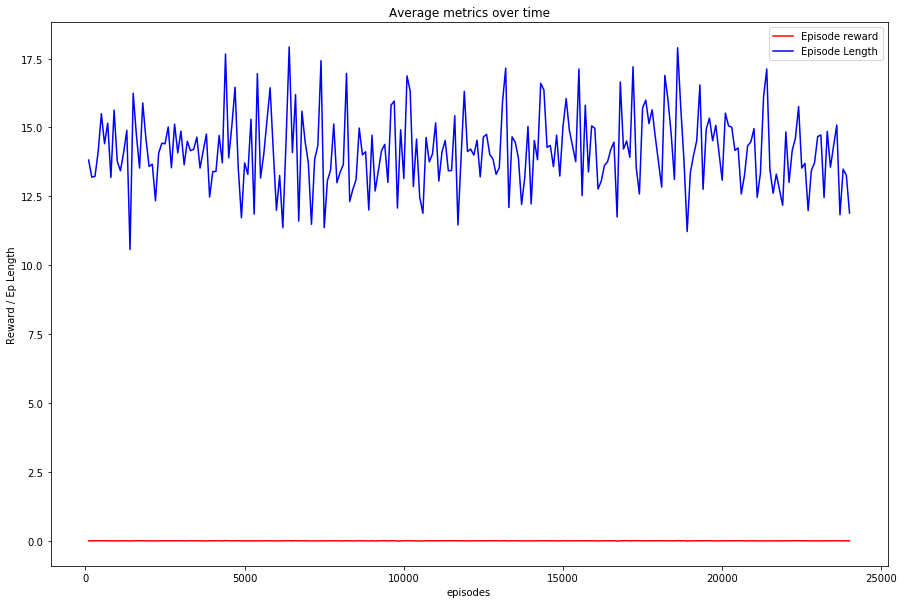

In [71]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

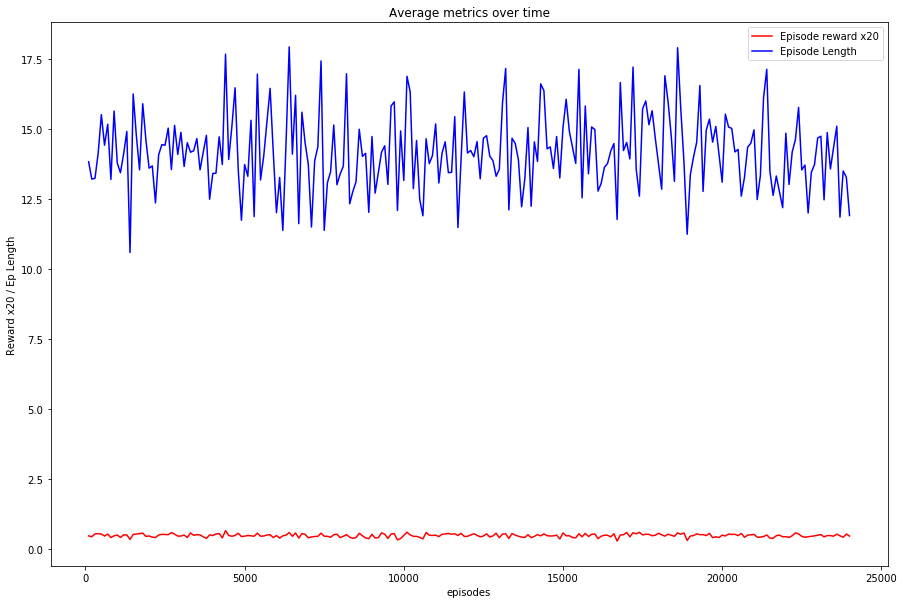

In [72]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

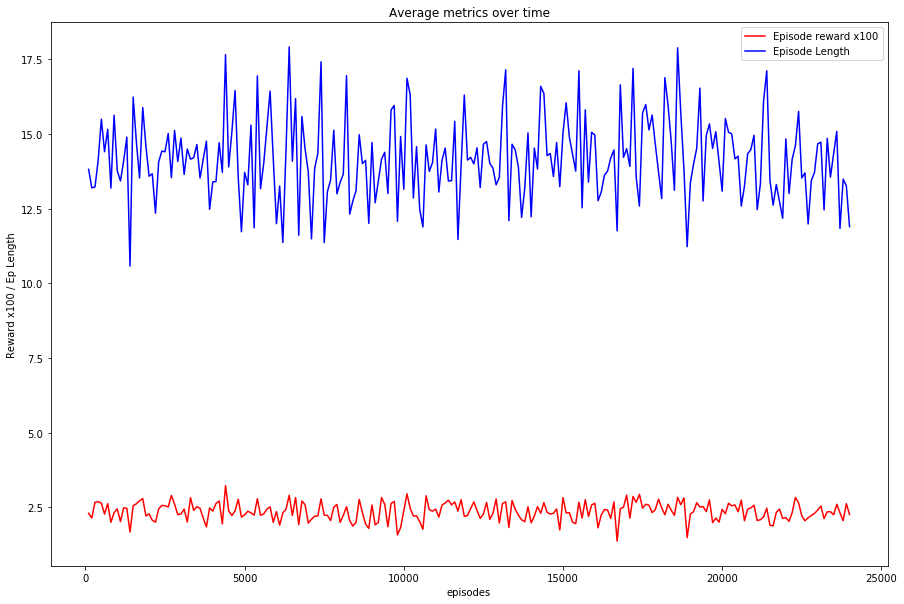

In [73]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

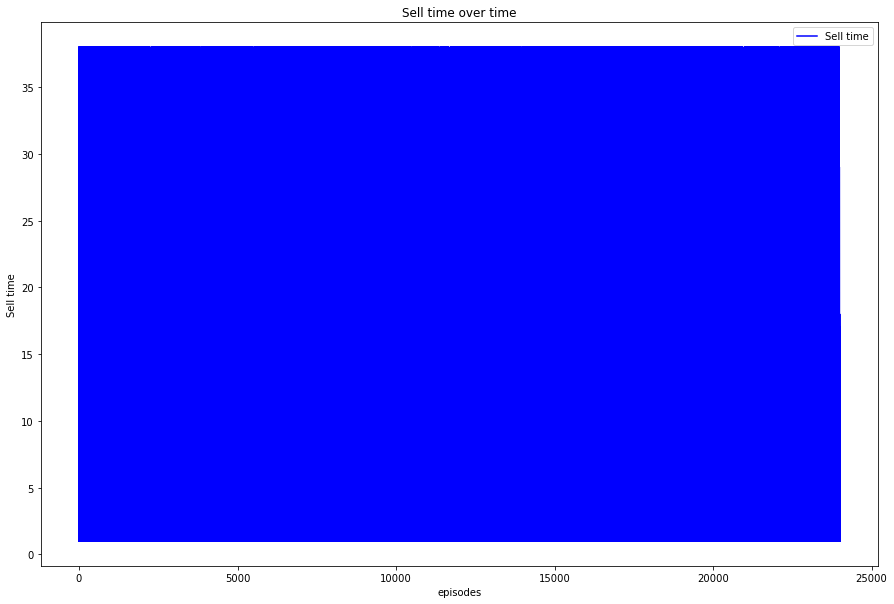

In [74]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select last day over history to sell [Benchmark]

In [75]:
env.reset_new_test() # reset to first observation in data
begin_time = time.time()

test = 'LastDay'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []  

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'LastDay':
          sell_time = max_epLength - 1  
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MaxValue':
              if (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random' or test == 'LastDay':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)

            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))   

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.026221007580406987	16.17
episode 200: 	0.02761500867984468	18.39
episode 300: 	0.03004228328108191	17.28
episode 400: 	0.029231731722639456	19.13
episode 500: 	0.02538201177538868	20.61
episode 600: 	0.029486302945907976	19.5
episode 700: 	0.0341037250792363	21.35
episode 800: 	0.023413715875285703	16.91
episode 900: 	0.02977045687538082	20.24
episode 1000: 	0.025605071647911686	19.13
episode 1100: 	0.024942763907450618	16.91
episode 1200: 	0.028211546301342715	18.39
episode 1300: 	0.023751203999850392	16.91
episode 1400: 	0.021494323838889252	15.06
episode 1500: 	0.028721248602870147	19.5
episode 1600: 	0.02820122293318343	18.76
episode 1700: 	0.029229799863788535	18.76
episode 1800: 	0.028237029000265704	19.13
episode 1900: 	0.023121546293210112	17.65
episode 2000: 	0.026901016491695316	16.91
episode 2100: 	0.027901108556103137	18.39
episode 2200: 	0.02637037629457613	16.91
episode 2300: 	0.026596022956649125	17.28
episode 2400: 	0.02920484266212446	18.39
episode 2500

In [76]:
# 4600 episodes
#Average reward per episode: 0.001350523388538691%
#Time to execute: 0.08548296292622884min

#23000 episodes
#Average reward per episode: 0.002919471458257028%
#Time to execute: 0.32947063048680625min

# 23000 episodes
#Total average reward per episode: 0.003380776061516078
#Time to execute: 0.36532406012217206min

# 23000 episodes
#Total average reward per episode: 0.002987836452606828
#Time to execute: 0.5932944019635519min

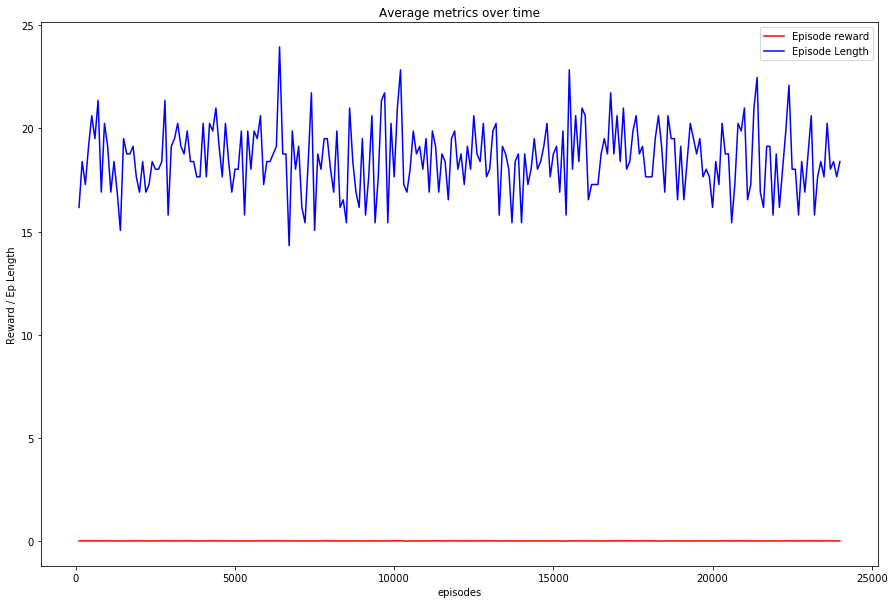

In [77]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

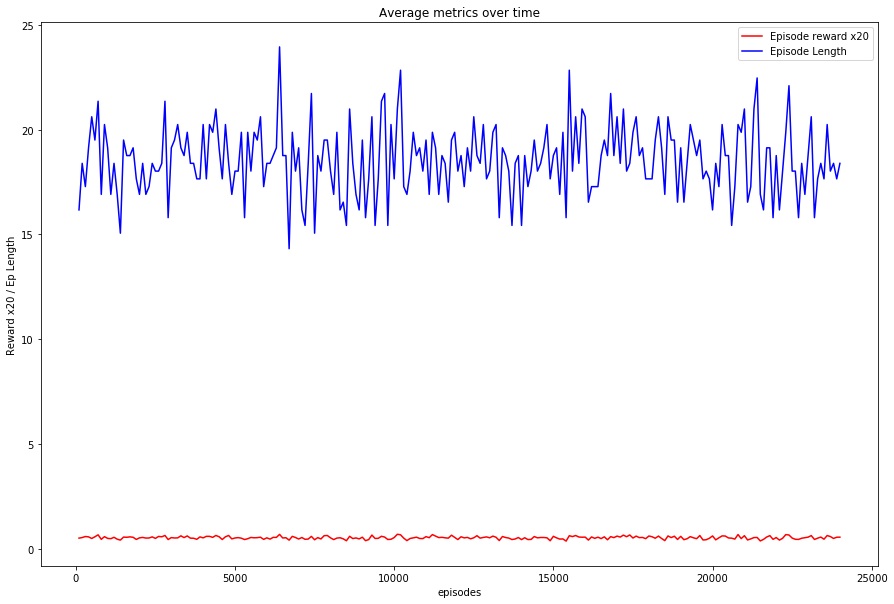

In [78]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

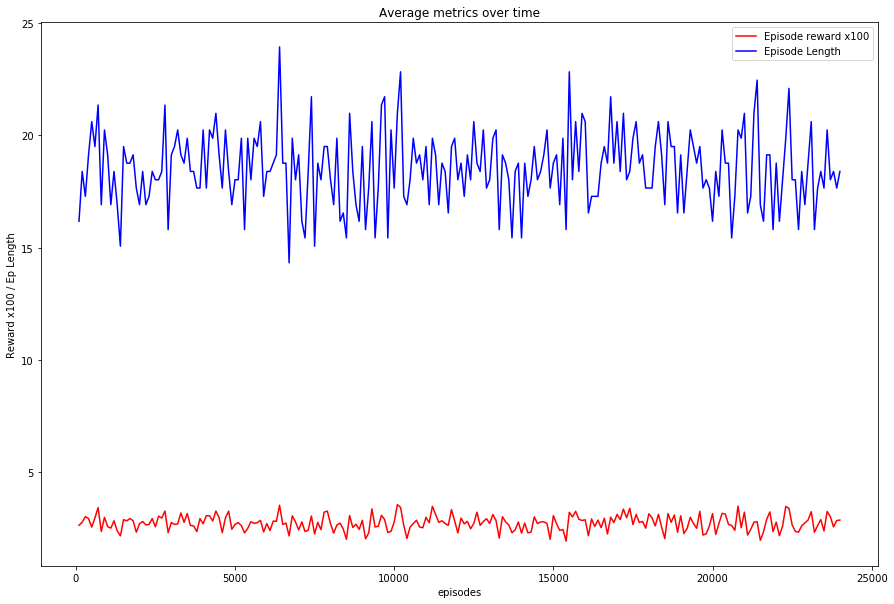

In [79]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

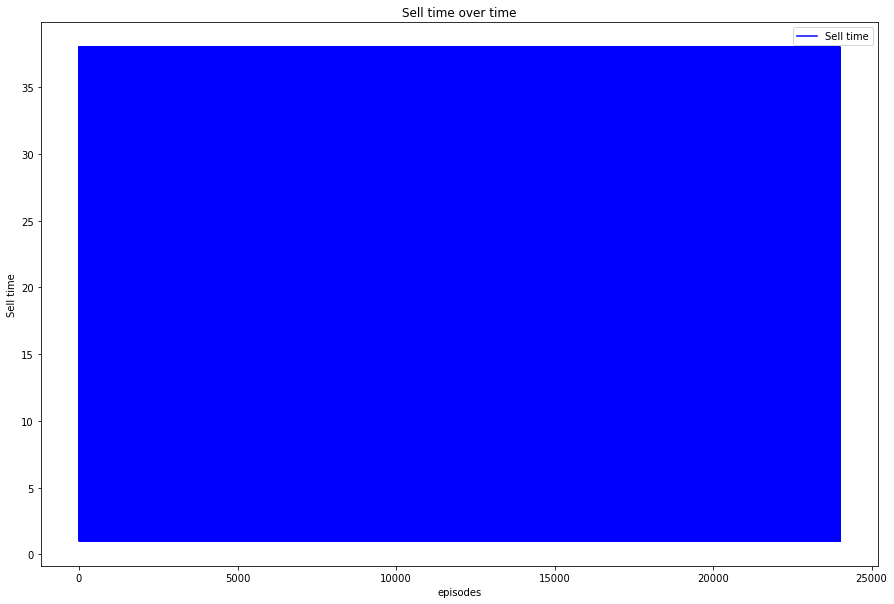

In [80]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select first day over history to sell [Benchmark]

In [81]:
env.reset_new_test() # reset to first observation in data
begin_time = time.time()

test = 'FirstDay'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = [] 

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'FirstDay':
          sell_time = build_warm_up_state_t 
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MaxValue':
              if (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random' or test == 'FirstDay':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)

            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))   

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.01674950068859316	7.66
episode 200: 	0.015426025055541612	8.4
episode 300: 	0.015794173524464786	7.29
episode 400: 	0.017518354763664173	9.88
episode 500: 	0.014577894058960775	7.66
episode 600: 	0.016289691860747735	9.88
episode 700: 	0.0179672485995675	11.36
episode 800: 	0.012240503989644042	8.03
episode 900: 	0.015325627030828591	9.14
episode 1000: 	0.014477229507460238	8.4
episode 1100: 	0.01561305208916019	8.03
episode 1200: 	0.011284889279413004	6.92
episode 1300: 	0.012291173383285465	7.29
episode 1400: 	0.013419593214595231	8.03
episode 1500: 	0.016390474865606443	6.55
episode 1600: 	0.01664810232481897	8.77
episode 1700: 	0.02036965219904171	11.36
episode 1800: 	0.02184494705684724	10.99
episode 1900: 	0.015132917443288771	8.4
episode 2000: 	0.01966331916900015	10.25
episode 2100: 	0.018112462512146335	8.77
episode 2200: 	0.014809106375070203	8.77
episode 2300: 	0.017684589630508115	8.4
episode 2400: 	0.020925819347806192	10.99
episode 2500: 	0.017456347233036

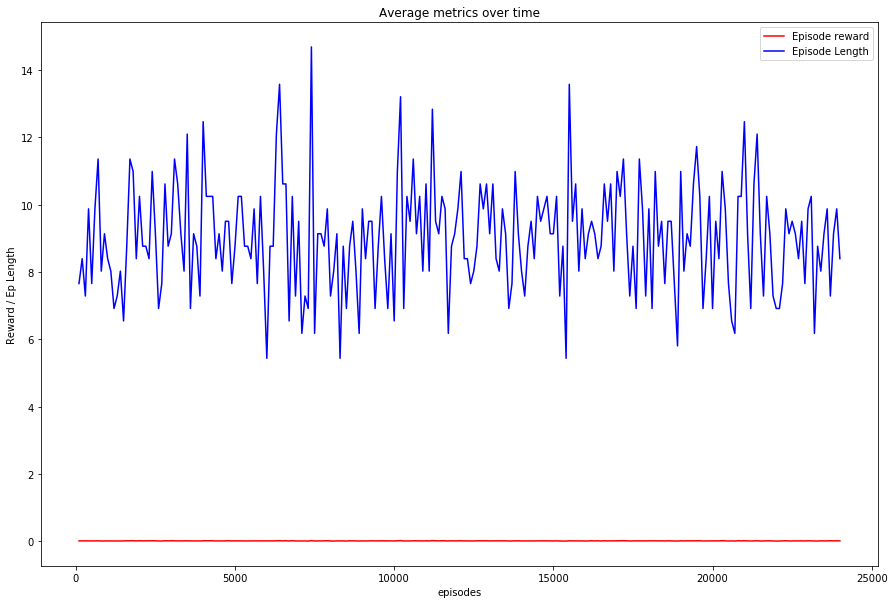

In [82]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

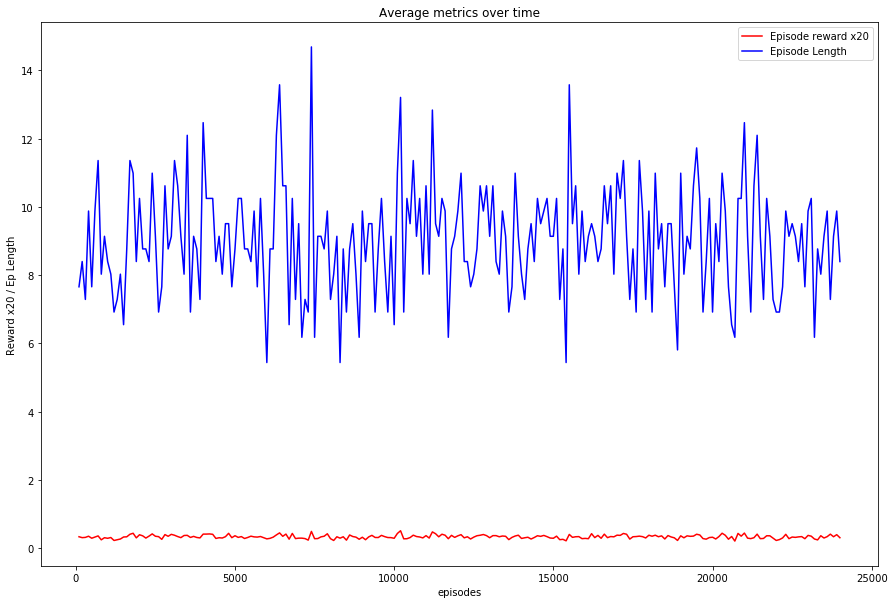

In [83]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

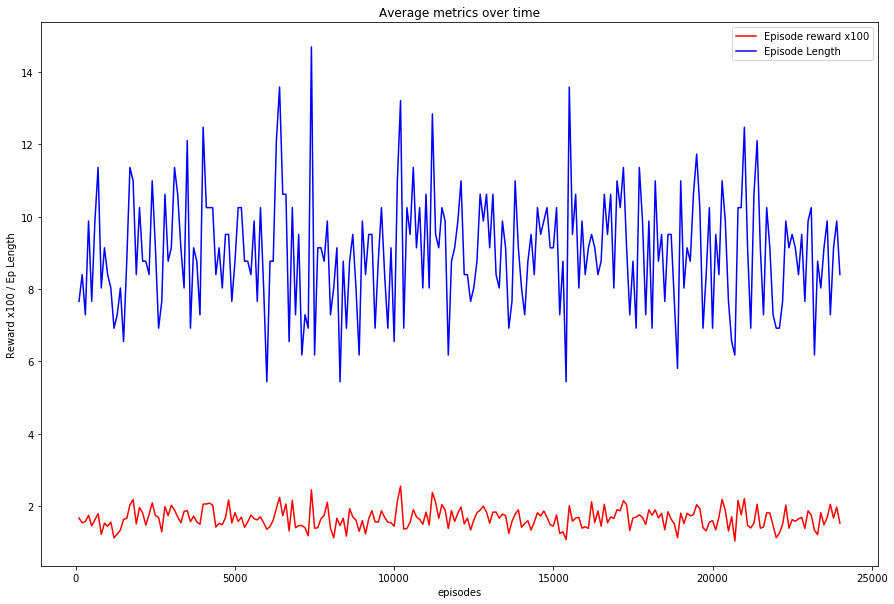

In [84]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

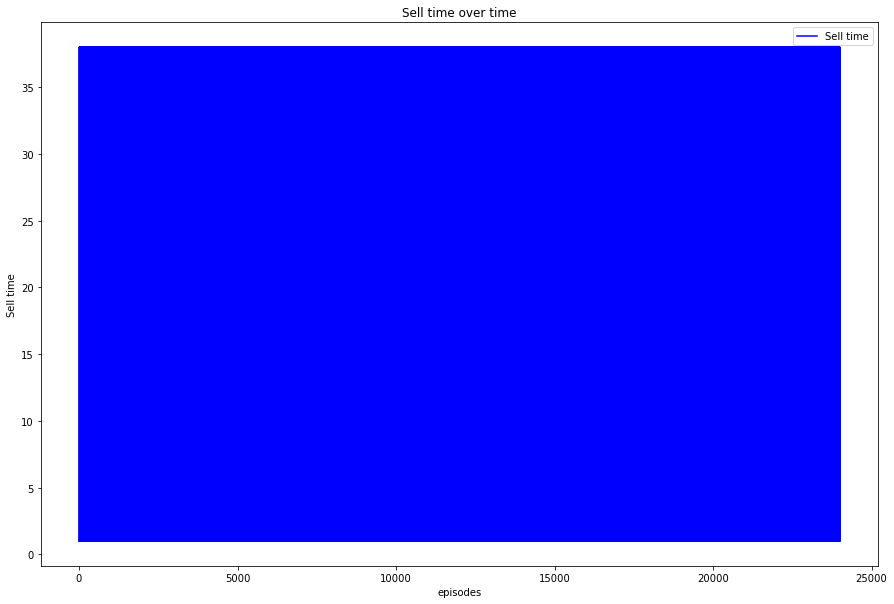

In [85]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Validation part

In [86]:
"""stock_names = ['t.us.txt', 'gm.us.txt', 'cvs.us.txt', 'unh.us.txt',
               'xom.us.txt', 'brk-a.us.txt', 'wmt.us.txt', 'mck.us.txt',
               'aat.us.txt', 'abc.us.txt', 'acre.us.txt', 'acta.us.txt',
               'fn.us.txt','fnb.us.txt', 'ford.us.txt', 'krg.us.txt',
              'pay.us.txt', 'peg.us.txt', 'tg.us.txt', 'tis.us.txt',
              'nflx.us.txt', 'acn.us.txt', 'utx.us.txt','lmt.us.txt',
              'nvda.us.txt', 'avgo.us.txt', 'azn.us.txt', 'tmo.us.txt',
               'unp.us.txt', 'lfc.us.txt', 'bhp.us.txt','sny.us.txt',
               'bbl.us.txt', 'ry.us.txt', 'asml.us.txt', 'nee.us.txt', 
              'txn.us.txt', 'gsk.us.txt', 'lly.us.txt', 'nvo.us.txt',
               'td.us.txt', 'qcom.us.txt', 'dhr.us.txt', 'chtr.us.txt',
               'sbux.us.txt', 'mmm.us.txt', 'axp.us.txt', 'hdb.us.txt',
              'csco.us.txt', 'orcl.us.txt', 'c.us.txt']
# unvalid stocks: 'kst.us.txt', 'ddt.us.txt', 'lgl.us.txt', 'aac.us.txt','adom.us.txt','acrs.us.txt', 'delt.us.txt', 'lcahu.us.txt', 'tpge.us.txt', 'wear.us.txt'

stocks_train_data = []
stocks_test_data = []
real_stocks_train_data = []
real_stocks_test_data = []
for stock_name in stock_names:
    #train_data, test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    train_data, test_data, real_train_data, real_test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    stocks_train_data.append(train_data)
    stocks_test_data.append(test_data)
    real_stocks_train_data.append(real_train_data)
    real_stocks_test_data.append(real_test_data)
    plt.plot(range(len(train_data)), train_data, color='b')
    plt.plot(range(len(test_data)), test_data, color='r') """

"stock_names = ['t.us.txt', 'gm.us.txt', 'cvs.us.txt', 'unh.us.txt',\n               'xom.us.txt', 'brk-a.us.txt', 'wmt.us.txt', 'mck.us.txt',\n               'aat.us.txt', 'abc.us.txt', 'acre.us.txt', 'acta.us.txt',\n               'fn.us.txt','fnb.us.txt', 'ford.us.txt', 'krg.us.txt',\n              'pay.us.txt', 'peg.us.txt', 'tg.us.txt', 'tis.us.txt',\n              'nflx.us.txt', 'acn.us.txt', 'utx.us.txt','lmt.us.txt',\n              'nvda.us.txt', 'avgo.us.txt', 'azn.us.txt', 'tmo.us.txt',\n               'unp.us.txt', 'lfc.us.txt', 'bhp.us.txt','sny.us.txt',\n               'bbl.us.txt', 'ry.us.txt', 'asml.us.txt', 'nee.us.txt', \n              'txn.us.txt', 'gsk.us.txt', 'lly.us.txt', 'nvo.us.txt',\n               'td.us.txt', 'qcom.us.txt', 'dhr.us.txt', 'chtr.us.txt',\n               'sbux.us.txt', 'mmm.us.txt', 'axp.us.txt', 'hdb.us.txt',\n              'csco.us.txt', 'orcl.us.txt', 'c.us.txt']\n# unvalid stocks: 'kst.us.txt', 'ddt.us.txt', 'lgl.us.txt', 'aac.us.txt','adom.

min value of data: 108.87524389134241, max value of data: 188.56082216931188
train_size: 743
test_size: 185
min value of data: 128.61971170009193, max value of data: 274.35215354173266
train_size: 743
test_size: 185
min value of data: 62.03602991343512, max value of data: 95.64161820654094
train_size: 743
test_size: 185
min value of data: 148.92583383758014, max value of data: 296.08994342434
train_size: 743
test_size: 185
min value of data: 50.05087009447692, max value of data: 81.81118484899123
train_size: 743
test_size: 185
min value of data: 141.6679007915422, max value of data: 237.497617689898
train_size: 743
test_size: 185
min value of data: 143.1110091184379, max value of data: 258.42341925020963
train_size: 743
test_size: 185
min value of data: 81.51807513764079, max value of data: 143.1274713426479
train_size: 743
test_size: 185
min value of data: 51.4101233454379, max value of data: 89.80889577657041
train_size: 743
test_size: 185
min value of data: 121.58161811184277, max v

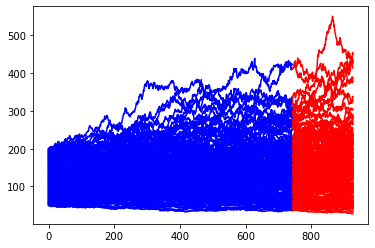

In [87]:
#Generate stocks data
stocks_data, _ = GBM(num_seeds, is_training).generate_stock_paths(mu, sigma, 928, num_seeds, is_training)
stocks_train_data = []
stocks_test_data = []
real_stocks_train_data = []
real_stocks_test_data = []
for stock_data in stocks_data:
    #train_data, test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    #train_data, test_data, real_train_data, real_test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    train_data, test_data, real_train_data, real_test_data = prepare_company_stock(stock_data, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    stocks_train_data.append(train_data)
    stocks_test_data.append(test_data)
    real_stocks_train_data.append(real_train_data)
    real_stocks_test_data.append(real_test_data)
    plt.plot(range(len(train_data)), train_data, color='b')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, color='r') 

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 187
num_episodes_per_epoch: 24000
min value of stock: 176.43635326910925, max value of stock: 227.42584621096825


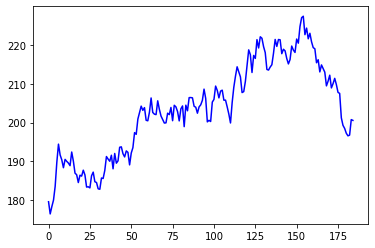

In [88]:
env = StockEnv(stocks_test_data, real_stocks_test_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
num_episodes = env.get_total_num_episodes_per_epoch()
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(test_data)) + ', max value of stock: '+str(max(test_data)))
plt.plot(range(len(test_data)), test_data, color='b')

In [89]:
begin_time = time.time()
tf.reset_default_graph()

mainQN = Qnetwork('main')
targetQN = Qnetwork('target')


init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=2)

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

#num_short_sell = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path) 
  

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    if load_model == True:
        print ('Loading Model...')
        #ckpt = tf.train.get_checkpoint_state(path)
        #saver.restore(sess,ckpt.model_checkpoint_path)
        saver.restore(sess,final_trained_model_name)
    else:
        sess.run(init)
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        #Reset the recurrent layer's hidden state
        state = np.zeros((num_layers, 2, 1, h_size))
        while j < max_epLength: 

            if j == max_epLength - 1 and env.is_episode_finished() == False:
                a = 1
            else:
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                        feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,\
                                   mainQN.state_in:state,mainQN.batch_size:1,\
                                   mainQN.num_quantiles:num_quantile_samples,\
                                   mainQN.quantiles_shape:num_quantile_samples})
                if env.get_time() < build_warm_up_state_t:
                    a = 0 #hold
                elif env.get_payoff() <= 0:
                    a = 0 #hold
                    #num_short_sell += 1
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            state = state1
            j+=1 # episode length till selling or reaching last day of option

            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
            
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Number of short selling: " + str(num_short_sell))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

Loading Model...
INFO:tensorflow:Restoring parameters from /misc/scratch05/patx/fathanab/Experiments_RL/normalizeFirstDay_seed_corrected_2019_11_21_shuffled_GBM_version/savedModel/IQN_200noSoft_00005_1000freq_128batch_dropout_arch0-option_T50-history_t15-softUpdateFalse-tau0.001-huber_lossTrue-freq1000-batch128-capacity10000-lambda5e-05-final
episode 100: 	0.03244807263213935	17.85
episode 200: 	0.024020922646687193	11.49
episode 300: 	0.029860445424612907	15.17
episode 400: 	0.02544710278267631	11.43
episode 500: 	0.028029320103800187	16.13
episode 600: 	0.034231033480346104	14.12
episode 700: 	0.026221349162237045	15.1
episode 800: 	0.03227554351389936	14.99
episode 900: 	0.027607678464804778	13.35
episode 1000: 	0.03043591664558014	13.26
episode 1100: 	0.029786418416302283	14.02
episode 1200: 	0.027836951771164572	14.56
episode 1300: 	0.028482904265260567	12.6
episode 1400: 	0.02690590148702828	12.74
episode 1500: 	0.02977759335285141	15.41
episode 1600: 	0.03440650632039566	15.99
e

In [90]:
# Normal Test
# 4000 episodes
#Average reward per episode: -0.0004459820152409164%
#Time to execute: 1.0273285110791524min

# 10000 episodes of training (23000 episodes)
#Average reward per episode: -0.0006903839079534307%
#Time to execute: 18.210397080580393min

# 30000 episodes of training (23000 episodes)
#Average reward per episode: -0.0015529333479744412%
#Time to execute: 27.645483565330505min

# 20000 episodes of training
#Average reward per episode: -0.0049713977980137885%
#Time to execute: 31.664522131284077min

# 100000 episodes of training # architecture 0
#Total average reward per episode: -0.0031459276190924593
#Time to execute: 27.598839151859284min

#20000 episodes training
#Total average reward per episode: 0.0024760915583103395
#Time to execute: 2.219494903087616min

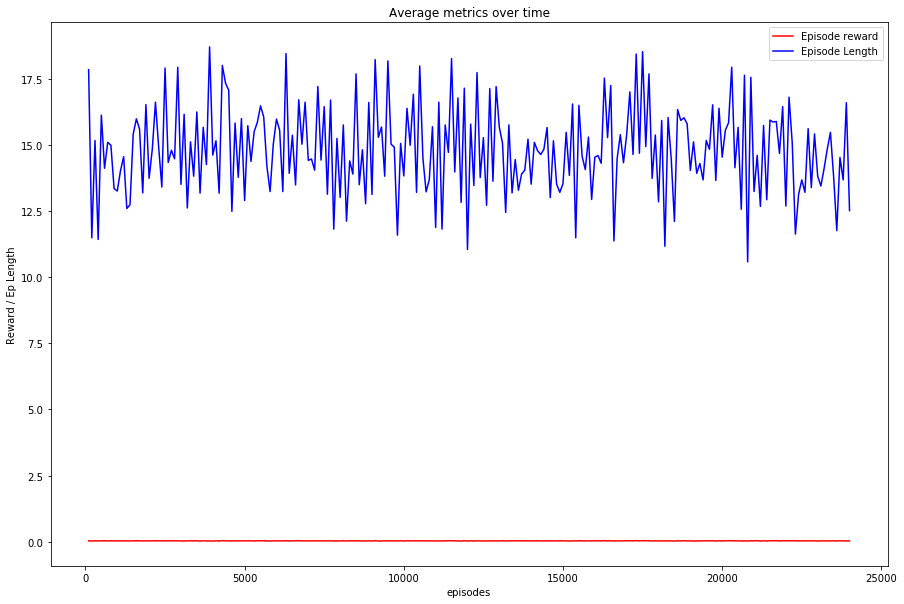

In [91]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

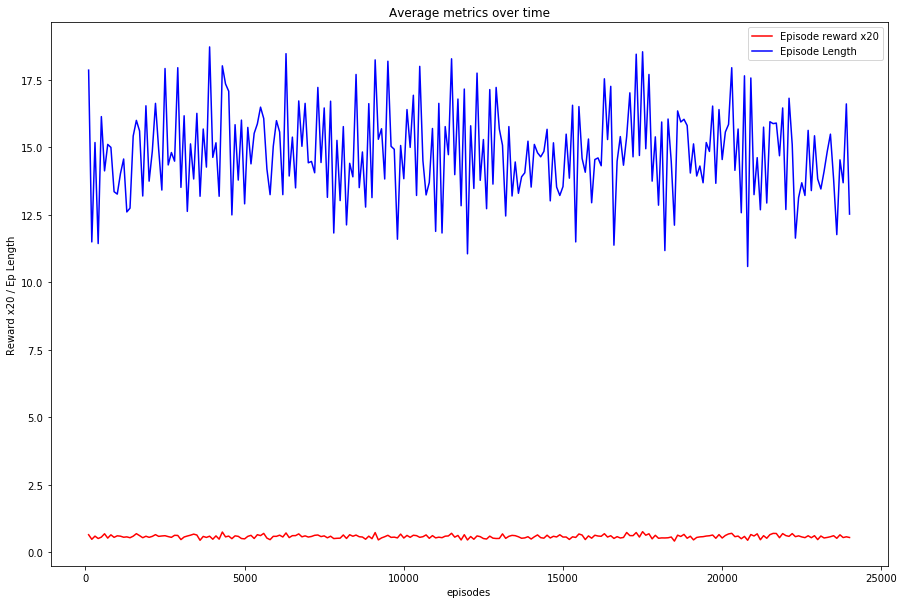

In [92]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

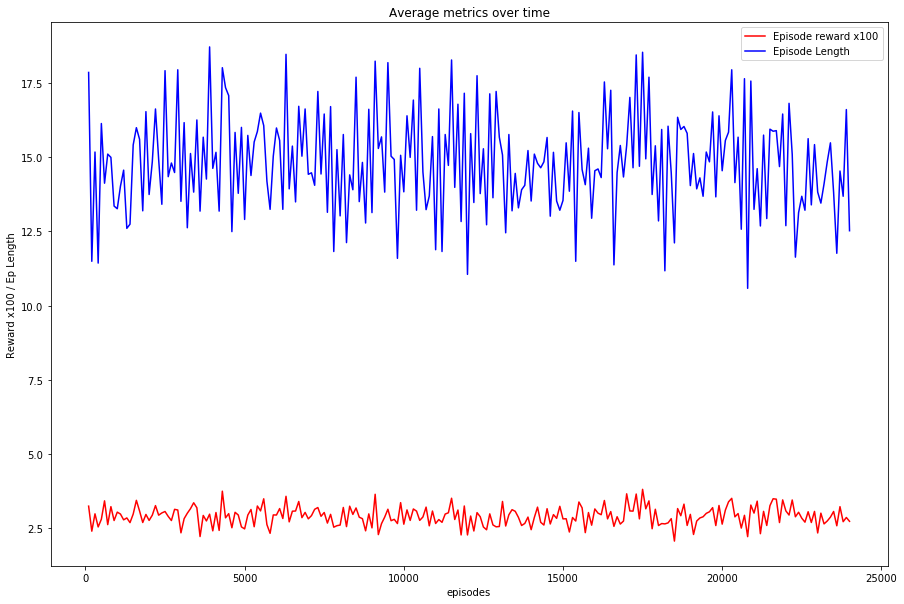

In [93]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

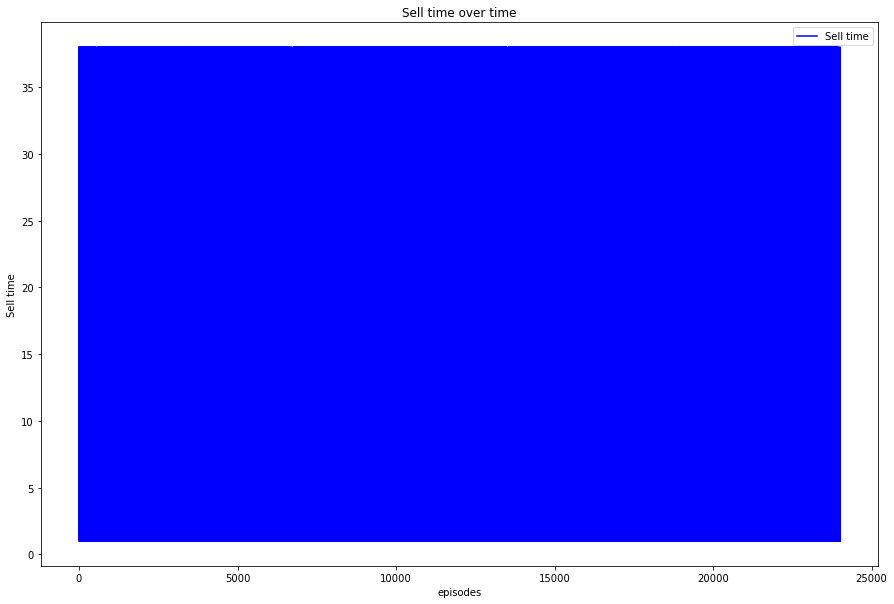

In [94]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select random day over history to sell [Benchmark]

In [95]:
env.reset_new_test() # reset to first observation in data
begin_time = time.time()

test = 'Random'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []
  

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MaxValue':
              if (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)
        
        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))   

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.026326331274310246	16.92
episode 200: 	0.015425328013792232	9.98
episode 300: 	0.026837979327264186	15.45
episode 400: 	0.018628301284597856	11.19
episode 500: 	0.022760646942569896	16.16
episode 600: 	0.023778870329487143	12.14
episode 700: 	0.022830523890515732	15.77
episode 800: 	0.024889404888383922	13.63
episode 900: 	0.022053532353510222	13.25
episode 1000: 	0.025296226373447847	12.38
episode 1100: 	0.023100919000927752	12.98
episode 1200: 	0.021009636053346686	16.01
episode 1300: 	0.02285256313745917	13.16
episode 1400: 	0.019038571777341452	12.09
episode 1500: 	0.027251470505024224	15.91
episode 1600: 	0.031024242660278936	15.48
episode 1700: 	0.025190995787844356	14.58
episode 1800: 	0.024873114825893355	15.52
episode 1900: 	0.024627122036744865	16.18
episode 2000: 	0.02384983441798919	14.32
episode 2100: 	0.021825975517754875	14.32
episode 2200: 	0.03205260708558475	15.78
episode 2300: 	0.023875166082217313	14.37
episode 2400: 	0.02499087462894896	14.27
episod

In [96]:
# 4000 episodes
# Select random state over history [Benchmark]
#Average reward per episode: 0.0015505754102431175%
#Time to execute: 0.07682177225748697min

#23000 episodes
# Average reward per episode: 0.0012894304336377236%
#Time to execute: 0.40911168257395425min

#23000 episodes
#Average reward per episode: 0.002274329489706149%
#Time to execute: 0.6566788395245869min

#23000 episodes
#Average reward per episode: 0.001215791565711024%
#Time to execute: 0.36365593671798707min

# 23000 episodes
#Total average reward per episode: 0.00036678919435973405
#Time to execute: 0.4333968202273051min

# 23000 episodes
#Total average reward per episode: 0.0010562361629312214
#Time to execute: 0.6513438741366069min

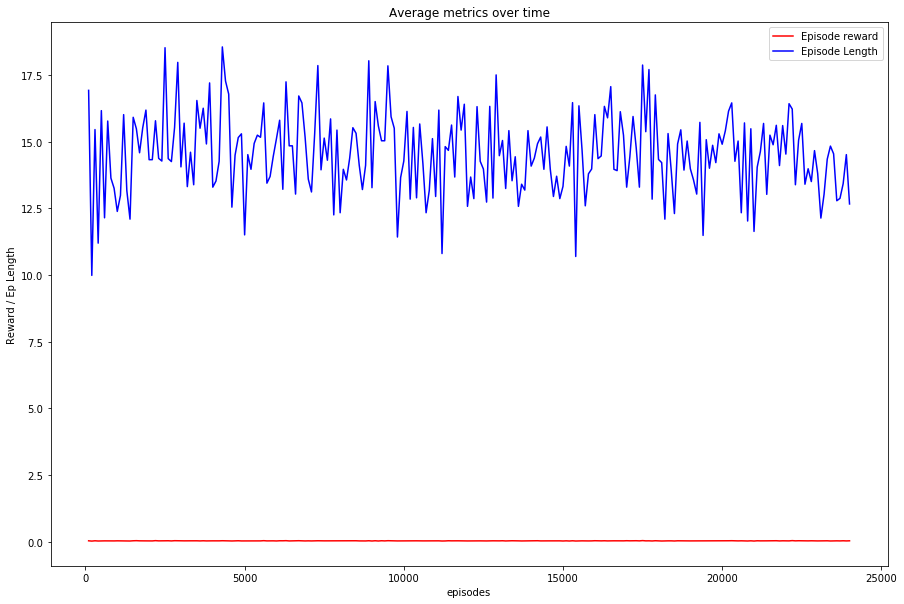

In [97]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

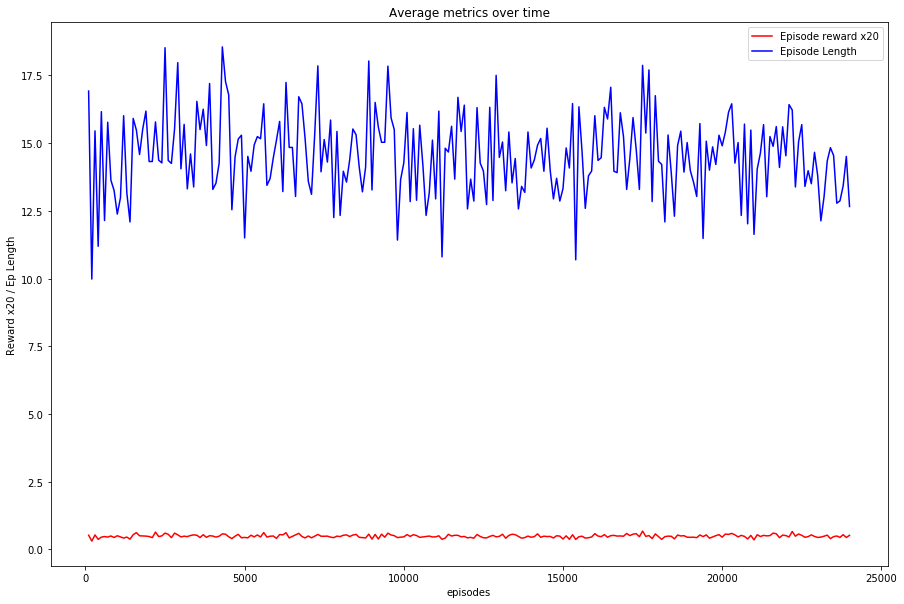

In [98]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

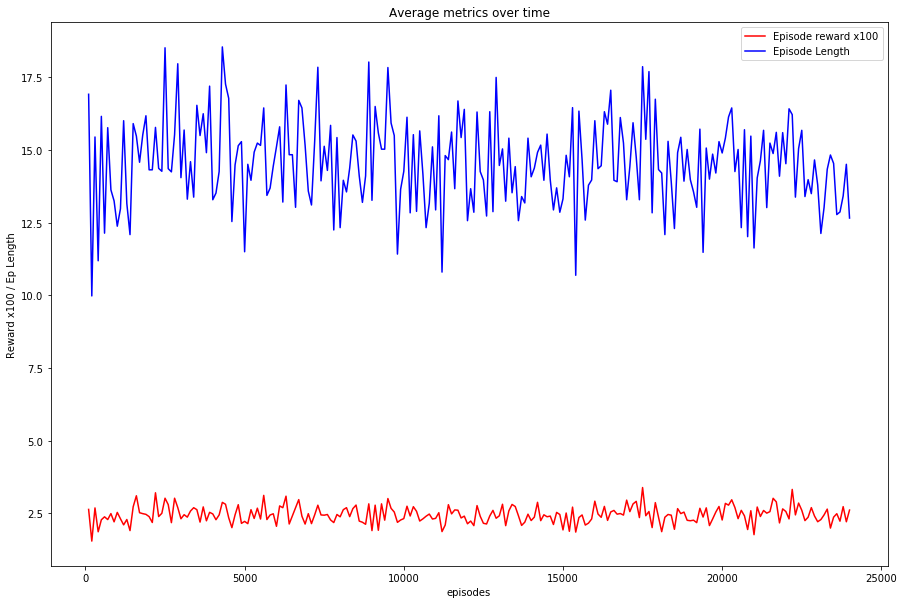

In [99]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

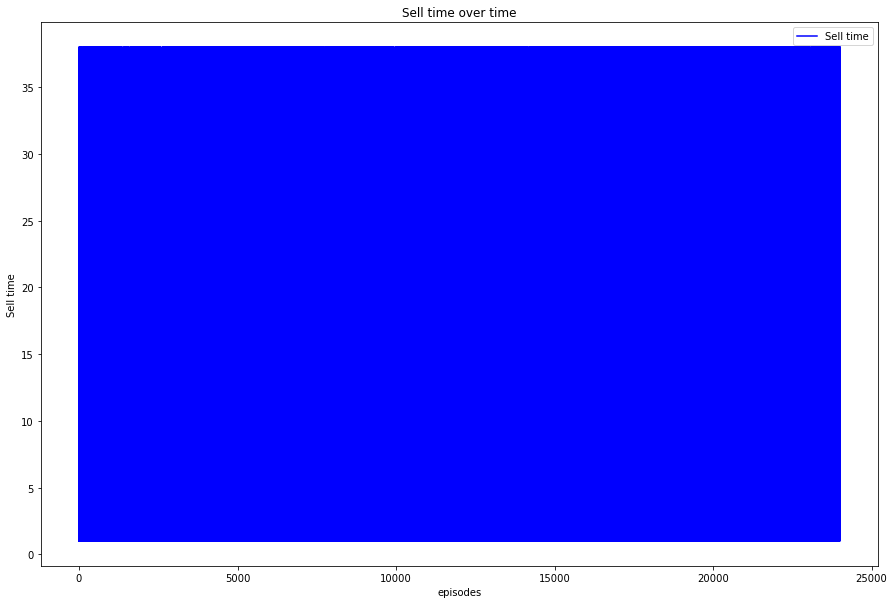

In [100]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select last day over history to sell [Benchmark]

In [101]:
env.reset_new_test() # reset to first observation in data
begin_time = time.time()

test = 'LastDay'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []  

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'LastDay':
          sell_time = max_epLength - 1  
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MaxValue':
              if (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random' or test == 'LastDay':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)

            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))   

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.028317417584841565	21.72
episode 200: 	0.024635148326489376	15.06
episode 300: 	0.02900560695865267	19.87
episode 400: 	0.020137780383819102	15.06
episode 500: 	0.024798161622841	19.87
episode 600: 	0.030072060951861105	19.5
episode 700: 	0.0245531372749456	19.13
episode 800: 	0.03467394259086229	20.98
episode 900: 	0.0269587236325102	16.91
episode 1000: 	0.029323509785338688	16.54
episode 1100: 	0.027606406213855985	18.02
episode 1200: 	0.02334616342165825	19.5
episode 1300: 	0.028354758816475388	17.28
episode 1400: 	0.025374532932283502	16.54
episode 1500: 	0.03394797238758174	20.24
episode 1600: 	0.037596100133297145	20.61
episode 1700: 	0.031293633763255106	19.5
episode 1800: 	0.023606579620354333	17.28
episode 1900: 	0.026653911651834818	19.5
episode 2000: 	0.02860292613027685	18.39
episode 2100: 	0.029285253307137275	19.13
episode 2200: 	0.03296419847689567	20.98
episode 2300: 	0.028531330339359475	19.87
episode 2400: 	0.025036632831399203	17.65
episode 2500: 	0.0

In [102]:
# 4600 episodes
#Average reward per episode: 0.001350523388538691%
#Time to execute: 0.08548296292622884min

#23000 episodes
#Average reward per episode: 0.002919471458257028%
#Time to execute: 0.32947063048680625min

# 23000 episodes
#Total average reward per episode: 0.003380776061516078
#Time to execute: 0.36532406012217206min

# 23000 episodes
#Total average reward per episode: 0.002987836452606828
#Time to execute: 0.5932944019635519min

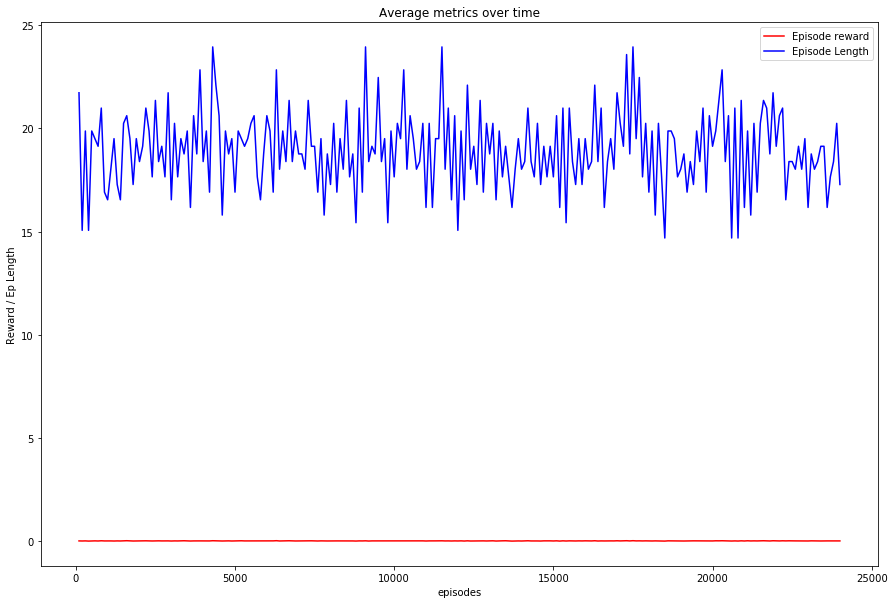

In [103]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

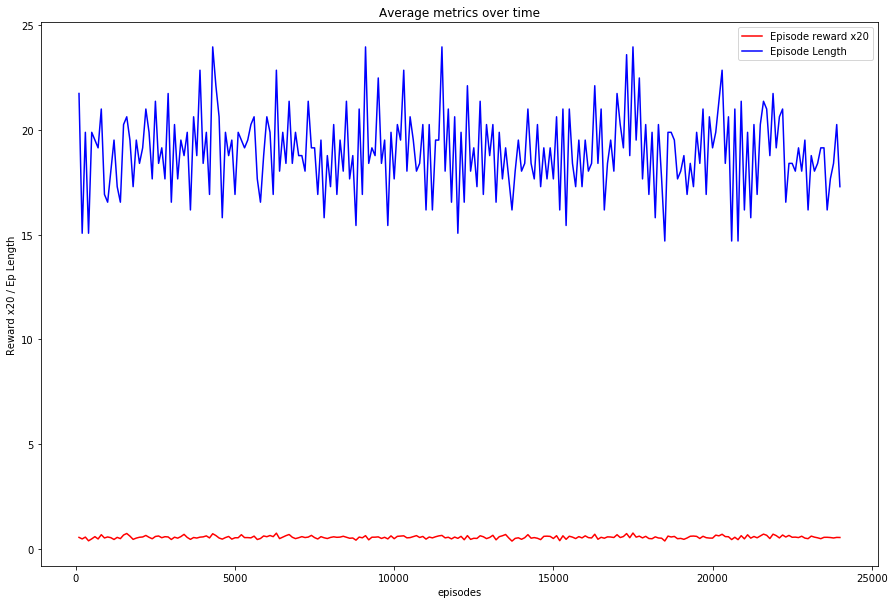

In [104]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

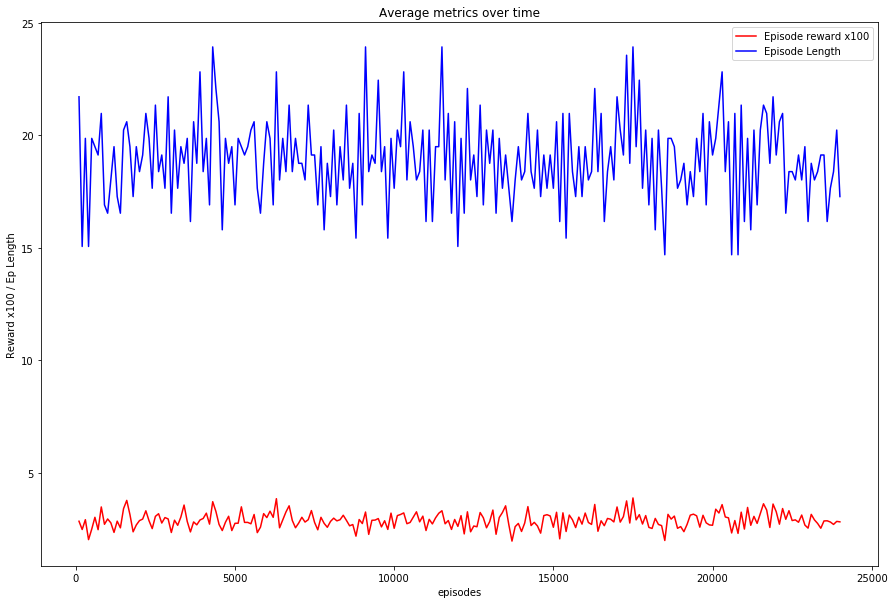

In [105]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

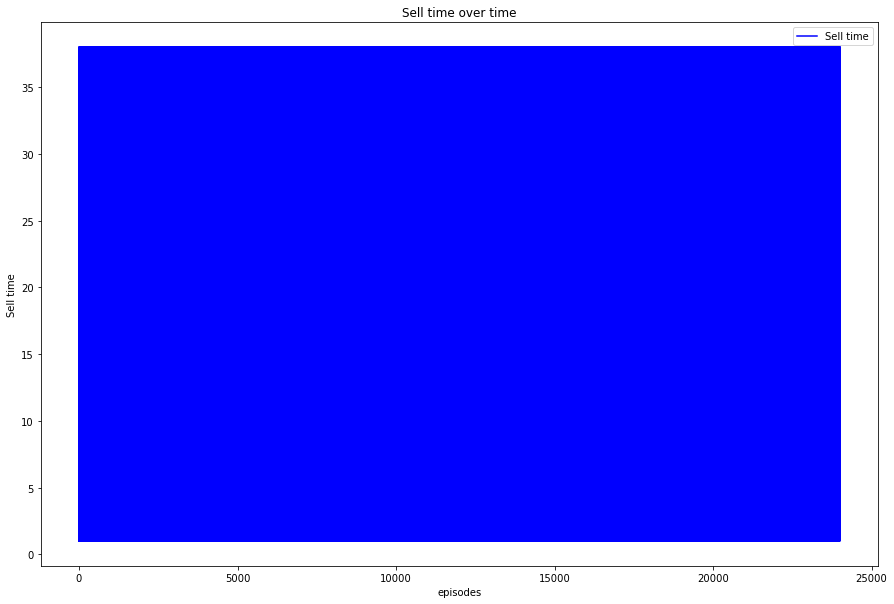

In [106]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select first day over history to sell [Benchmark]

In [107]:
env.reset_new_test() # reset to first observation in data
begin_time = time.time()

test = 'FirstDay'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = [] 

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'FirstDay':
          sell_time = build_warm_up_state_t 
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MaxValue':
              if (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random' or test == 'FirstDay':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)

            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))   

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.015275336058560025	9.14
episode 200: 	0.017188501176930892	8.4
episode 300: 	0.022076754653898203	12.47
episode 400: 	0.011454943974734122	6.55
episode 500: 	0.016623837805487183	9.51
episode 600: 	0.018240806426600958	8.03
episode 700: 	0.014234909055224478	9.14
episode 800: 	0.017481323958999855	9.14
episode 900: 	0.017121101701698244	8.77
episode 1000: 	0.01709357167634455	7.66
episode 1100: 	0.015828356361048804	8.03
episode 1200: 	0.0131253795874207	9.88
episode 1300: 	0.011023659673691198	6.55
episode 1400: 	0.018881228460695617	9.51
episode 1500: 	0.015382591794621472	8.03
episode 1600: 	0.01721572256894712	10.25
episode 1700: 	0.02136726487543998	11.73
episode 1800: 	0.015630730911582624	9.14
episode 1900: 	0.015057280955790042	9.88
episode 2000: 	0.018027077186027154	8.03
episode 2100: 	0.017849415432813685	9.14
episode 2200: 	0.019226390998040802	10.25
episode 2300: 	0.018277437122942962	10.25
episode 2400: 	0.01592965602771053	7.66
episode 2500: 	0.0203432471

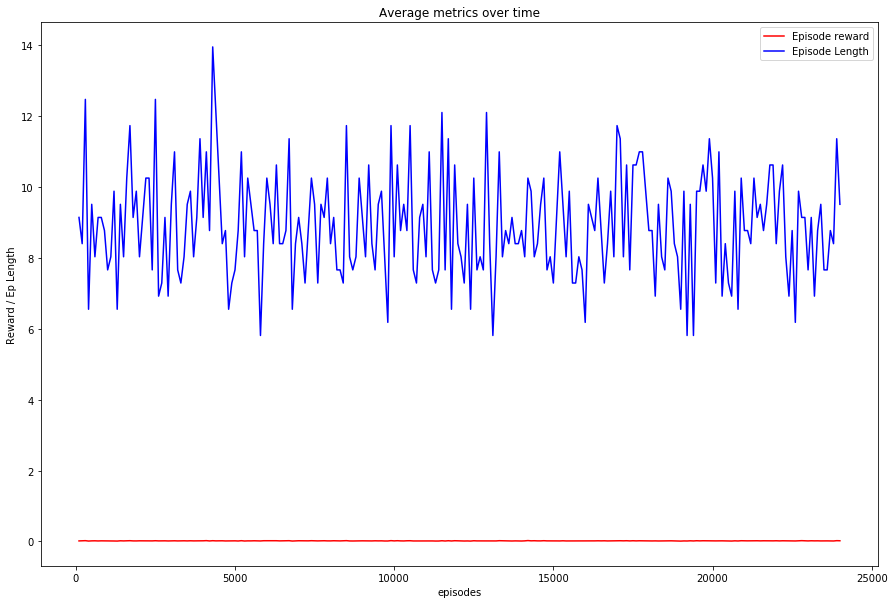

In [108]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

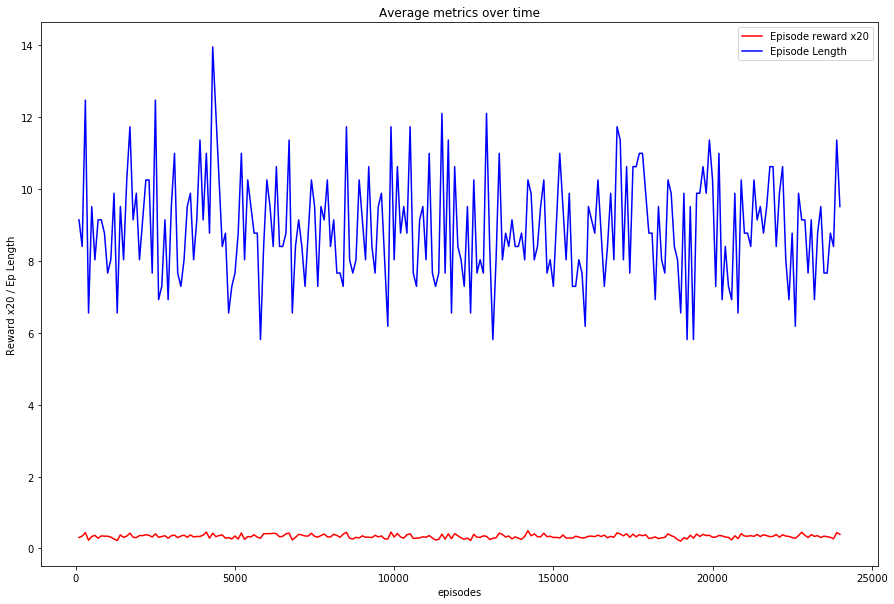

In [109]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

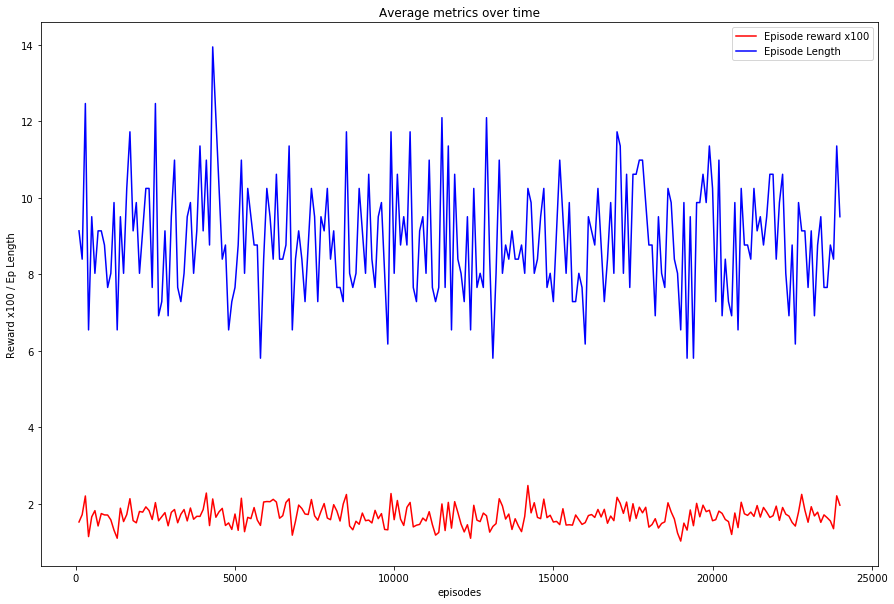

In [110]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

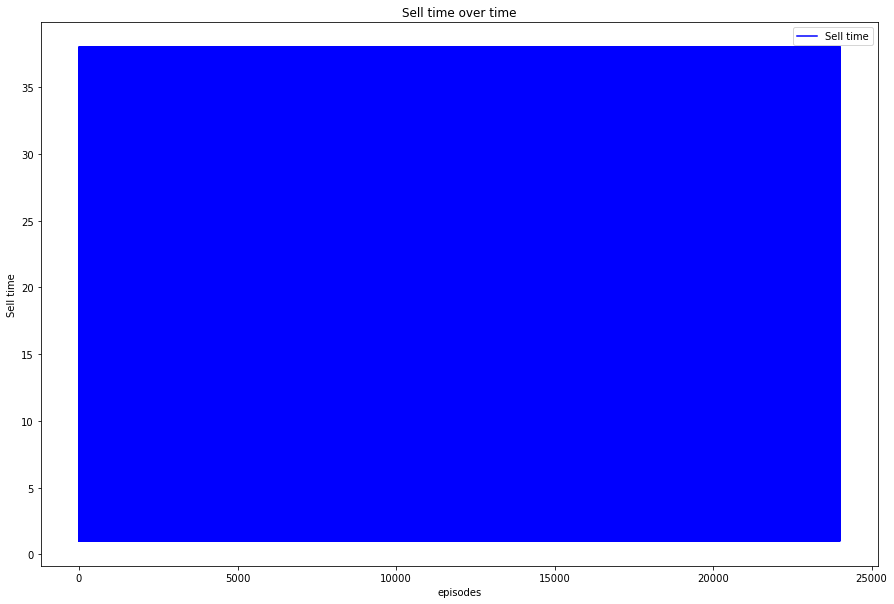

In [111]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Second Valid

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 1059
num_episodes_per_epoch: 135600
min value of stock: 121.1553335570293, max value of stock: 180.06841858691385


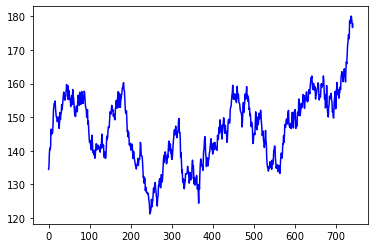

In [112]:
env = StockEnv(stocks_train_data, real_stocks_train_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
num_episodes = env.get_total_num_episodes_per_epoch()
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(train_data)) + ', max value of stock: '+str(max(train_data)))
plt.plot(range(len(train_data)), train_data, color='b')

In [113]:
begin_time = time.time()
tf.reset_default_graph()

mainQN = Qnetwork('main')
targetQN = Qnetwork('target')


init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=2)

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

#num_short_sell = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path) 
  

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    if load_model == True:
        print ('Loading Model...')
        #ckpt = tf.train.get_checkpoint_state(path)
        #saver.restore(sess,ckpt.model_checkpoint_path)
        saver.restore(sess,final_trained_model_name)
    else:
        sess.run(init)
    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        #Reset the recurrent layer's hidden state
        state = np.zeros((num_layers, 2, 1, h_size))
        while j < max_epLength: 

            if j == max_epLength - 1 and env.is_episode_finished() == False:
                a = 1
            else:
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                        feed_dict={mainQN.scalarInput:[s],mainQN.trainLength:1,\
                                   mainQN.state_in:state,mainQN.batch_size:1,\
                                   mainQN.num_quantiles:num_quantile_samples,\
                                   mainQN.quantiles_shape:num_quantile_samples})
                if env.get_time() < build_warm_up_state_t:
                    a = 0 #hold
                elif env.get_payoff() <= 0:
                    a = 0 #hold
                    #num_short_sell += 1
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            state = state1
            j+=1 # episode length till selling or reaching last day of option

            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
            
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Number of short selling: " + str(num_short_sell))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

Loading Model...
INFO:tensorflow:Restoring parameters from /misc/scratch05/patx/fathanab/Experiments_RL/normalizeFirstDay_seed_corrected_2019_11_21_shuffled_GBM_version/savedModel/IQN_200noSoft_00005_1000freq_128batch_dropout_arch0-option_T50-history_t15-softUpdateFalse-tau0.001-huber_lossTrue-freq1000-batch128-capacity10000-lambda5e-05-final
episode 100: 	0.028129128788999563	12.54
episode 200: 	0.029887282340398245	15.2
episode 300: 	0.027609542139068875	14.07
episode 400: 	0.030682160445118675	14.66
episode 500: 	0.024129319156927842	14.07
episode 600: 	0.026650848970591133	15.21
episode 700: 	0.02810907428753585	14.21
episode 800: 	0.03005833633326035	17.6
episode 900: 	0.03360377786917465	17.22
episode 1000: 	0.031102036677053347	17.19
episode 1100: 	0.029986386198079515	16.4
episode 1200: 	0.02296547573831094	14.2
episode 1300: 	0.030042778633666892	13.02
episode 1400: 	0.03071369923194085	15.89
episode 1500: 	0.031008818178727634	14.7
episode 1600: 	0.02651859389097054	15.09
epi

In [114]:
# Normal Test
# 4000 episodes
#Average reward per episode: -0.0004459820152409164%
#Time to execute: 1.0273285110791524min

# 10000 episodes of training (23000 episodes)
#Average reward per episode: -0.0006903839079534307%
#Time to execute: 18.210397080580393min

# 30000 episodes of training (23000 episodes)
#Average reward per episode: -0.0015529333479744412%
#Time to execute: 27.645483565330505min

# 20000 episodes of training
#Average reward per episode: -0.0049713977980137885%
#Time to execute: 31.664522131284077min

# 100000 episodes of training # architecture 0
#Total average reward per episode: -0.0031459276190924593
#Time to execute: 27.598839151859284min

#20000 episodes training
#Total average reward per episode: 0.0024760915583103395
#Time to execute: 2.219494903087616min

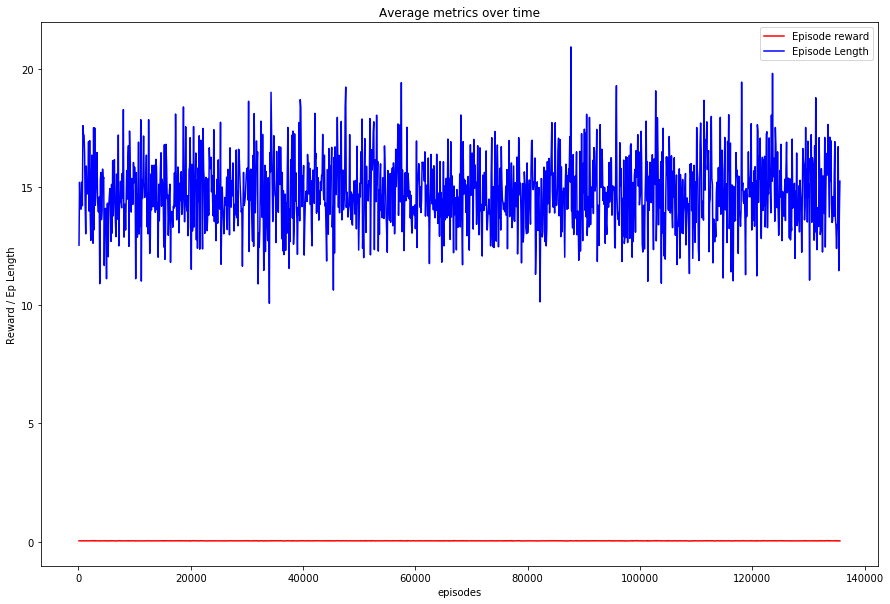

In [115]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

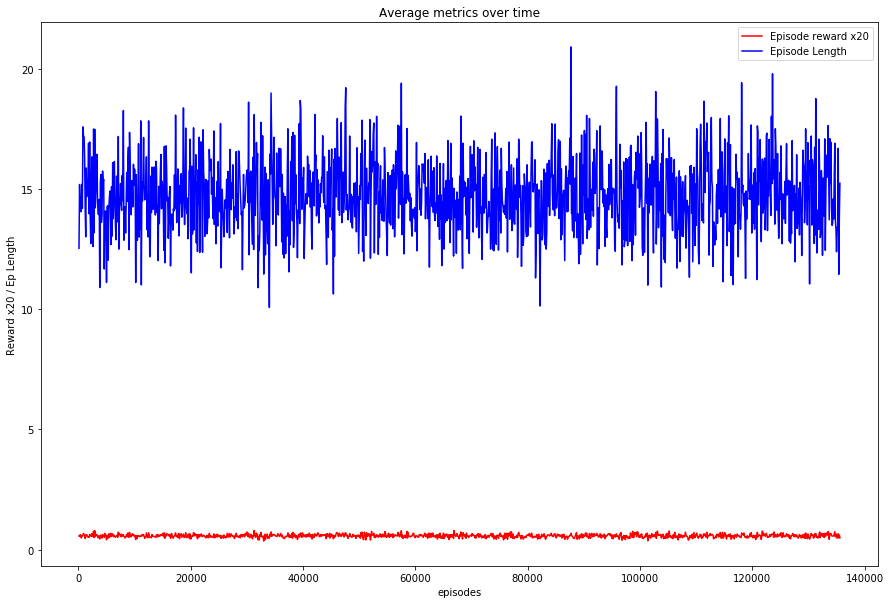

In [116]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

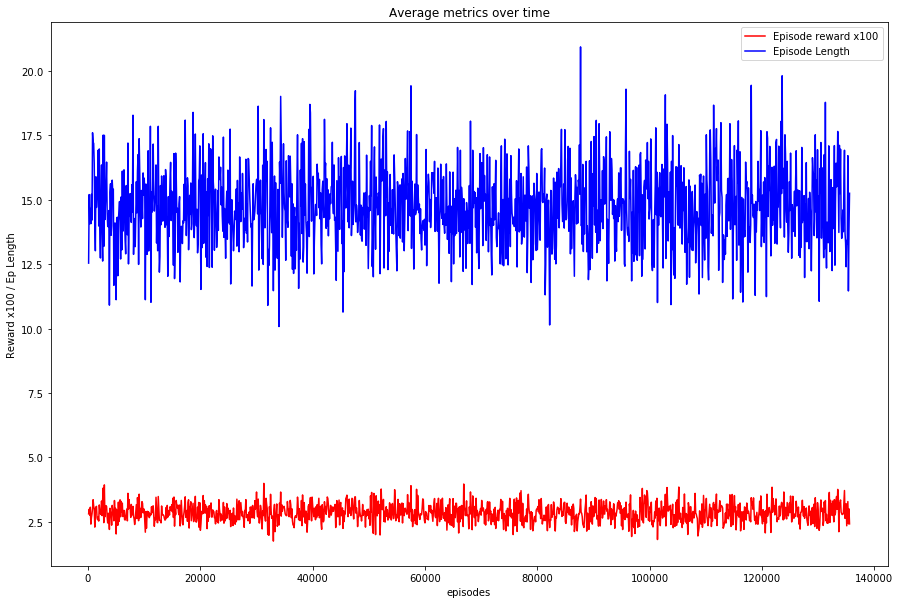

In [117]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

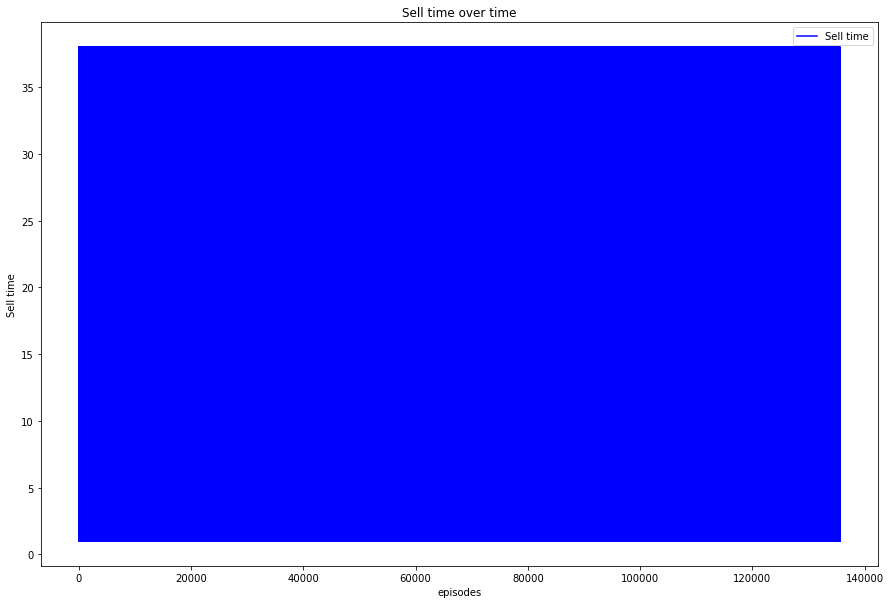

In [118]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select random day over history to sell [Benchmark]

In [119]:
env.reset_new_test() # reset to first observation in data
begin_time = time.time()

test = 'Random'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []
  

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MaxValue':
              if (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)
        
        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))   

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.023056821136729834	12.88
episode 200: 	0.025195562786001803	13.97
episode 300: 	0.026506214025259503	14.75
episode 400: 	0.02687991563532112	14.1
episode 500: 	0.02170271948702131	14.14
episode 600: 	0.016372534033607347	14.14
episode 700: 	0.024151982407868332	13.66
episode 800: 	0.023598639511661062	16.22
episode 900: 	0.029199043718771647	17.66
episode 1000: 	0.02432609889407787	16.78
episode 1100: 	0.020936932332394034	13.0
episode 1200: 	0.018174127481176906	12.42
episode 1300: 	0.02775089367005246	14.49
episode 1400: 	0.027603665633545126	17.98
episode 1500: 	0.025629673545424204	15.4
episode 1600: 	0.024153214661404313	13.81
episode 1700: 	0.020310207308491254	13.93
episode 1800: 	0.020987455195843097	16.23
episode 1900: 	0.018544747033592997	11.08
episode 2000: 	0.027274622557440117	15.24
episode 2100: 	0.02674004685071942	13.72
episode 2200: 	0.027151490611514117	14.28
episode 2300: 	0.026031646383014712	15.41
episode 2400: 	0.024288652402589837	14.89
episode 2

In [120]:
# 4000 episodes
# Select random state over history [Benchmark]
#Average reward per episode: 0.0015505754102431175%
#Time to execute: 0.07682177225748697min

#23000 episodes
# Average reward per episode: 0.0012894304336377236%
#Time to execute: 0.40911168257395425min

#23000 episodes
#Average reward per episode: 0.002274329489706149%
#Time to execute: 0.6566788395245869min

#23000 episodes
#Average reward per episode: 0.001215791565711024%
#Time to execute: 0.36365593671798707min

# 23000 episodes
#Total average reward per episode: 0.00036678919435973405
#Time to execute: 0.4333968202273051min

# 23000 episodes
#Total average reward per episode: 0.0010562361629312214
#Time to execute: 0.6513438741366069min

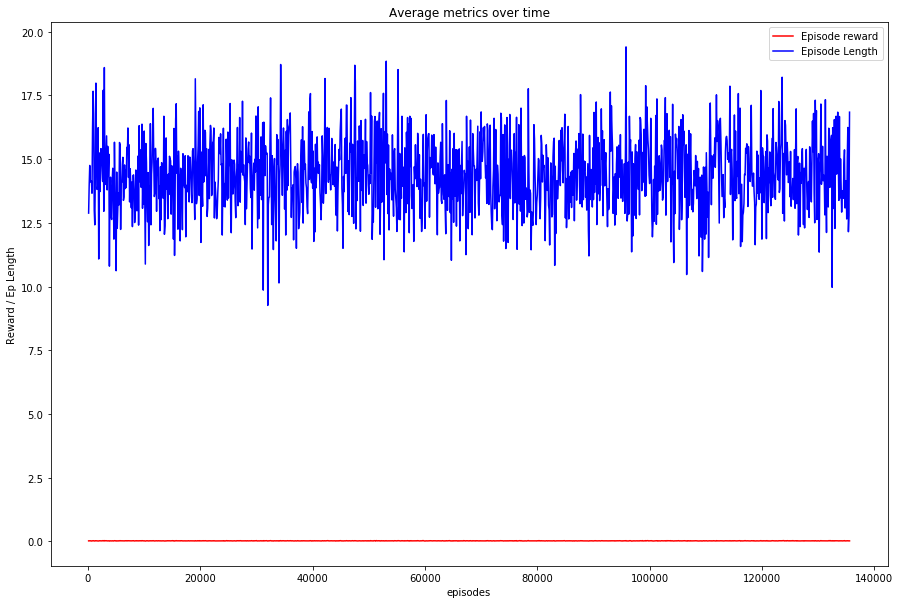

In [121]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

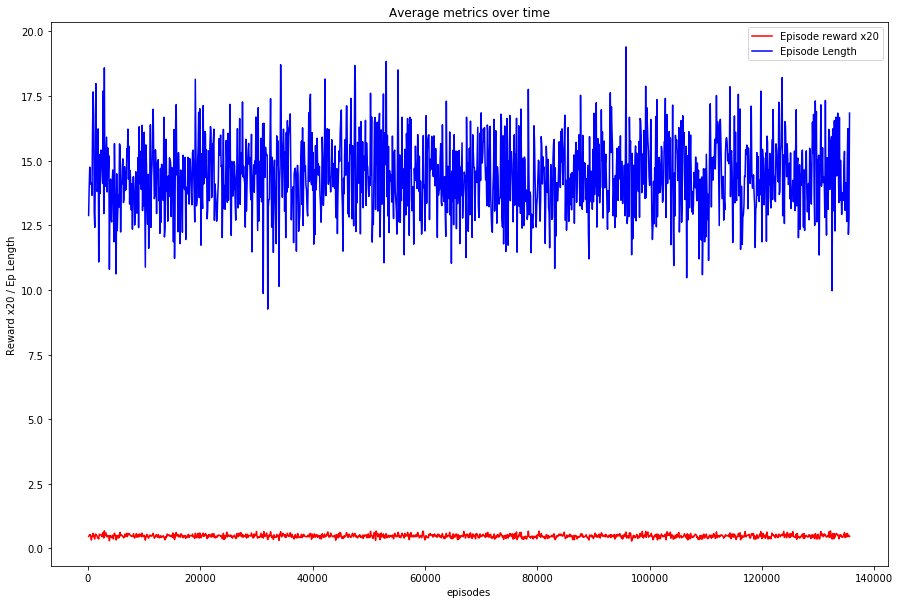

In [122]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

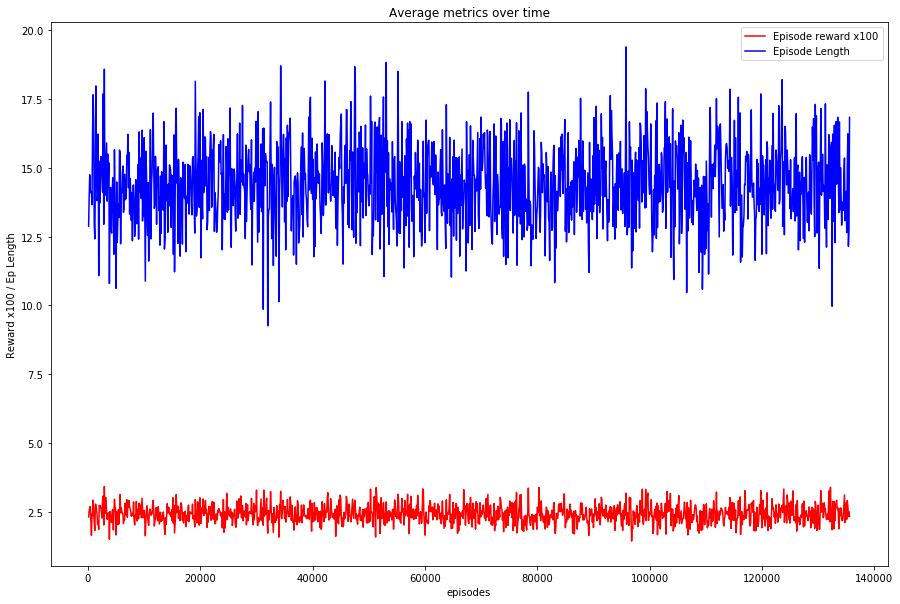

In [123]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

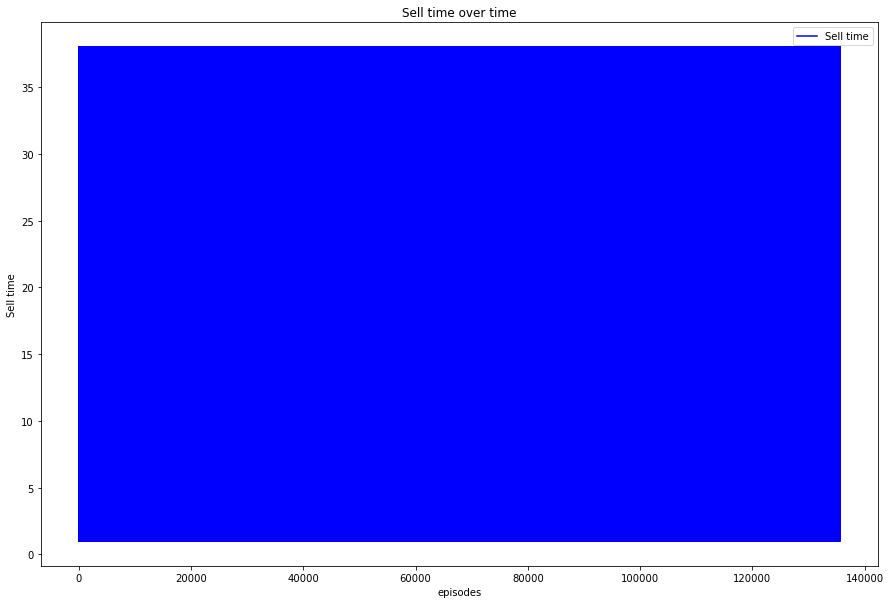

In [124]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select last day over history to sell [Benchmark]

In [125]:
env.reset_new_test() # reset to first observation in data
begin_time = time.time()

test = 'LastDay'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []  

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'LastDay':
          sell_time = max_epLength - 1  
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MaxValue':
              if (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random' or test == 'LastDay':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)

            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))   

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.023585336333908802	16.54
episode 200: 	0.030091031631795558	19.87
episode 300: 	0.030581985547239388	18.76
episode 400: 	0.03458335045639624	20.24
episode 500: 	0.024866793886140864	18.39
episode 600: 	0.0238899244775567	18.39
episode 700: 	0.026836558997762695	19.5
episode 800: 	0.03185080868482192	22.09
episode 900: 	0.03128571988934563	22.09
episode 1000: 	0.025890375840613804	20.98
episode 1100: 	0.026427313472925665	19.5
episode 1200: 	0.021309202988092028	17.28
episode 1300: 	0.03343553170292327	18.39
episode 1400: 	0.03401223555964209	21.72
episode 1500: 	0.029694098070195473	19.5
episode 1600: 	0.02313488560251442	18.02
episode 1700: 	0.02334328892221961	19.5
episode 1800: 	0.024404976440704714	20.61
episode 1900: 	0.02643642611332518	16.17
episode 2000: 	0.029525288178171	21.35
episode 2100: 	0.02580028138057682	18.02
episode 2200: 	0.029203005593121754	18.02
episode 2300: 	0.029950641778256803	19.5
episode 2400: 	0.031072411956038156	21.35
episode 2500: 	0.024

In [126]:
# 4600 episodes
#Average reward per episode: 0.001350523388538691%
#Time to execute: 0.08548296292622884min

#23000 episodes
#Average reward per episode: 0.002919471458257028%
#Time to execute: 0.32947063048680625min

# 23000 episodes
#Total average reward per episode: 0.003380776061516078
#Time to execute: 0.36532406012217206min

# 23000 episodes
#Total average reward per episode: 0.002987836452606828
#Time to execute: 0.5932944019635519min

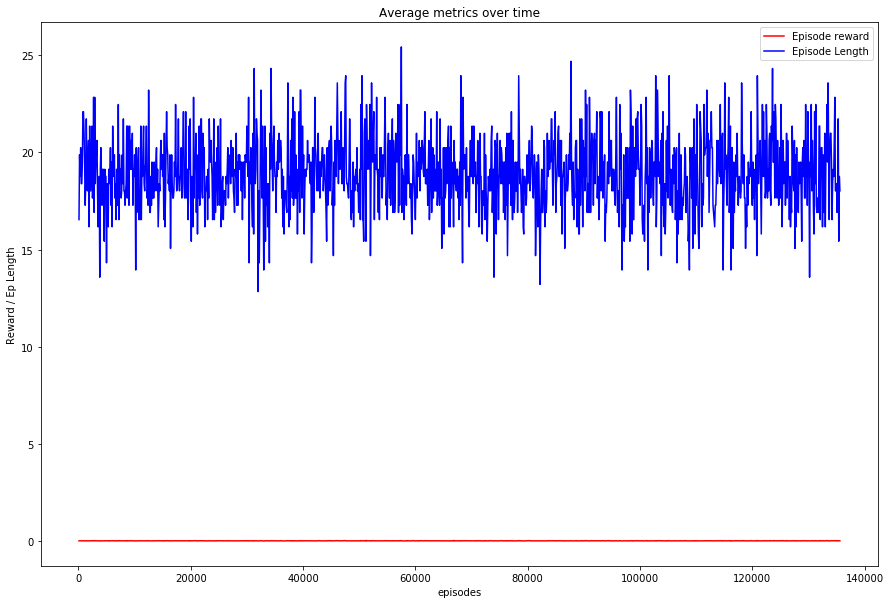

In [127]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

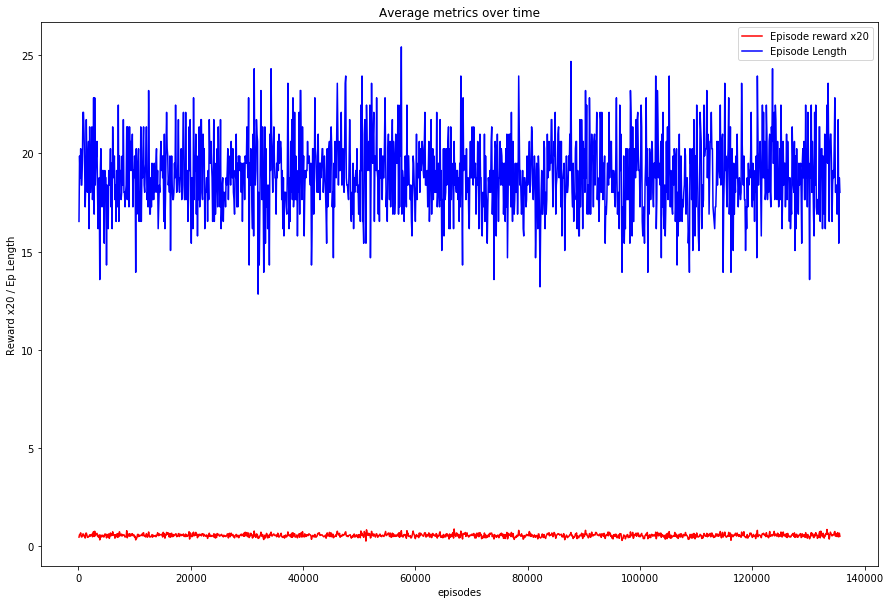

In [128]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

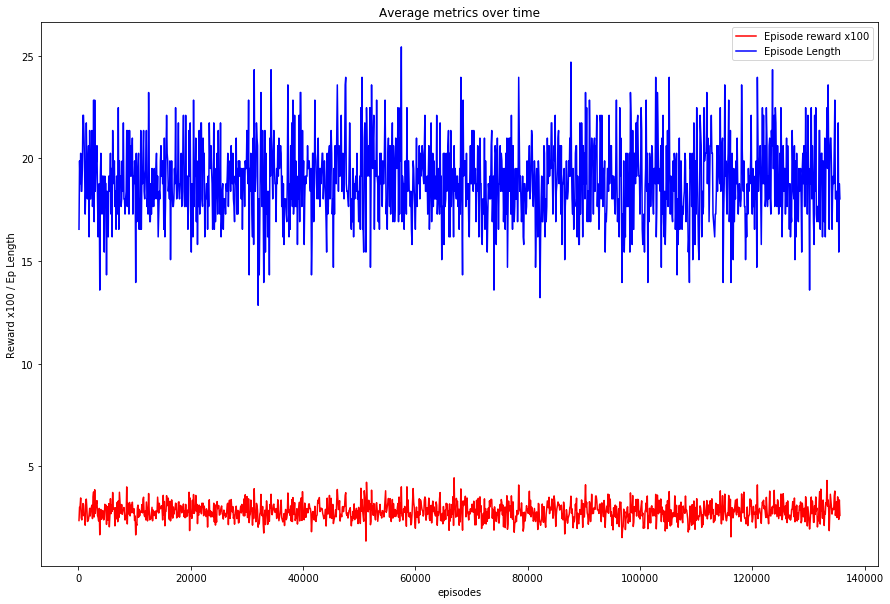

In [129]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

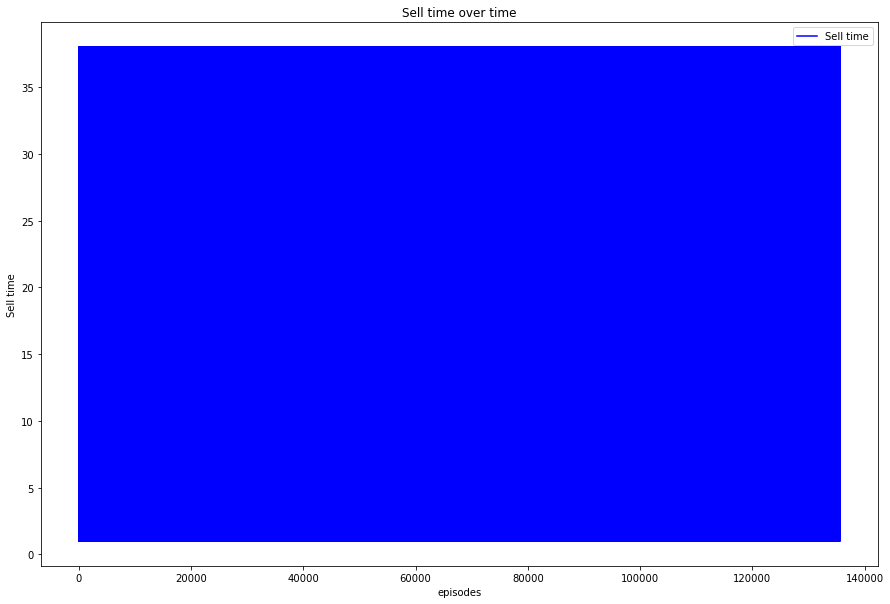

In [130]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Select first day over history to sell [Benchmark]

In [131]:
env.reset_new_test() # reset to first observation in data
begin_time = time.time()

test = 'FirstDay'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = [] 

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'FirstDay':
          sell_time = build_warm_up_state_t 
        elif test == 'MaxValue' or test == 'Normal':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MaxValue':
              if (s[-1] >= max(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random' or test == 'FirstDay':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)

            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break
        
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))   

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.016647575759770276	7.29
episode 200: 	0.014454066678408668	9.51
episode 300: 	0.01581770633491659	9.14
episode 400: 	0.017430075357195072	8.77
episode 500: 	0.016038039414726032	10.25
episode 600: 	0.015011773054984188	8.4
episode 700: 	0.01440146561471965	8.03
episode 800: 	0.018018335671621984	9.88
episode 900: 	0.01630994849834975	8.77
episode 1000: 	0.01624639021446274	12.47
episode 1100: 	0.01707387788906529	10.25
episode 1200: 	0.017628319926909775	9.51
episode 1300: 	0.01640593948778339	8.77
episode 1400: 	0.015690562795084444	7.66
episode 1500: 	0.02029425671332592	10.25
episode 1600: 	0.01673102217337241	9.51
episode 1700: 	0.01817962159389624	10.25
episode 1800: 	0.015654177624663205	10.25
episode 1900: 	0.019382645404479946	8.77
episode 2000: 	0.020421160639900498	10.99
episode 2100: 	0.019129893378925976	8.4
episode 2200: 	0.016751060874276733	8.03
episode 2300: 	0.01747345864496358	8.03
episode 2400: 	0.022265187402606478	11.73
episode 2500: 	0.016831260876

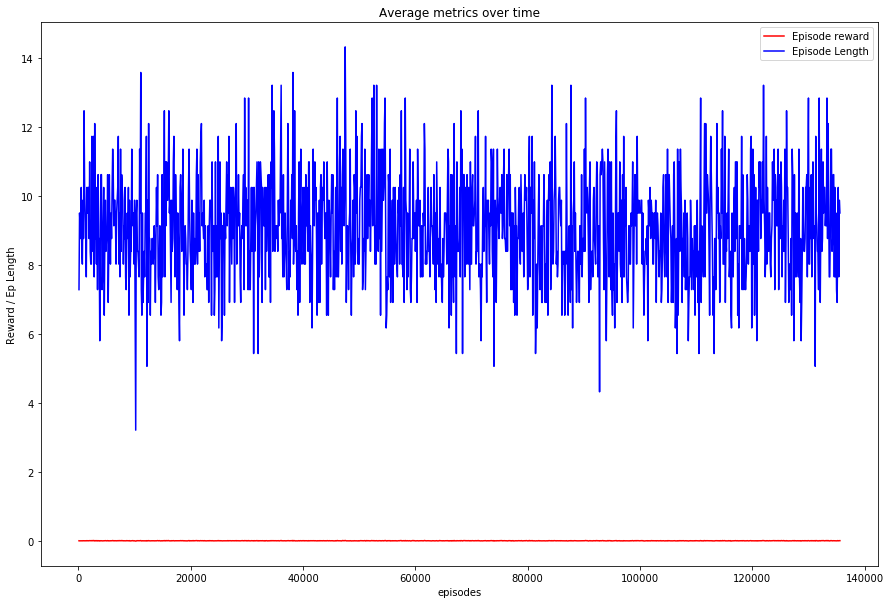

In [132]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best')

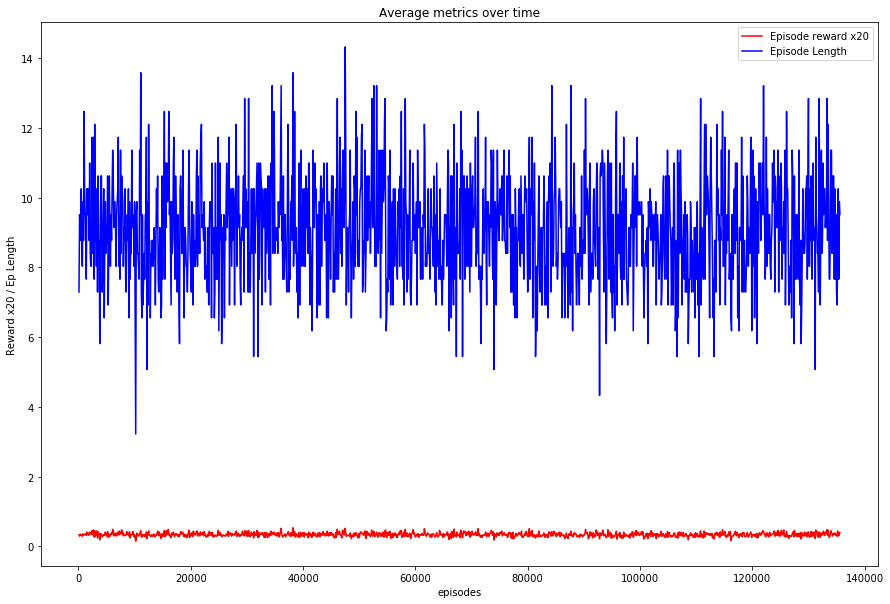

In [133]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best')

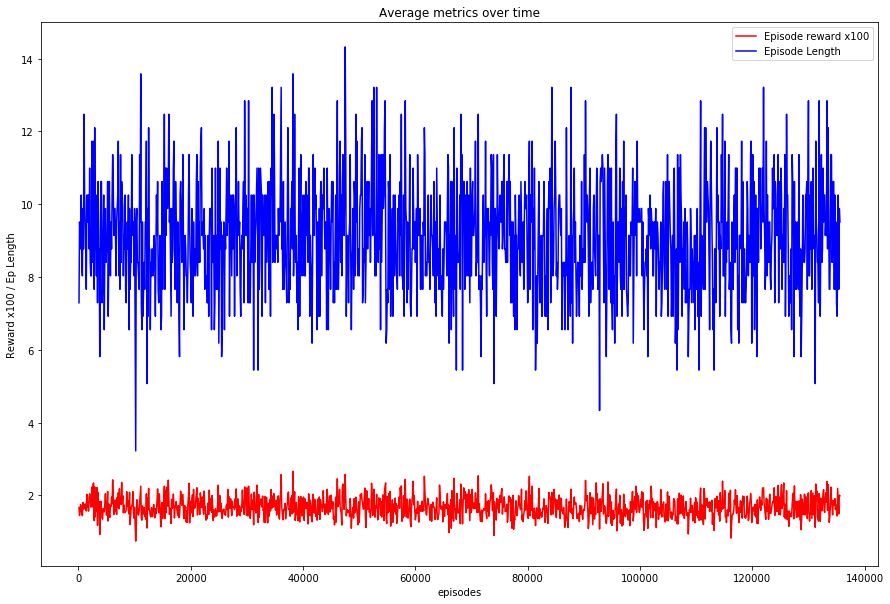

In [134]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best')

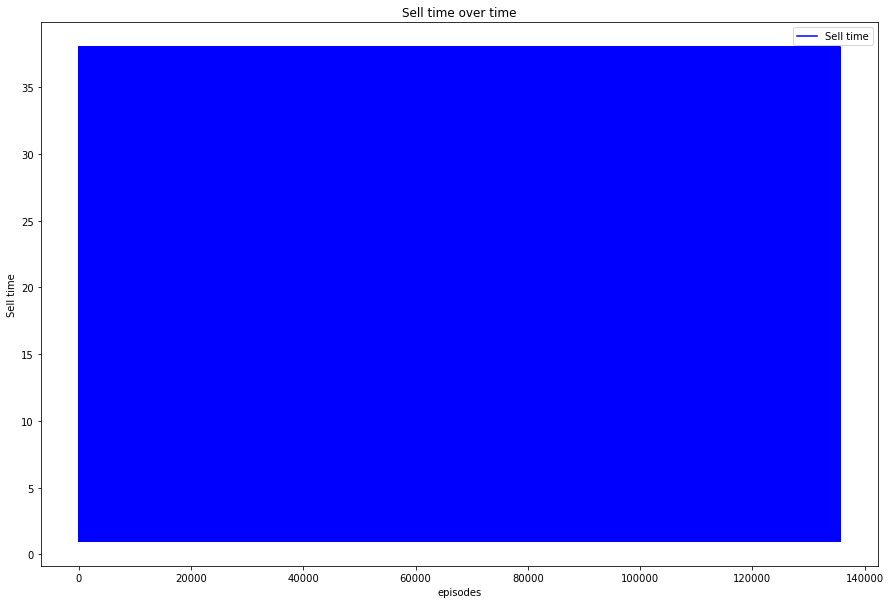

In [135]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Print size of remaining objects

In [136]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
#sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
list_objects = sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
#print(list_objects)
for x,y in list_objects:
    print(str(x)+": "+str(y))
    del x

jList: 1174056
maxPossibleOptionP_returnList: 1174056
maxPossibleOptionR_P_returnList: 1174056
maxPossibleP_returnList: 1174056
maxPossibleR_P_returnList: 1174056
maxPossiblerList: 1174056
option_percentage_rList: 1174056
option_real_percentage_rList: 1174056
percentage_rList: 1174056
rList: 1174056
real_percentage_rList: 1174056
sTimeList: 1174056
AvgEpisodeList: 11528
AvgrList: 11528
AvgsTimeList: 11528
stock_data: 7992
real_train_data: 6040
train_data: 6040
real_stocks_test_data: 1680
real_stocks_train_data: 1680
stocks_data: 1680
stocks_test_data: 1680
stocks_train_data: 1680
real_test_data: 1576
test_data: 1576
Qnetwork: 1472
AmericanOptionPricing: 1064
GBM: 1064
MinMaxScaler: 1064
experience_buffer: 1064
final_trained_model_name: 334
trained_model_name: 328
s1P: 232
sP: 232
episodeBuffer: 200
path: 169
scriptDirectory: 158
build_data: 144
leaky_relu: 144
length: 144
normalize_data: 144
prepare_company_stock: 144
prepare_data: 144
processState: 144
set_seed: 144
updateTarget: 144
